In [5]:
from transformers import AutoTokenizer, MobileBertForSequenceClassification

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch


from transformers import AdamW, get_linear_schedule_with_warmup

import json

from torch.nn.functional import softmax

import numpy as np

from transformers import AdamW, Adafactor

#from apex import amp



import torch

import numpy as np

import random

import pandas as pd



def set_seed(seed):

    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    if torch.cuda.is_available():

        torch.cuda.manual_seed_all(seed)



# Use it like this at the beginning of your code

set_seed(42)



# import nltk

# nltk.download('wordnet')

# nltk.download('omw-1.4')

# nltk.download('punkt')





#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#from nltk.translate.meteor_score import meteor_score

#from rouge import Rouge

from transformers import AutoTokenizer



import time

import datetime 

import json

import csv

import logging



from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from transformers import Adafactor


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, MobileBertForSequenceClassification, Adafactor, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torch.cuda.amp import autocast, GradScaler
import time
import datetime
import csv
import logging


In [7]:
import os
import time
import datetime
import logging
import torch
import csv
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoTokenizer, MobileBertForSequenceClassification, Adafactor, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay


In [8]:




class SQLInjectionPipeline:

    def __init__(self, config):
        self.config = config
        logging.info(f"Configuration: {self.config}")

        self.input_ids = []
        self.attention_masks = []
        self.labels = []
        self.train_dataloader = None
        self.val_dataloader = None
        self.optimizer = None
        self.scheduler = None

        self._device_setup()
        self._initialize_metrics()
        self.tokenizer = AutoTokenizer.from_pretrained(self.config['model_name'])
        self.EPOCHS = self.config['EPOCHS']



    def initialize_model(self):

        logging.info("Initializing model...")

        print("Initializing model...")

        

        if self.config['ft_model']:

            self.model = torch.load(self.config['ft_model'])

            print(f"Loaded fine-tuned model: {self.config['ft_model']}")

        elif self.config['ft_model_sd']:

            self.model = MobileBertForSequenceClassification.from_pretrained(self.config['model_name'])

            self.model.load_state_dict(torch.load(self.config['ft_model_sd']))

            print(f"Loaded fine-tuned model state_dict: {self.config['ft_model_sd']}")

        else:

            self.model = MobileBertForSequenceClassification.from_pretrained(

                self.config['model_name']

            )

            print(f"Loaded model : {self.config['model_name']}")

        

        self.model.to(self.device)

        #print(self.model.config)

        if torch.cuda.device_count() > 1:

            logging.info(f"Using {torch.cuda.device_count()} GPUs!")

            self.model = nn.DataParallel(self.model)

        if self.config['optimizer'] == 'Adafactor':

            self.optimizer = Adafactor(self.model.parameters(), **self.config['adafactor_config'])

            print("OPTIMIZER Adafactor initialized!")

        elif self.config['optimizer'] == 'AdamW':

            self.optimizer = AdamW(

                self.model.parameters(),

                lr=self.config['lr'],

                weight_decay=self.config['weight_decay']

            )

            print("OPTIMIZER AdamW initialized!")

                

           # Calculate the total steps

        total_steps = len(self.train_dataloader) * self.config['EPOCHS']

        

        if self.config['scheduler'] == 'linear' and self.config['optimizer'] != 'Adafactor':

            # Create the learning rate scheduler.

            self.scheduler = get_linear_schedule_with_warmup(

                self.optimizer, 

                num_warmup_steps=self.config['warmup_steps'],  # You can define warmup_steps in your config

                num_training_steps=total_steps

                )

            print("Scheduler initialized")

        

        logging.info("Model initialized")

        print("Model initialized")



    def _initialize_metrics(self):

        self.precision_scores = []

        self.recall_scores = []

        self.f1_scores = []

        self.roc_auc_scores = []





    def download_and_tokenize_data(self):

        print("download_and_tokenize_data started...")

        start_time = time.time()

        

        def tokenize_data(query, label):

            # This part is common to both JSON and CSV

            inputs = self.tokenizer(query, padding=False, truncation=True,max_length=512, return_tensors=None)

            self.input_ids.append(torch.tensor(inputs['input_ids']))

            self.attention_masks.append(torch.tensor(inputs['attention_mask']))

            #label =  self.tokenizer(label, padding=False, truncation=True, return_tensors=None)['input_ids']

            self.labels.append(torch.tensor(label))        

            #self.labels.append(label)        



        data_file = self.config['data_file']

        data_format = self.config['data_format']



        print(self.config['data_keys'][0])

        print(self.config['data_keys'][1])

        if data_format == 'csv':

            with open(data_file, 'r') as file:

                reader = csv.DictReader(file)

                for row in reader:

                    query = row[self.config['data_keys'][0]]

                    label = row[self.config['data_keys'][1]]

                    tokenize_data(query,int(label))

                

        elapsed = time.time() - start_time

        print(f"download_and_tokenize_data completed. Time:{elapsed:.2f}s")

        

    def prepare_and_convert(self):

        print("prepare_and_convert started")

        start_time = time.time()



        # Dynamic padding collate function

        def collate_fn(batch):

            input_ids, attention_masks, labels = zip(*batch)

            input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)

            attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

            #labels = pad_sequence(labels, batch_first=True, padding_value=0)

            labels = torch.tensor(labels)

            return input_ids, attention_masks, labels



        # Zip the lists together to form your dataset

        dataset = list(zip(self.input_ids, self.attention_masks, self.labels))



        # Split dataset into training and validation sets

        train_size = int(0.8 * len(dataset))

        val_size = len(dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])



        # Create DataLoader for training and validation sets

        self.train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32, collate_fn=collate_fn)

        self.val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32, collate_fn=collate_fn)



        elapsed = time.time() - start_time

        print(f"prepare_and_convert completed. Time: {elapsed:.2f}s")

        

    def _device_setup(self):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        print(self.device)

        logging.info("Device setup complete")

        print("Device setup complete")



    def evaluate(self):
        logging.info("Evaluation started...")
        start_time = time.time()

        self.model.eval()
        all_pred_ids = []
        all_label_ids = []

        for batch in self.val_dataloader:
            b_input_ids = batch[0].to(self.device)
            b_attention_masks = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)

            with torch.no_grad():
                outputs = self.model(input_ids=b_input_ids, attention_mask=b_attention_masks)
                logits = outputs.logits
                pred_ids = torch.argmax(logits, dim=1)

            all_pred_ids.extend(pred_ids.cpu().numpy())
            all_label_ids.extend(b_labels.cpu().numpy())

        # Calculate precision, recall, F1-score and ROC/AUC
        precision = precision_score(all_label_ids, all_pred_ids, average='weighted')
        recall = recall_score(all_label_ids, all_pred_ids, average='weighted')
        f1 = f1_score(all_label_ids, all_pred_ids, average='weighted')
        roc_auc = roc_auc_score(all_label_ids, all_pred_ids, multi_class='ovr', average='weighted')

        elapsed = time.time() - start_time
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC/AUC: {roc_auc:.4f}")
        print(f"Evaluation completed. Time: {elapsed:.2f}s")

        logging.info("Evaluation completed")

        return precision, recall, f1, roc_auc, all_label_ids, all_pred_ids

    def plot_roc_curve(self, y_true, y_pred):
        # Plot ROC curve for multi-class
        fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_score(y_true, y_pred):.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def train(self):
        from torch.nn import CrossEntropyLoss
        loss_function = CrossEntropyLoss()        

        training_results = []
        start = datetime.datetime.now()
        logging.info(f"Training started. AMP enabled: {self.config['use_amp']}. At {start}")
        print(f"Training started. AMP enabled: {self.config['use_amp']}. At {start}")

        if self.config['use_amp']:
            scaler = GradScaler()

        for epoch in range(self.EPOCHS):
            self.model.train()
            total_loss = 0
            step = 0
            start_time = time.time()
            for batch in self.train_dataloader:
                self.optimizer.zero_grad()

                b_input_ids = batch[0].to(self.device)
                b_attention_masks = batch[1].to(self.device)
                b_labels = batch[2].to(self.device)

                if self.config['use_amp']:
                    with autocast():
                        outputs = self.model(input_ids=b_input_ids, attention_mask=b_attention_masks, labels=b_labels)
                        loss = outputs.loss
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    scaler.step(self.optimizer)
                    scaler.update()
                else:
                    outputs = self.model(input_ids=b_input_ids, attention_mask=b_attention_masks)
                    logits = outputs.logits
                    loss = loss_function(logits, b_labels)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    self.optimizer.step()
                    if self.config['scheduler'] and self.config['optimizer'] != 'Adafactor':
                        self.scheduler.step()

                total_loss += loss.item()
                step += 1

                if step % int(self.config['log_batches']) == 0 and step > 0:
                    elapsed = time.time() - start_time
                    print(f"Epoch {epoch+1}/{self.EPOCHS}, Step {step}/{len(self.train_dataloader)}, Loss: {loss.item():.4f}, Time/batch: {elapsed:.2f}s") 
                    start_time = time.time()

            avg_train_loss = total_loss / len(self.train_dataloader)
            print(f"Epoch {epoch+1} finished. Average training loss: {avg_train_loss:.4f}")

            # Evaluate after each epoch
            precision, recall, f1, roc_auc, y_true, y_pred = self.evaluate()

            training_results.append({
                'epoch': epoch + 1,
                'avg_train_loss': avg_train_loss,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            })

            # Plot ROC curve and confusion matrix for each epoch
            self.plot_roc_curve(y_true, y_pred)
            self.plot_confusion_matrix(y_true, y_pred)

            # Save the model after each epoch
            ep_model_loc = f"{self.config['save_loc']}/{self.config['model']}_{self.config['version']}_model_epoch_{epoch}.pt"
            os.makedirs(self.config['save_loc'], exist_ok=True)
            torch.save(self.model, ep_model_loc)

        end = datetime.datetime.now()
        logging.info(f"Training ended. AMP enabled: {self.config['use_amp']}. At {end}")
        print(f"Training ended. AMP enabled: {self.config['use_amp']}. At {end}")

        return training_results

    def setup_and_train(self):
        self.download_and_tokenize_data()
        self.prepare_and_convert()
        self.initialize_model()
        results = self.train()
        return results
        






cuda:0
Device setup complete


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


download_and_tokenize_data started...
Query
Label
download_and_tokenize_data completed. Time:4.93s
prepare_and_convert started
prepare_and_convert completed. Time: 0.01s
Initializing model...


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model : google/mobilebert-uncased
OPTIMIZER Adafactor initialized!
Model initialized
Training started. AMP enabled: False. At 2025-02-08 02:25:37.306396


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/50, Step 50/773, Loss: 231.0863, Time/batch: 38.62s
Epoch 1/50, Step 100/773, Loss: 56.0435, Time/batch: 27.14s
Epoch 1/50, Step 150/773, Loss: 131.4822, Time/batch: 27.47s
Epoch 1/50, Step 200/773, Loss: 110.1452, Time/batch: 26.97s
Epoch 1/50, Step 250/773, Loss: 2.5652, Time/batch: 27.51s
Epoch 1/50, Step 300/773, Loss: 3787.0771, Time/batch: 27.48s
Epoch 1/50, Step 350/773, Loss: 43.4607, Time/batch: 27.53s
Epoch 1/50, Step 400/773, Loss: 31.9779, Time/batch: 27.22s
Epoch 1/50, Step 450/773, Loss: 164.8482, Time/batch: 27.44s
Epoch 1/50, Step 500/773, Loss: 18.0628, Time/batch: 27.07s
Epoch 1/50, Step 550/773, Loss: 34.0546, Time/batch: 27.50s
Epoch 1/50, Step 600/773, Loss: 89.1709, Time/batch: 27.20s
Epoch 1/50, Step 650/773, Loss: 13.2126, Time/batch: 27.22s
Epoch 1/50, Step 700/773, Loss: 69.4918, Time/batch: 27.02s
Epoch 1/50, Step 750/773, Loss: 23.9175, Time/batch: 27.34s
Epoch 1 finished. Average training loss: 2137.4258


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.1394, Recall: 0.3734, F1-score: 0.2030, ROC/AUC: 0.5000
Evaluation completed. Time: 26.90s


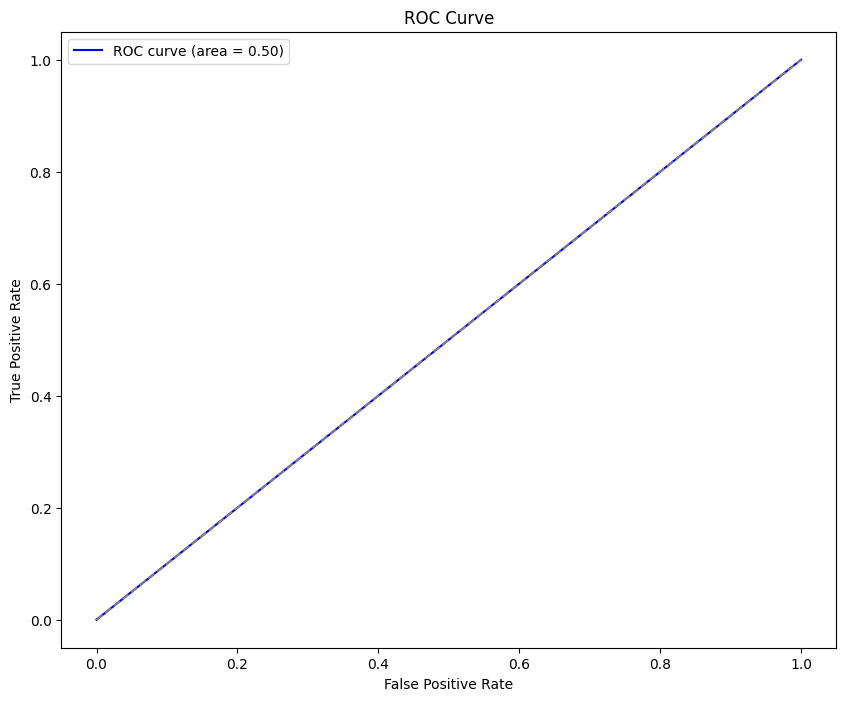

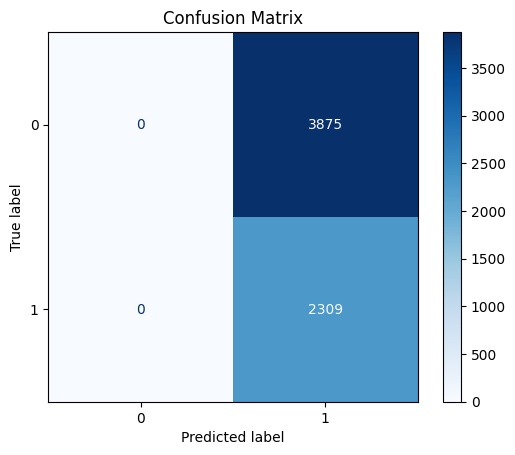

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 2/50, Step 50/773, Loss: 58.6500, Time/batch: 27.66s
Epoch 2/50, Step 100/773, Loss: 5.8387, Time/batch: 27.23s
Epoch 2/50, Step 150/773, Loss: 11.0895, Time/batch: 27.66s
Epoch 2/50, Step 200/773, Loss: 4.7272, Time/batch: 27.27s
Epoch 2/50, Step 250/773, Loss: 4.0996, Time/batch: 27.57s
Epoch 2/50, Step 300/773, Loss: 3.8043, Time/batch: 27.61s
Epoch 2/50, Step 350/773, Loss: 2.6229, Time/batch: 27.36s
Epoch 2/50, Step 400/773, Loss: 48.7301, Time/batch: 27.16s
Epoch 2/50, Step 450/773, Loss: 120.1645, Time/batch: 27.53s
Epoch 2/50, Step 500/773, Loss: 6.4251, Time/batch: 27.26s
Epoch 2/50, Step 550/773, Loss: 11.6504, Time/batch: 27.59s
Epoch 2/50, Step 600/773, Loss: 2.7167, Time/batch: 27.22s
Epoch 2/50, Step 650/773, Loss: 1.7892, Time/batch: 27.67s
Epoch 2/50, Step 700/773, Loss: 16.8931, Time/batch: 27.20s
Epoch 2/50, Step 750/773, Loss: 1.7617, Time/batch: 27.27s
Epoch 2 finished. Average training loss: 65.7730


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.3926, Recall: 0.6266, F1-score: 0.4828, ROC/AUC: 0.5000
Evaluation completed. Time: 27.21s


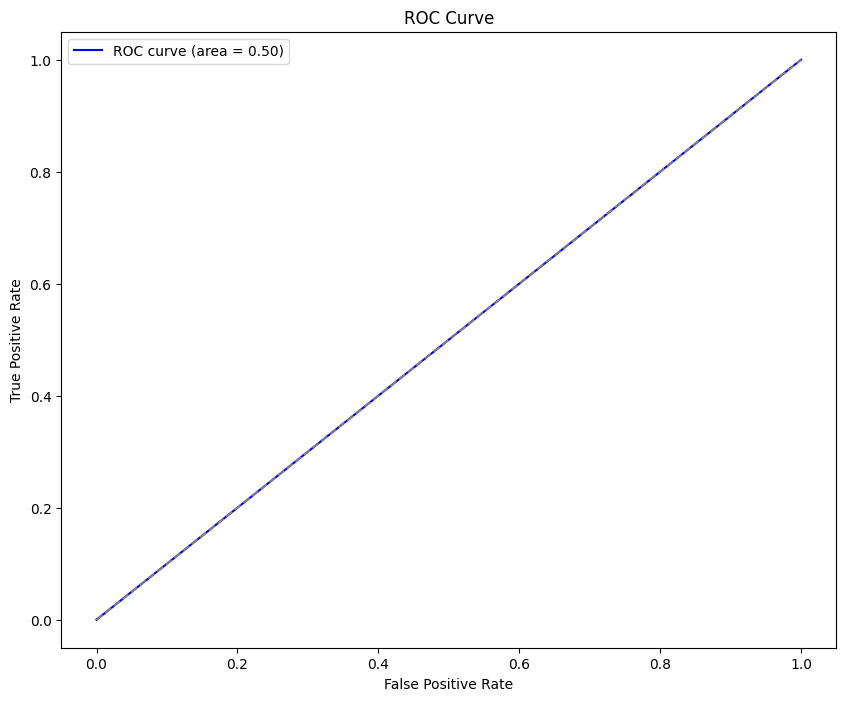

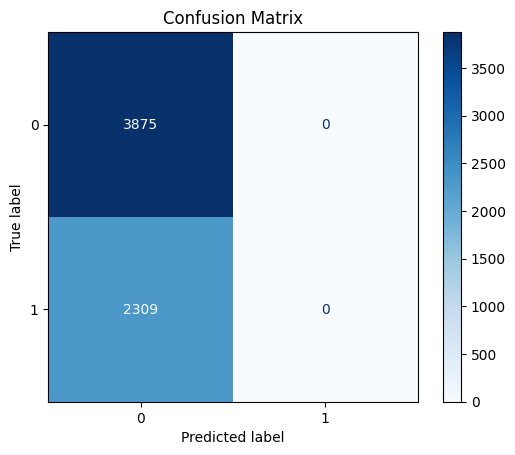

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 3/50, Step 50/773, Loss: 13.5369, Time/batch: 27.17s
Epoch 3/50, Step 100/773, Loss: 3.0853, Time/batch: 27.36s
Epoch 3/50, Step 150/773, Loss: 1.4503, Time/batch: 27.22s
Epoch 3/50, Step 200/773, Loss: 0.4743, Time/batch: 27.43s
Epoch 3/50, Step 250/773, Loss: 1.3998, Time/batch: 27.16s
Epoch 3/50, Step 300/773, Loss: 0.7033, Time/batch: 27.64s
Epoch 3/50, Step 350/773, Loss: 0.6871, Time/batch: 27.29s
Epoch 3/50, Step 400/773, Loss: 0.7505, Time/batch: 27.43s
Epoch 3/50, Step 450/773, Loss: 0.8142, Time/batch: 27.48s
Epoch 3/50, Step 500/773, Loss: 3.2213, Time/batch: 27.21s
Epoch 3/50, Step 550/773, Loss: 1.2073, Time/batch: 27.23s
Epoch 3/50, Step 600/773, Loss: 0.9495, Time/batch: 27.46s
Epoch 3/50, Step 650/773, Loss: 6.2850, Time/batch: 27.15s
Epoch 3/50, Step 700/773, Loss: 0.8069, Time/batch: 27.44s
Epoch 3/50, Step 750/773, Loss: 0.8766, Time/batch: 27.18s
Epoch 3 finished. Average training loss: 3.4984
Precision: 0.3926, Recall: 0.6266, F1-score: 0.4828, ROC/AUC: 0.500

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


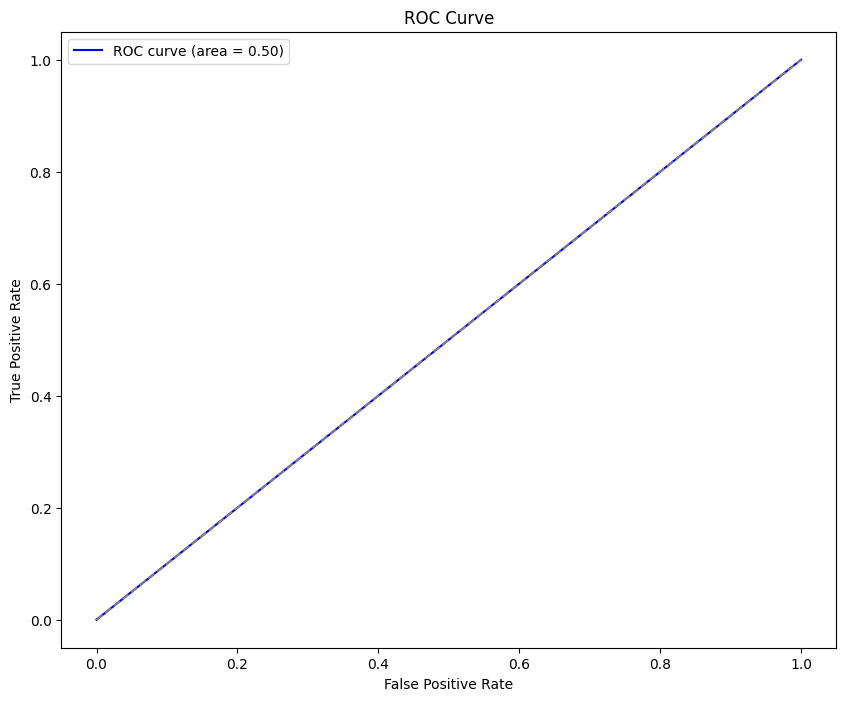

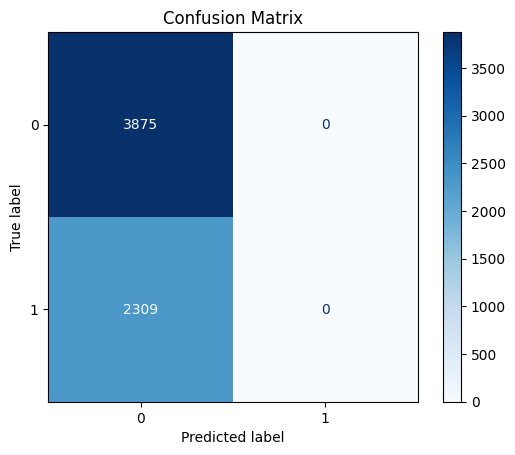

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 4/50, Step 50/773, Loss: 0.4627, Time/batch: 27.52s
Epoch 4/50, Step 100/773, Loss: 0.6210, Time/batch: 27.61s
Epoch 4/50, Step 150/773, Loss: 0.5072, Time/batch: 27.95s
Epoch 4/50, Step 200/773, Loss: 1.1369, Time/batch: 27.37s
Epoch 4/50, Step 250/773, Loss: 0.9503, Time/batch: 27.20s
Epoch 4/50, Step 300/773, Loss: 0.6672, Time/batch: 27.64s
Epoch 4/50, Step 350/773, Loss: 0.6435, Time/batch: 27.22s
Epoch 4/50, Step 400/773, Loss: 0.6211, Time/batch: 27.54s
Epoch 4/50, Step 450/773, Loss: 0.5655, Time/batch: 27.08s
Epoch 4/50, Step 500/773, Loss: 0.6837, Time/batch: 27.41s
Epoch 4/50, Step 550/773, Loss: 0.4899, Time/batch: 27.07s
Epoch 4/50, Step 600/773, Loss: 9.2140, Time/batch: 27.27s
Epoch 4/50, Step 650/773, Loss: 0.5642, Time/batch: 27.21s
Epoch 4/50, Step 700/773, Loss: 0.4981, Time/batch: 27.50s
Epoch 4/50, Step 750/773, Loss: 0.9358, Time/batch: 27.15s
Epoch 4 finished. Average training loss: 1.4167
Precision: 0.3926, Recall: 0.6266, F1-score: 0.4828, ROC/AUC: 0.5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


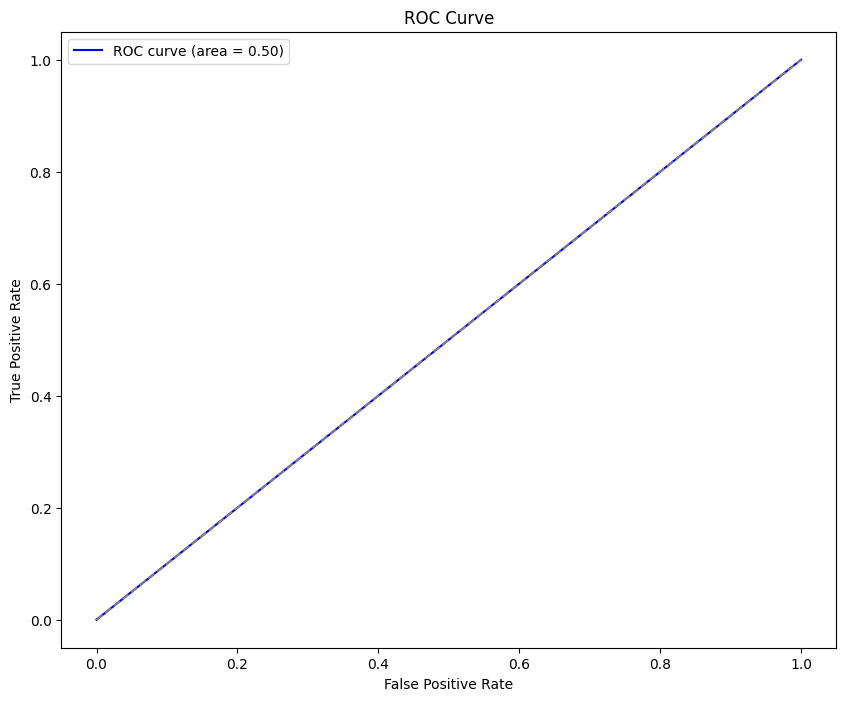

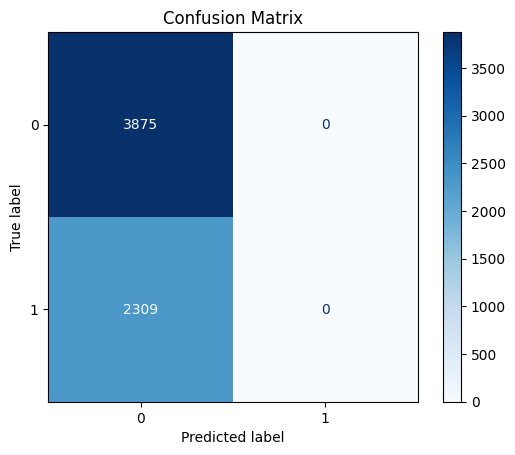

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 5/50, Step 50/773, Loss: 0.6659, Time/batch: 27.11s
Epoch 5/50, Step 100/773, Loss: 0.4497, Time/batch: 27.32s
Epoch 5/50, Step 150/773, Loss: 0.6056, Time/batch: 27.16s
Epoch 5/50, Step 200/773, Loss: 0.5666, Time/batch: 27.88s
Epoch 5/50, Step 250/773, Loss: 0.7733, Time/batch: 27.13s
Epoch 5/50, Step 300/773, Loss: 3.5982, Time/batch: 27.25s
Epoch 5/50, Step 350/773, Loss: 0.5983, Time/batch: 27.01s
Epoch 5/50, Step 400/773, Loss: 0.7488, Time/batch: 27.15s
Epoch 5/50, Step 450/773, Loss: 0.4418, Time/batch: 27.52s
Epoch 5/50, Step 500/773, Loss: 0.7216, Time/batch: 27.44s
Epoch 5/50, Step 550/773, Loss: 0.5683, Time/batch: 27.13s
Epoch 5/50, Step 600/773, Loss: 0.4778, Time/batch: 27.04s
Epoch 5/50, Step 650/773, Loss: 0.5102, Time/batch: 27.38s
Epoch 5/50, Step 700/773, Loss: 0.5991, Time/batch: 27.05s
Epoch 5/50, Step 750/773, Loss: 0.5313, Time/batch: 27.52s
Epoch 5 finished. Average training loss: 2.6605
Precision: 0.8766, Recall: 0.8545, F1-score: 0.8454, ROC/AUC: 0.8078

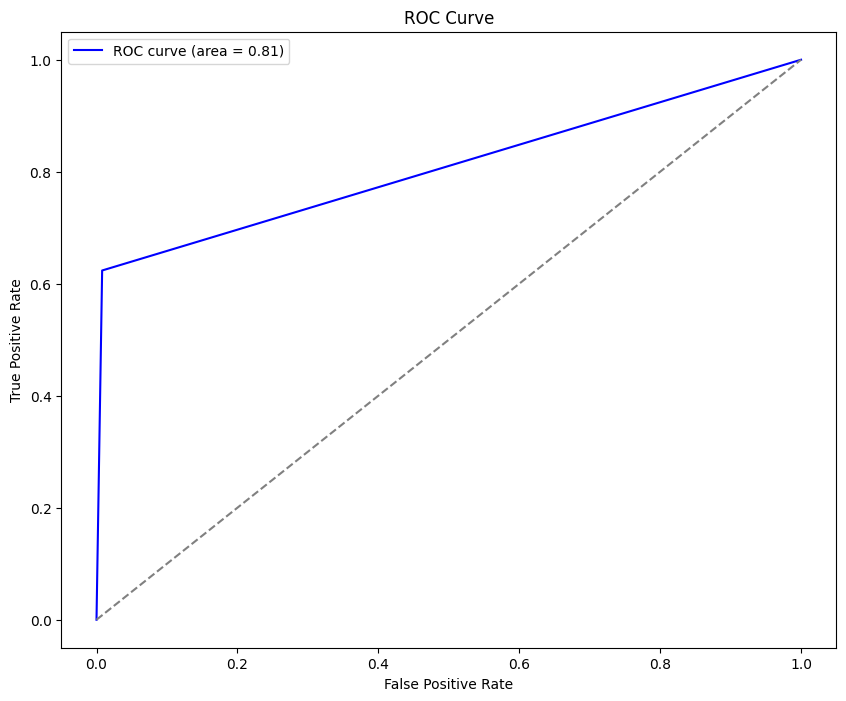

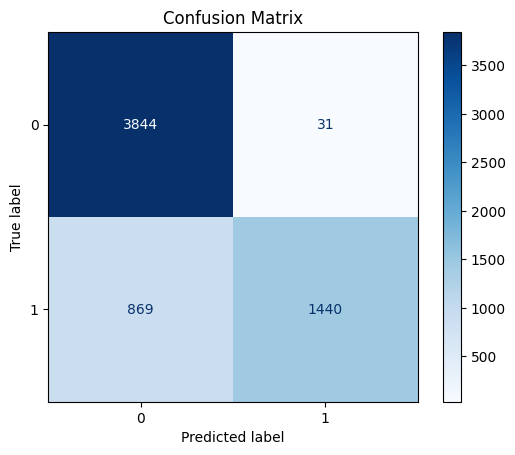

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 6/50, Step 50/773, Loss: 0.3536, Time/batch: 27.87s
Epoch 6/50, Step 100/773, Loss: 18.4238, Time/batch: 27.06s
Epoch 6/50, Step 150/773, Loss: 0.3377, Time/batch: 27.48s
Epoch 6/50, Step 200/773, Loss: 0.0791, Time/batch: 27.02s
Epoch 6/50, Step 250/773, Loss: 0.0642, Time/batch: 27.41s
Epoch 6/50, Step 300/773, Loss: 0.3361, Time/batch: 27.03s
Epoch 6/50, Step 350/773, Loss: 0.0266, Time/batch: 27.51s
Epoch 6/50, Step 400/773, Loss: 0.0572, Time/batch: 26.86s
Epoch 6/50, Step 450/773, Loss: 0.2240, Time/batch: 27.30s
Epoch 6/50, Step 500/773, Loss: 0.0087, Time/batch: 27.09s
Epoch 6/50, Step 550/773, Loss: 0.1711, Time/batch: 27.50s
Epoch 6/50, Step 600/773, Loss: 0.0154, Time/batch: 27.05s
Epoch 6/50, Step 650/773, Loss: 0.2492, Time/batch: 27.31s
Epoch 6/50, Step 700/773, Loss: 0.0004, Time/batch: 27.25s
Epoch 6/50, Step 750/773, Loss: 0.0001, Time/batch: 27.37s
Epoch 6 finished. Average training loss: 0.3813
Precision: 0.9937, Recall: 0.9937, F1-score: 0.9937, ROC/AUC: 0.992

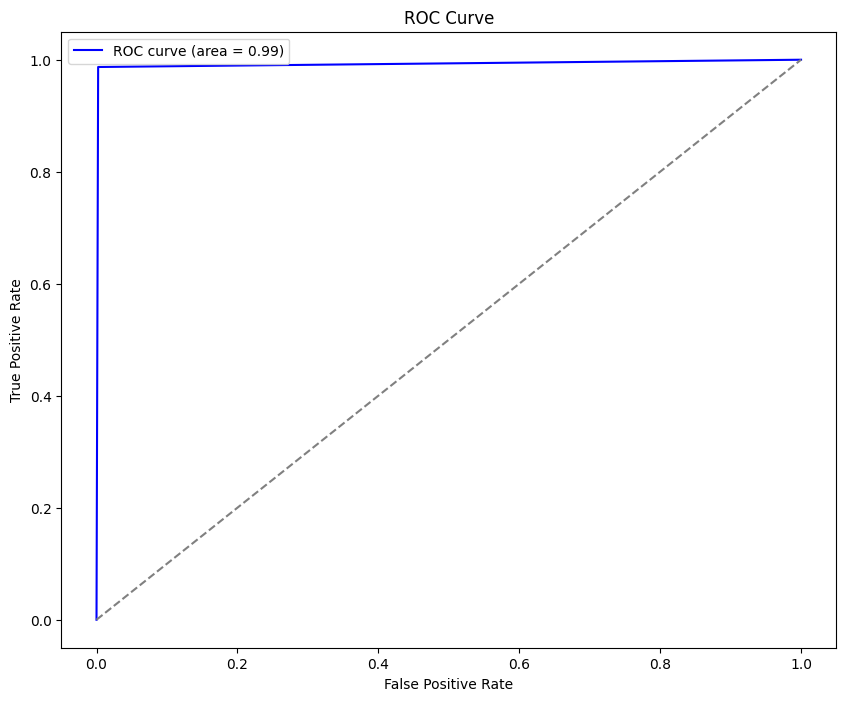

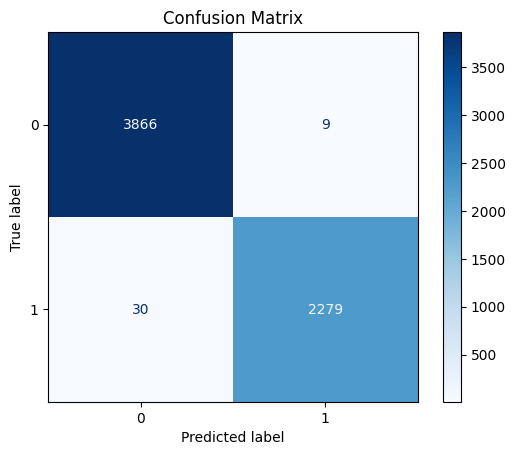

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 7/50, Step 50/773, Loss: 0.0016, Time/batch: 27.52s
Epoch 7/50, Step 100/773, Loss: 0.0074, Time/batch: 26.85s
Epoch 7/50, Step 150/773, Loss: 0.0014, Time/batch: 27.43s
Epoch 7/50, Step 200/773, Loss: 0.0050, Time/batch: 27.13s
Epoch 7/50, Step 250/773, Loss: 0.0494, Time/batch: 27.60s
Epoch 7/50, Step 300/773, Loss: 0.0518, Time/batch: 27.24s
Epoch 7/50, Step 350/773, Loss: 0.0001, Time/batch: 27.41s
Epoch 7/50, Step 400/773, Loss: 0.5689, Time/batch: 27.00s
Epoch 7/50, Step 450/773, Loss: 0.0020, Time/batch: 27.95s
Epoch 7/50, Step 500/773, Loss: 0.0135, Time/batch: 26.82s
Epoch 7/50, Step 550/773, Loss: 0.0009, Time/batch: 27.44s
Epoch 7/50, Step 600/773, Loss: 0.0008, Time/batch: 27.06s
Epoch 7/50, Step 650/773, Loss: 0.0939, Time/batch: 27.33s
Epoch 7/50, Step 700/773, Loss: 0.0002, Time/batch: 27.11s
Epoch 7/50, Step 750/773, Loss: 0.2741, Time/batch: 27.39s
Epoch 7 finished. Average training loss: 0.1138
Precision: 0.9949, Recall: 0.9948, F1-score: 0.9948, ROC/AUC: 0.9932

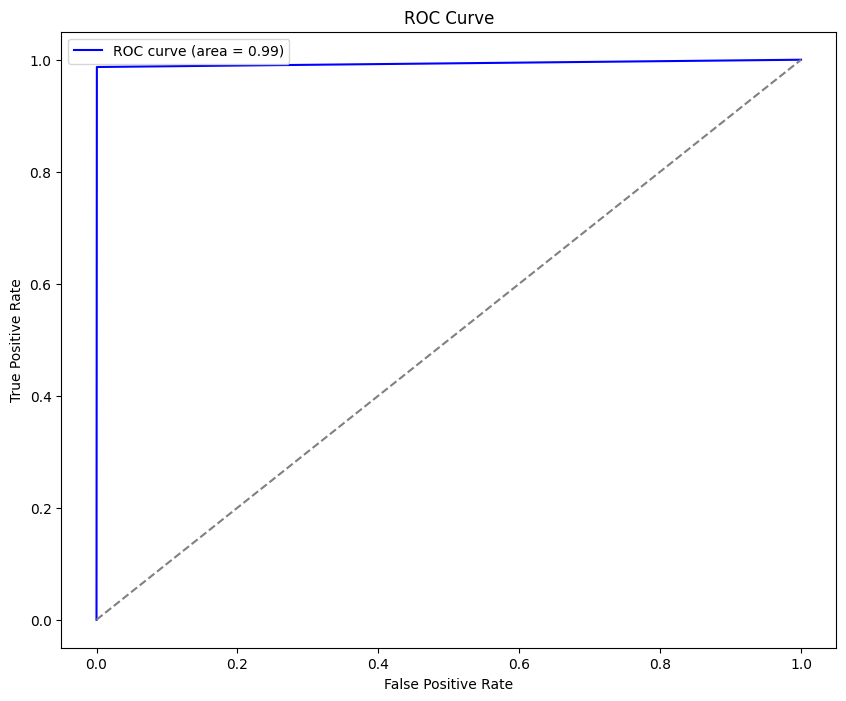

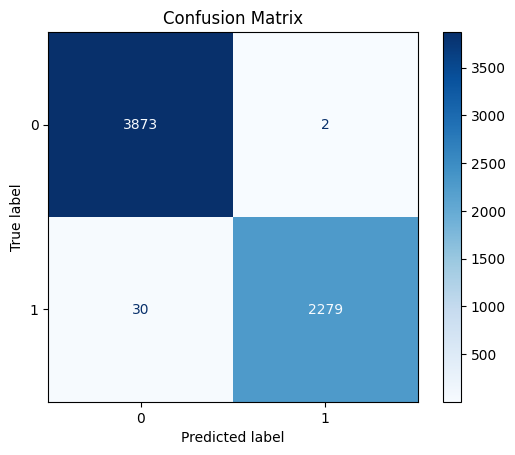

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 8/50, Step 50/773, Loss: 0.0013, Time/batch: 27.10s
Epoch 8/50, Step 100/773, Loss: 0.0584, Time/batch: 27.25s
Epoch 8/50, Step 150/773, Loss: 0.2409, Time/batch: 27.19s
Epoch 8/50, Step 200/773, Loss: 0.0019, Time/batch: 27.27s
Epoch 8/50, Step 250/773, Loss: 0.0011, Time/batch: 27.31s
Epoch 8/50, Step 300/773, Loss: 0.0018, Time/batch: 27.34s
Epoch 8/50, Step 350/773, Loss: 0.0008, Time/batch: 26.98s
Epoch 8/50, Step 400/773, Loss: 0.0007, Time/batch: 27.35s
Epoch 8/50, Step 450/773, Loss: 0.0016, Time/batch: 27.14s
Epoch 8/50, Step 500/773, Loss: 232.8405, Time/batch: 27.58s
Epoch 8/50, Step 550/773, Loss: 0.0009, Time/batch: 26.83s
Epoch 8/50, Step 600/773, Loss: 0.1763, Time/batch: 27.21s
Epoch 8/50, Step 650/773, Loss: 0.3205, Time/batch: 27.42s
Epoch 8/50, Step 700/773, Loss: 0.0019, Time/batch: 27.34s
Epoch 8/50, Step 750/773, Loss: 0.0004, Time/batch: 26.98s
Epoch 8 finished. Average training loss: 1.1128
Precision: 0.9950, Recall: 0.9950, F1-score: 0.9950, ROC/AUC: 0.99

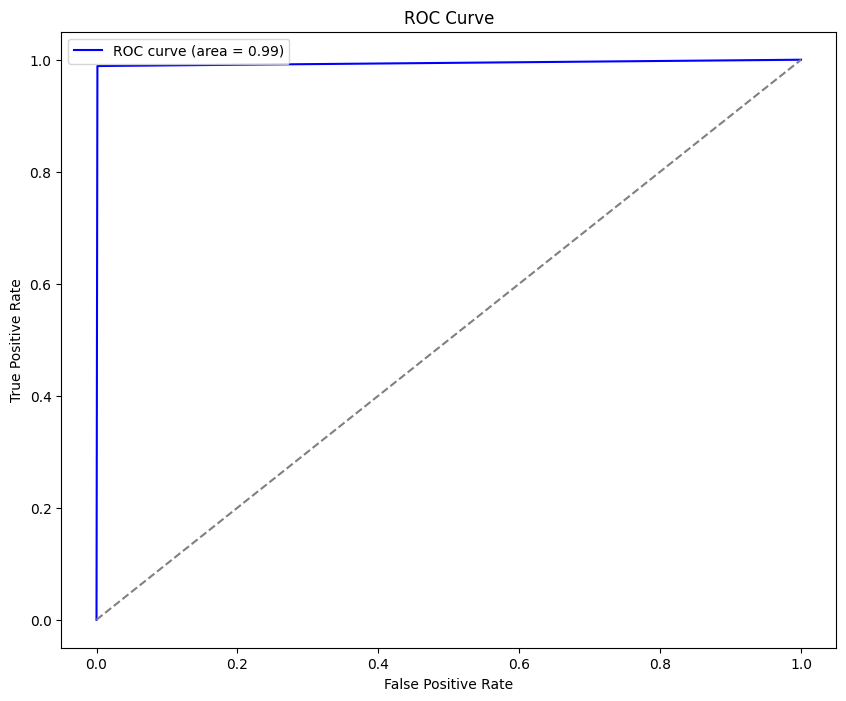

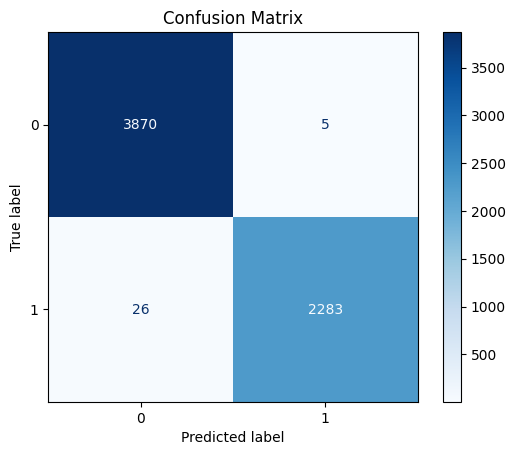

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 9/50, Step 50/773, Loss: 0.0016, Time/batch: 27.51s
Epoch 9/50, Step 100/773, Loss: 0.0008, Time/batch: 27.41s
Epoch 9/50, Step 150/773, Loss: 0.0003, Time/batch: 26.93s
Epoch 9/50, Step 200/773, Loss: 0.0031, Time/batch: 27.40s
Epoch 9/50, Step 250/773, Loss: 0.0007, Time/batch: 26.96s
Epoch 9/50, Step 300/773, Loss: 0.0013, Time/batch: 27.23s
Epoch 9/50, Step 350/773, Loss: 0.0016, Time/batch: 27.05s
Epoch 9/50, Step 400/773, Loss: 0.0015, Time/batch: 27.47s
Epoch 9/50, Step 450/773, Loss: 0.0004, Time/batch: 27.04s
Epoch 9/50, Step 500/773, Loss: 0.0004, Time/batch: 27.31s
Epoch 9/50, Step 550/773, Loss: 0.0011, Time/batch: 27.19s
Epoch 9/50, Step 600/773, Loss: 0.0009, Time/batch: 27.40s
Epoch 9/50, Step 650/773, Loss: 0.0010, Time/batch: 26.82s
Epoch 9/50, Step 700/773, Loss: 0.0007, Time/batch: 27.38s
Epoch 9/50, Step 750/773, Loss: 0.0003, Time/batch: 26.94s
Epoch 9 finished. Average training loss: 2.6672
Precision: 0.9929, Recall: 0.9929, F1-score: 0.9929, ROC/AUC: 0.9906

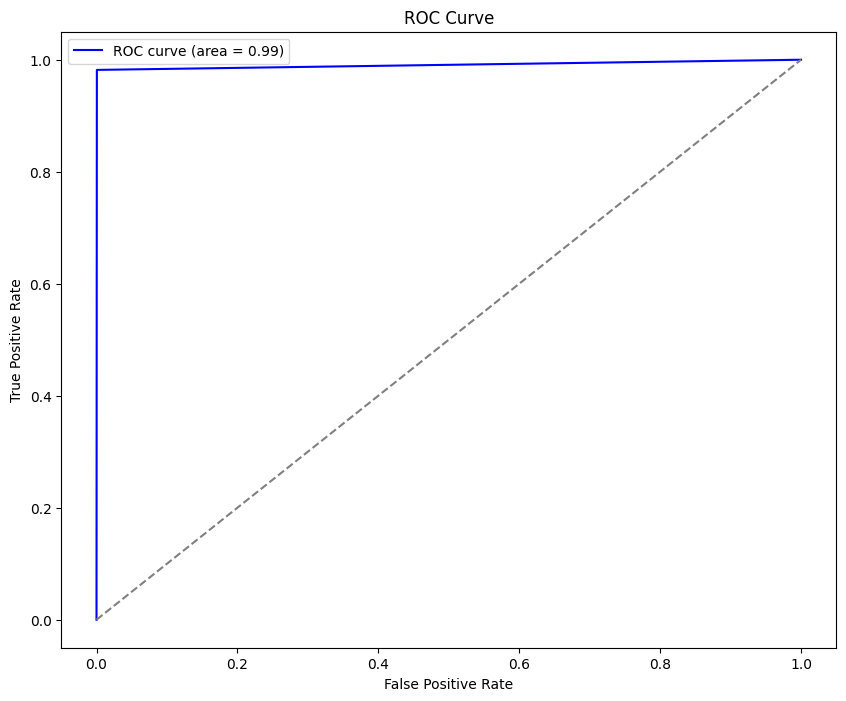

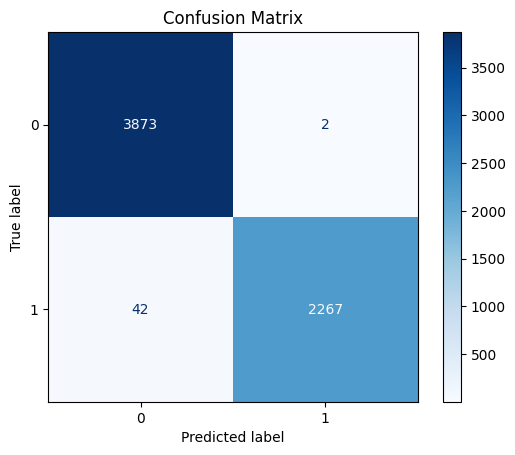

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 10/50, Step 50/773, Loss: 0.0012, Time/batch: 27.27s
Epoch 10/50, Step 100/773, Loss: 0.0002, Time/batch: 26.94s
Epoch 10/50, Step 150/773, Loss: 0.0012, Time/batch: 27.36s
Epoch 10/50, Step 200/773, Loss: 0.0014, Time/batch: 26.97s
Epoch 10/50, Step 250/773, Loss: 0.0004, Time/batch: 27.35s
Epoch 10/50, Step 300/773, Loss: 0.0006, Time/batch: 27.11s
Epoch 10/50, Step 350/773, Loss: 1.7213, Time/batch: 27.09s
Epoch 10/50, Step 400/773, Loss: 0.0010, Time/batch: 27.01s
Epoch 10/50, Step 450/773, Loss: 0.0006, Time/batch: 27.42s
Epoch 10/50, Step 500/773, Loss: 0.0008, Time/batch: 26.86s
Epoch 10/50, Step 550/773, Loss: 0.0013, Time/batch: 27.27s
Epoch 10/50, Step 600/773, Loss: 0.0009, Time/batch: 26.98s
Epoch 10/50, Step 650/773, Loss: 0.0009, Time/batch: 27.17s
Epoch 10/50, Step 700/773, Loss: 1.0564, Time/batch: 26.84s
Epoch 10/50, Step 750/773, Loss: 0.0018, Time/batch: 27.68s
Epoch 10 finished. Average training loss: 34.1417
Precision: 0.9952, Recall: 0.9951, F1-score: 0.9951

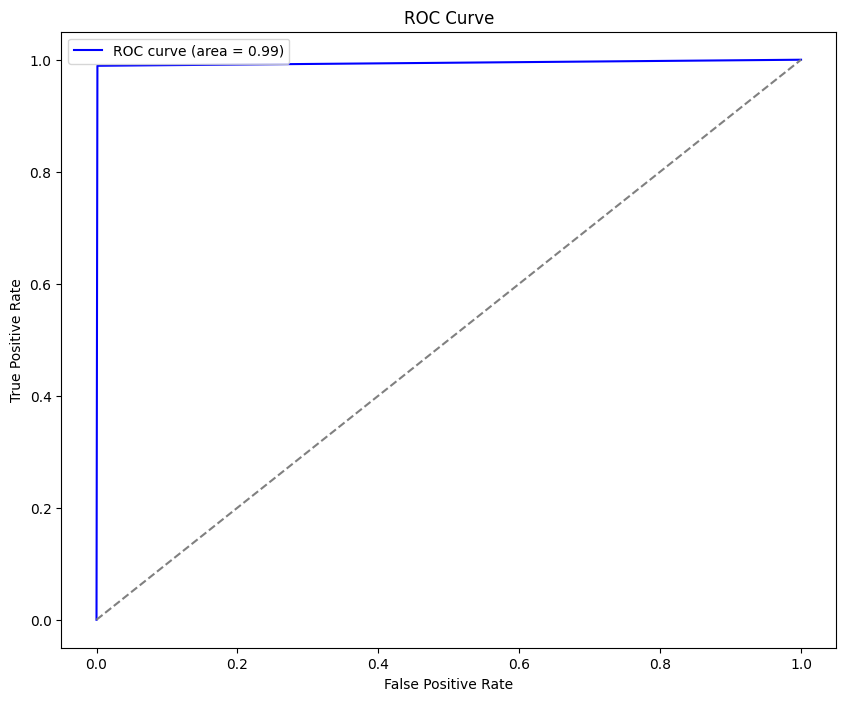

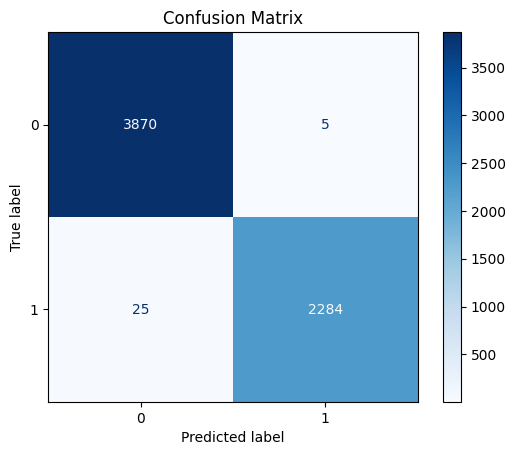

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 11/50, Step 50/773, Loss: 0.0005, Time/batch: 27.50s
Epoch 11/50, Step 100/773, Loss: 0.0002, Time/batch: 27.11s
Epoch 11/50, Step 150/773, Loss: 0.0002, Time/batch: 27.51s
Epoch 11/50, Step 200/773, Loss: 0.0008, Time/batch: 27.02s
Epoch 11/50, Step 250/773, Loss: 0.0034, Time/batch: 27.38s
Epoch 11/50, Step 300/773, Loss: 0.0003, Time/batch: 27.06s
Epoch 11/50, Step 350/773, Loss: 0.0008, Time/batch: 27.30s
Epoch 11/50, Step 400/773, Loss: 0.0444, Time/batch: 27.16s
Epoch 11/50, Step 450/773, Loss: 0.0003, Time/batch: 27.07s
Epoch 11/50, Step 500/773, Loss: 0.0009, Time/batch: 27.60s
Epoch 11/50, Step 550/773, Loss: 0.0030, Time/batch: 27.22s
Epoch 11/50, Step 600/773, Loss: 0.0011, Time/batch: 27.86s
Epoch 11/50, Step 650/773, Loss: 0.0002, Time/batch: 27.62s
Epoch 11/50, Step 700/773, Loss: 0.0005, Time/batch: 27.48s
Epoch 11/50, Step 750/773, Loss: 0.0003, Time/batch: 27.28s
Epoch 11 finished. Average training loss: 45.8325
Precision: 0.9957, Recall: 0.9956, F1-score: 0.9956

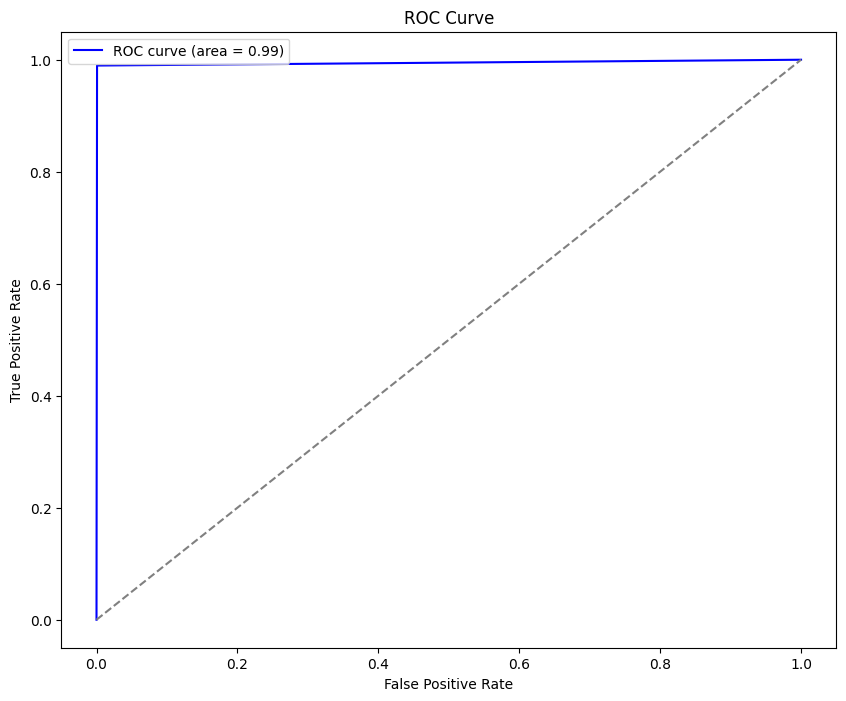

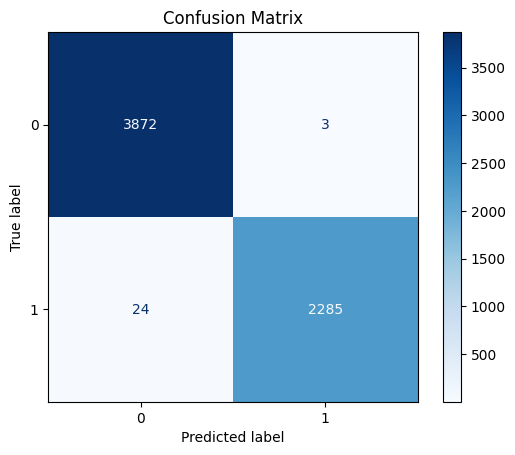

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 12/50, Step 50/773, Loss: 0.0010, Time/batch: 27.08s
Epoch 12/50, Step 100/773, Loss: 0.0006, Time/batch: 27.43s
Epoch 12/50, Step 150/773, Loss: 0.0020, Time/batch: 27.05s
Epoch 12/50, Step 200/773, Loss: 0.0006, Time/batch: 27.26s
Epoch 12/50, Step 250/773, Loss: 0.0001, Time/batch: 27.02s
Epoch 12/50, Step 300/773, Loss: 0.0006, Time/batch: 27.81s
Epoch 12/50, Step 350/773, Loss: 0.0002, Time/batch: 27.22s
Epoch 12/50, Step 400/773, Loss: 0.0006, Time/batch: 27.14s
Epoch 12/50, Step 450/773, Loss: 0.0006, Time/batch: 27.01s
Epoch 12/50, Step 500/773, Loss: 0.0002, Time/batch: 27.33s
Epoch 12/50, Step 550/773, Loss: 0.0001, Time/batch: 26.69s
Epoch 12/50, Step 600/773, Loss: 0.0002, Time/batch: 27.45s
Epoch 12/50, Step 650/773, Loss: 0.0002, Time/batch: 26.94s
Epoch 12/50, Step 700/773, Loss: 0.0007, Time/batch: 27.44s
Epoch 12/50, Step 750/773, Loss: 0.0004, Time/batch: 27.07s
Epoch 12 finished. Average training loss: 0.1969
Precision: 0.9969, Recall: 0.9969, F1-score: 0.9969,

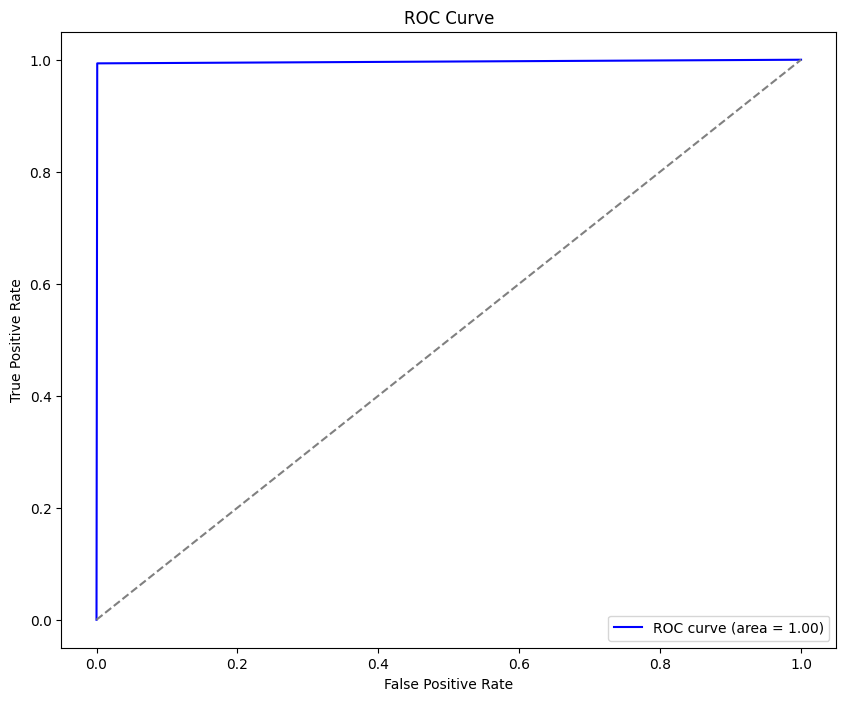

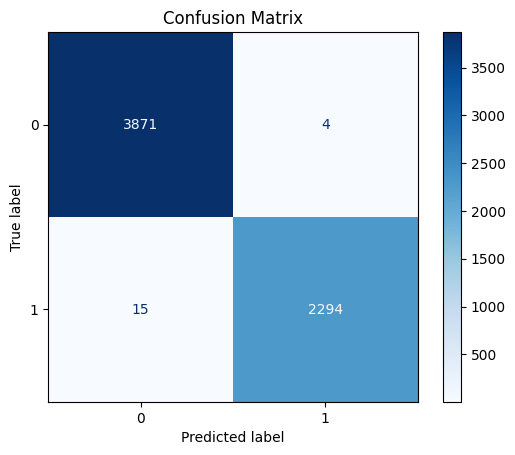

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 13/50, Step 50/773, Loss: 0.0001, Time/batch: 27.02s
Epoch 13/50, Step 100/773, Loss: 0.0004, Time/batch: 27.38s
Epoch 13/50, Step 150/773, Loss: 0.0000, Time/batch: 27.05s
Epoch 13/50, Step 200/773, Loss: 0.0002, Time/batch: 27.47s
Epoch 13/50, Step 250/773, Loss: 0.2229, Time/batch: 26.90s
Epoch 13/50, Step 300/773, Loss: 0.0003, Time/batch: 27.53s
Epoch 13/50, Step 350/773, Loss: 0.0001, Time/batch: 27.12s
Epoch 13/50, Step 400/773, Loss: 0.0006, Time/batch: 27.18s
Epoch 13/50, Step 450/773, Loss: 0.0002, Time/batch: 27.36s
Epoch 13/50, Step 500/773, Loss: 0.0005, Time/batch: 27.14s
Epoch 13/50, Step 550/773, Loss: 0.0000, Time/batch: 27.53s
Epoch 13/50, Step 600/773, Loss: 0.0009, Time/batch: 27.05s
Epoch 13/50, Step 650/773, Loss: 0.0004, Time/batch: 27.48s
Epoch 13/50, Step 700/773, Loss: 0.0002, Time/batch: 27.05s
Epoch 13/50, Step 750/773, Loss: 0.0002, Time/batch: 27.23s
Epoch 13 finished. Average training loss: 0.6204
Precision: 0.9947, Recall: 0.9947, F1-score: 0.9947,

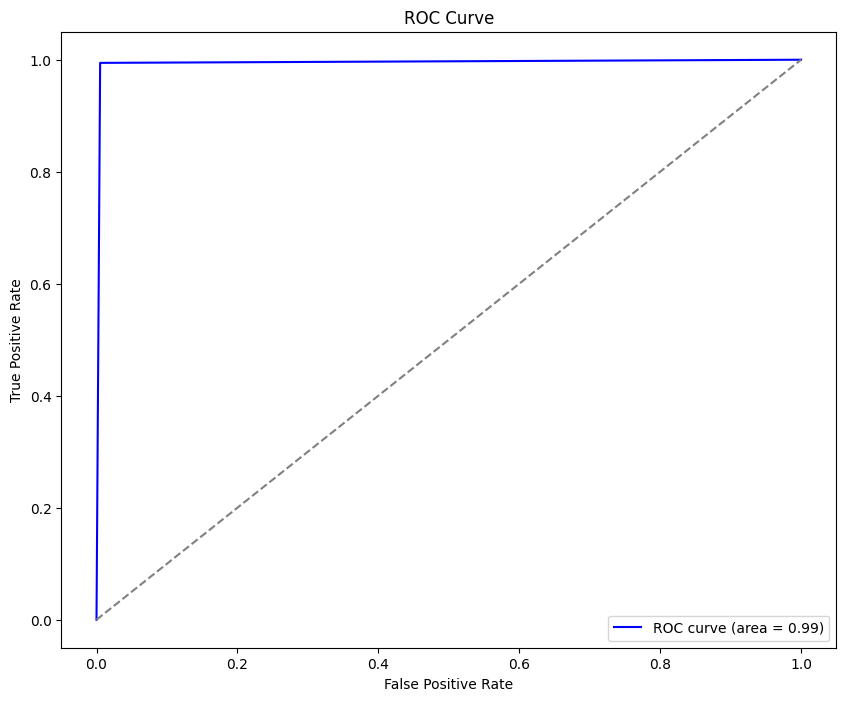

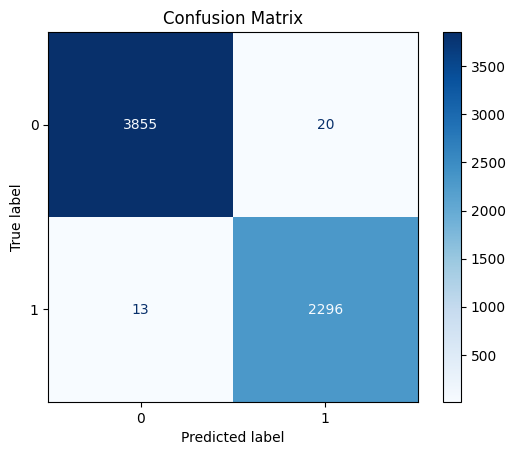

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 14/50, Step 50/773, Loss: 0.0002, Time/batch: 27.34s
Epoch 14/50, Step 100/773, Loss: 0.0003, Time/batch: 27.00s
Epoch 14/50, Step 150/773, Loss: 0.0005, Time/batch: 27.60s
Epoch 14/50, Step 200/773, Loss: 0.0007, Time/batch: 27.09s
Epoch 14/50, Step 250/773, Loss: 0.0002, Time/batch: 27.28s
Epoch 14/50, Step 300/773, Loss: 0.0001, Time/batch: 26.81s
Epoch 14/50, Step 350/773, Loss: 0.0004, Time/batch: 27.26s
Epoch 14/50, Step 400/773, Loss: 0.0001, Time/batch: 27.17s
Epoch 14/50, Step 450/773, Loss: 0.0001, Time/batch: 27.37s
Epoch 14/50, Step 500/773, Loss: 0.0001, Time/batch: 26.95s
Epoch 14/50, Step 550/773, Loss: 0.0003, Time/batch: 27.70s
Epoch 14/50, Step 600/773, Loss: 0.0004, Time/batch: 27.12s
Epoch 14/50, Step 650/773, Loss: 0.0004, Time/batch: 27.38s
Epoch 14/50, Step 700/773, Loss: 0.0006, Time/batch: 27.04s
Epoch 14/50, Step 750/773, Loss: 0.0004, Time/batch: 27.44s
Epoch 14 finished. Average training loss: 97.9507
Precision: 0.9952, Recall: 0.9951, F1-score: 0.9952

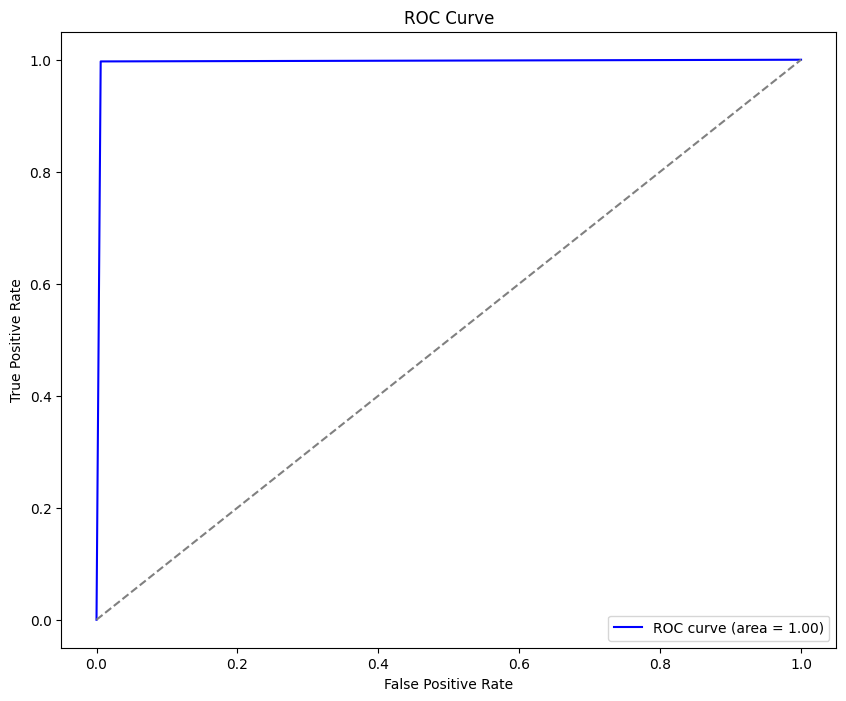

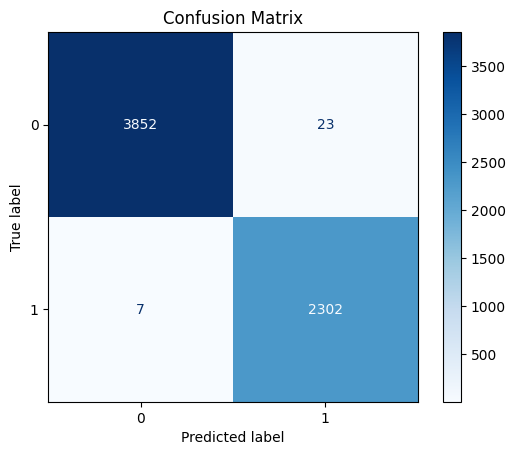

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 15/50, Step 50/773, Loss: 0.0006, Time/batch: 26.82s
Epoch 15/50, Step 100/773, Loss: 0.0001, Time/batch: 27.44s
Epoch 15/50, Step 150/773, Loss: 0.0007, Time/batch: 27.08s
Epoch 15/50, Step 200/773, Loss: 0.0002, Time/batch: 27.29s
Epoch 15/50, Step 250/773, Loss: 0.0059, Time/batch: 27.05s
Epoch 15/50, Step 300/773, Loss: 0.1633, Time/batch: 27.28s
Epoch 15/50, Step 350/773, Loss: 0.2038, Time/batch: 27.10s
Epoch 15/50, Step 400/773, Loss: 0.0003, Time/batch: 27.11s
Epoch 15/50, Step 450/773, Loss: 0.0001, Time/batch: 27.19s
Epoch 15/50, Step 500/773, Loss: 0.0001, Time/batch: 27.44s
Epoch 15/50, Step 550/773, Loss: 0.0001, Time/batch: 27.12s
Epoch 15/50, Step 600/773, Loss: 0.0004, Time/batch: 27.34s
Epoch 15/50, Step 650/773, Loss: 0.0771, Time/batch: 27.10s
Epoch 15/50, Step 700/773, Loss: 0.0005, Time/batch: 27.71s
Epoch 15/50, Step 750/773, Loss: 0.0001, Time/batch: 26.94s
Epoch 15 finished. Average training loss: 0.3427
Precision: 0.9948, Recall: 0.9948, F1-score: 0.9948,

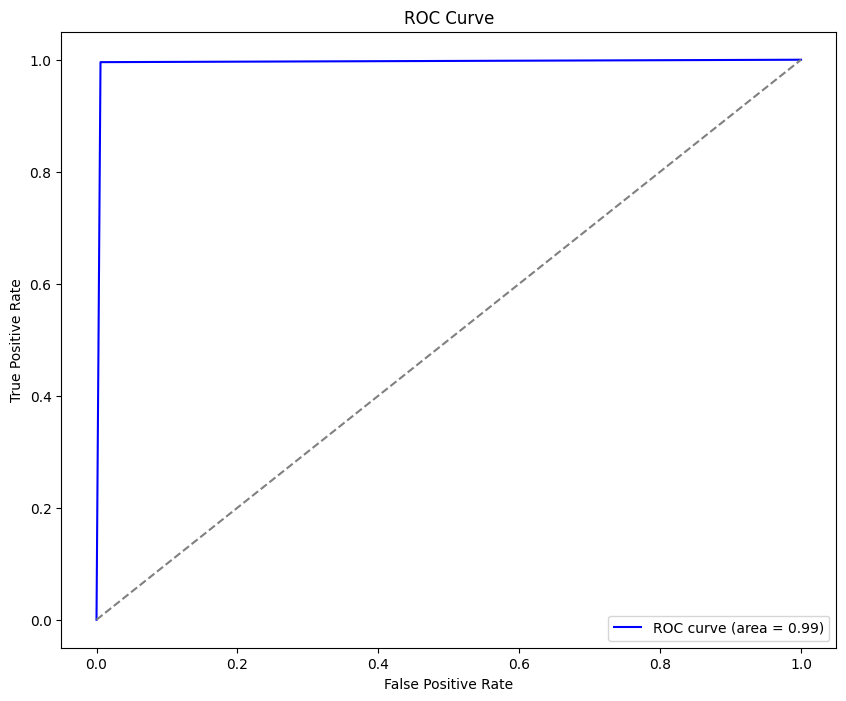

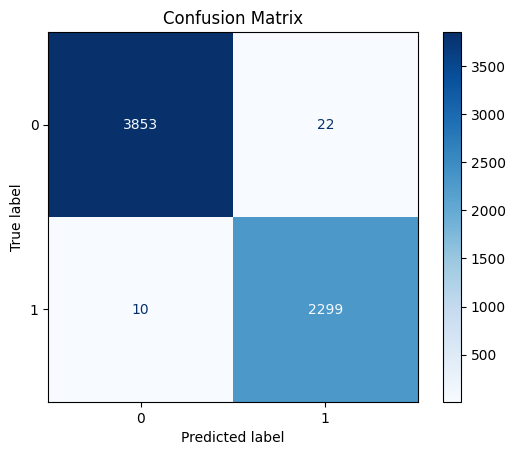

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 16/50, Step 50/773, Loss: 0.0003, Time/batch: 27.53s
Epoch 16/50, Step 100/773, Loss: 0.0002, Time/batch: 27.34s
Epoch 16/50, Step 150/773, Loss: 0.0001, Time/batch: 26.78s
Epoch 16/50, Step 200/773, Loss: 0.0004, Time/batch: 27.30s
Epoch 16/50, Step 250/773, Loss: 0.0000, Time/batch: 27.11s
Epoch 16/50, Step 300/773, Loss: 0.0009, Time/batch: 27.44s
Epoch 16/50, Step 350/773, Loss: 0.0001, Time/batch: 26.94s
Epoch 16/50, Step 400/773, Loss: 0.0003, Time/batch: 26.97s
Epoch 16/50, Step 450/773, Loss: 0.0005, Time/batch: 27.36s
Epoch 16/50, Step 500/773, Loss: 0.0001, Time/batch: 26.83s
Epoch 16/50, Step 550/773, Loss: 0.0003, Time/batch: 27.39s
Epoch 16/50, Step 600/773, Loss: 0.0001, Time/batch: 27.05s
Epoch 16/50, Step 650/773, Loss: 0.0002, Time/batch: 27.34s
Epoch 16/50, Step 700/773, Loss: 0.0001, Time/batch: 27.03s
Epoch 16/50, Step 750/773, Loss: 0.0001, Time/batch: 27.48s
Epoch 16 finished. Average training loss: 0.0444
Precision: 0.9952, Recall: 0.9951, F1-score: 0.9951,

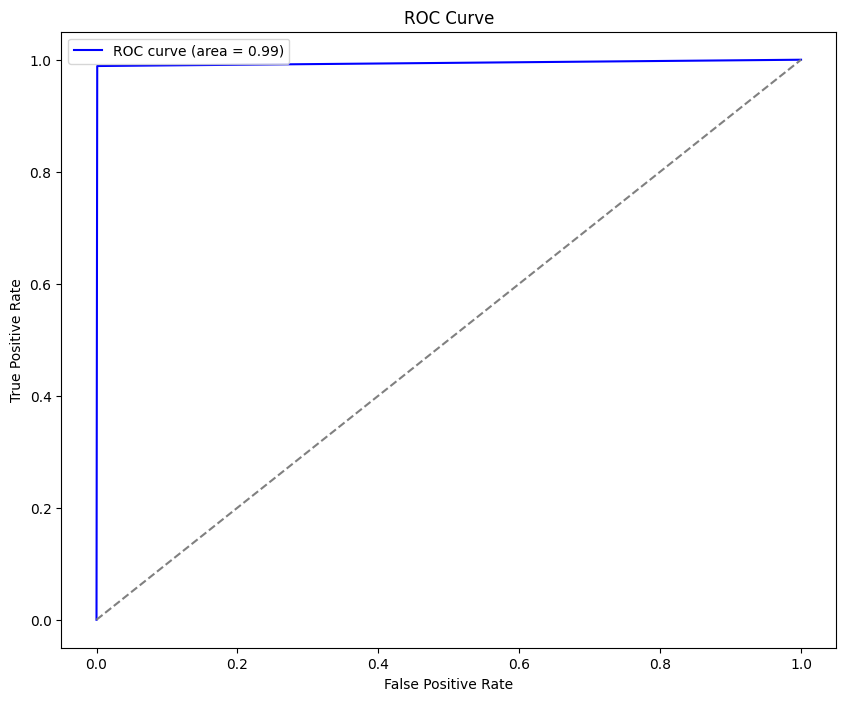

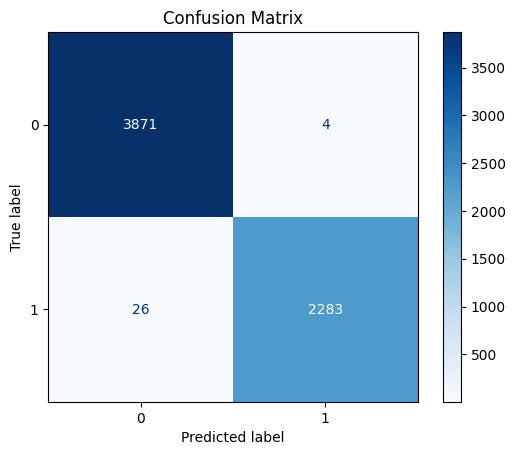

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 17/50, Step 50/773, Loss: 0.0016, Time/batch: 27.56s
Epoch 17/50, Step 100/773, Loss: 0.0001, Time/batch: 27.04s
Epoch 17/50, Step 150/773, Loss: 0.0002, Time/batch: 27.32s
Epoch 17/50, Step 200/773, Loss: 0.0003, Time/batch: 27.02s
Epoch 17/50, Step 250/773, Loss: 0.0001, Time/batch: 27.43s
Epoch 17/50, Step 300/773, Loss: 0.0001, Time/batch: 27.04s
Epoch 17/50, Step 350/773, Loss: 0.0001, Time/batch: 27.29s
Epoch 17/50, Step 400/773, Loss: 0.0002, Time/batch: 27.09s
Epoch 17/50, Step 450/773, Loss: 0.0001, Time/batch: 27.33s
Epoch 17/50, Step 500/773, Loss: 0.0001, Time/batch: 27.09s
Epoch 17/50, Step 550/773, Loss: 0.0001, Time/batch: 27.32s
Epoch 17/50, Step 600/773, Loss: 0.0002, Time/batch: 27.18s
Epoch 17/50, Step 650/773, Loss: 0.0001, Time/batch: 27.40s
Epoch 17/50, Step 700/773, Loss: 0.0000, Time/batch: 27.22s
Epoch 17/50, Step 750/773, Loss: 0.0003, Time/batch: 27.74s
Epoch 17 finished. Average training loss: 0.3618
Precision: 0.9958, Recall: 0.9958, F1-score: 0.9958,

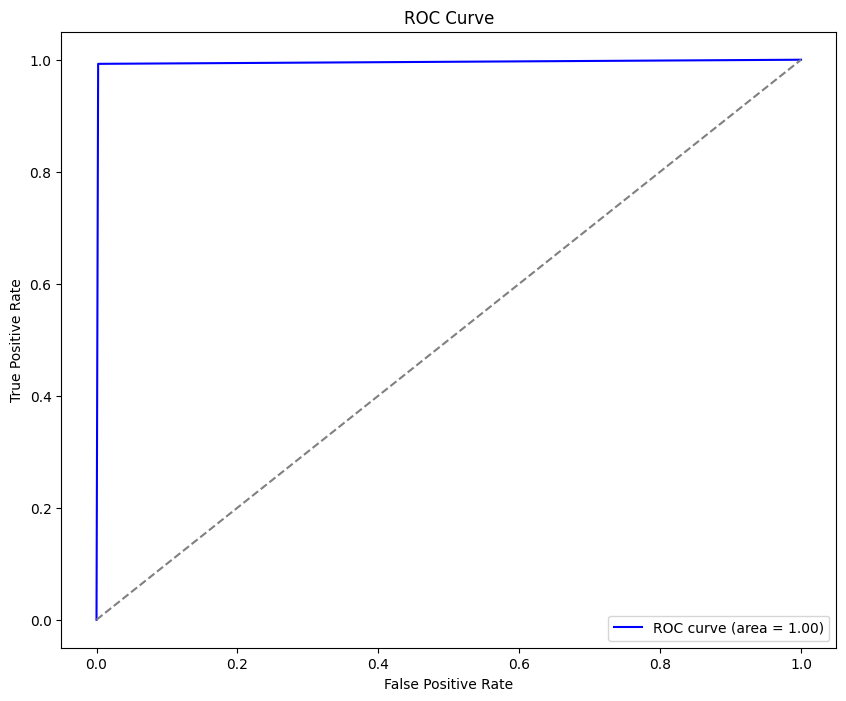

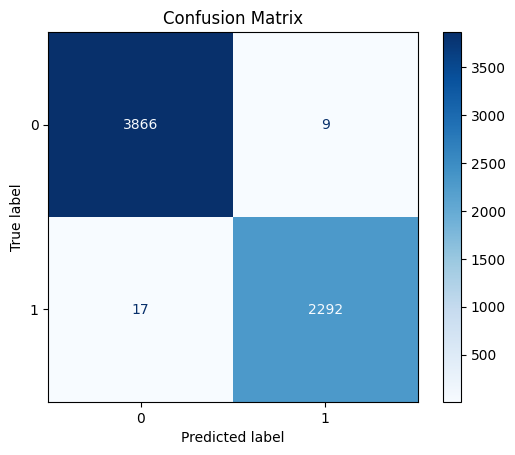

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 18/50, Step 50/773, Loss: 0.0002, Time/batch: 27.43s
Epoch 18/50, Step 100/773, Loss: 0.0003, Time/batch: 27.02s
Epoch 18/50, Step 150/773, Loss: 0.0005, Time/batch: 27.41s
Epoch 18/50, Step 200/773, Loss: 0.0001, Time/batch: 27.11s
Epoch 18/50, Step 250/773, Loss: 0.0000, Time/batch: 27.86s
Epoch 18/50, Step 300/773, Loss: 0.0003, Time/batch: 26.96s
Epoch 18/50, Step 350/773, Loss: 0.0000, Time/batch: 27.33s
Epoch 18/50, Step 400/773, Loss: 0.0001, Time/batch: 27.20s
Epoch 18/50, Step 450/773, Loss: 0.0000, Time/batch: 27.26s
Epoch 18/50, Step 500/773, Loss: 0.0000, Time/batch: 27.48s
Epoch 18/50, Step 550/773, Loss: 0.0000, Time/batch: 27.42s
Epoch 18/50, Step 600/773, Loss: 0.0003, Time/batch: 27.44s
Epoch 18/50, Step 650/773, Loss: 0.0009, Time/batch: 27.06s
Epoch 18/50, Step 700/773, Loss: 0.0001, Time/batch: 27.41s
Epoch 18/50, Step 750/773, Loss: 0.0000, Time/batch: 27.13s
Epoch 18 finished. Average training loss: 0.9677
Precision: 0.9966, Recall: 0.9966, F1-score: 0.9966,

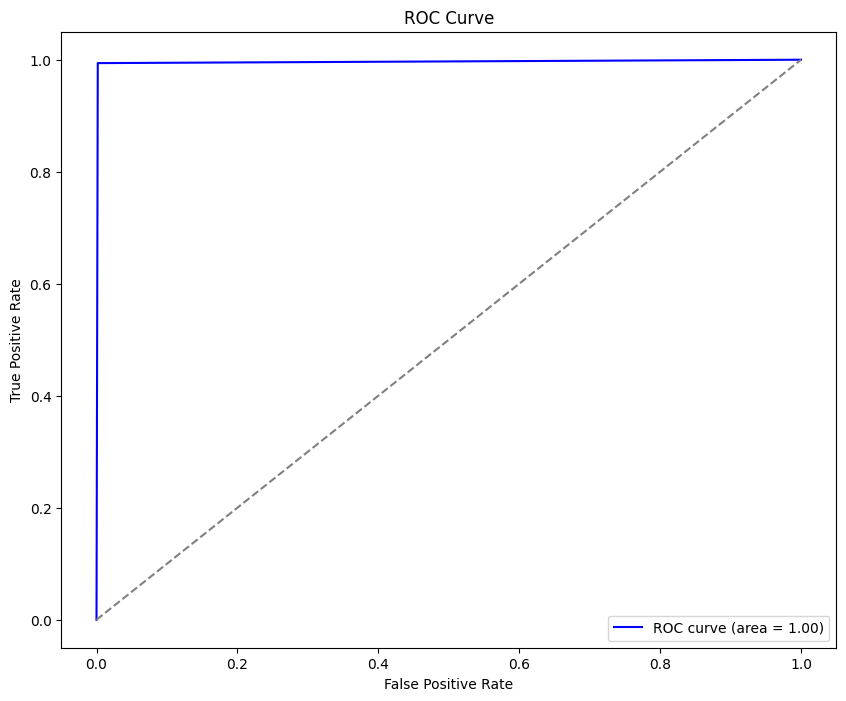

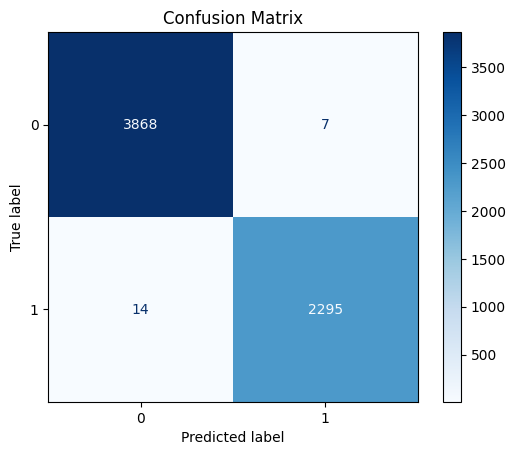

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 19/50, Step 50/773, Loss: 0.0002, Time/batch: 27.02s
Epoch 19/50, Step 100/773, Loss: 0.0001, Time/batch: 27.48s
Epoch 19/50, Step 150/773, Loss: 0.0002, Time/batch: 27.12s
Epoch 19/50, Step 200/773, Loss: 0.0001, Time/batch: 27.53s
Epoch 19/50, Step 250/773, Loss: 0.0003, Time/batch: 27.17s
Epoch 19/50, Step 300/773, Loss: 0.0000, Time/batch: 28.00s
Epoch 19/50, Step 350/773, Loss: 0.0002, Time/batch: 27.03s
Epoch 19/50, Step 400/773, Loss: 0.0002, Time/batch: 27.05s
Epoch 19/50, Step 450/773, Loss: 0.0003, Time/batch: 27.16s
Epoch 19/50, Step 500/773, Loss: 0.0002, Time/batch: 27.37s
Epoch 19/50, Step 550/773, Loss: 0.0004, Time/batch: 27.05s
Epoch 19/50, Step 600/773, Loss: 0.0003, Time/batch: 27.34s
Epoch 19/50, Step 650/773, Loss: 0.0001, Time/batch: 27.02s
Epoch 19/50, Step 700/773, Loss: 0.0003, Time/batch: 27.19s
Epoch 19/50, Step 750/773, Loss: 0.0003, Time/batch: 26.83s
Epoch 19 finished. Average training loss: 19.4043
Precision: 0.9947, Recall: 0.9947, F1-score: 0.9947

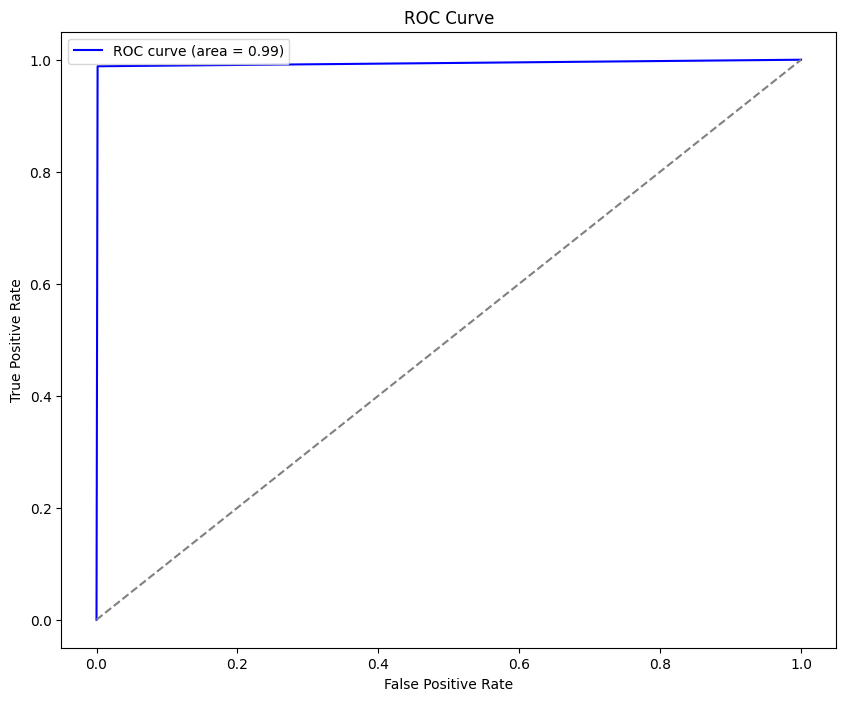

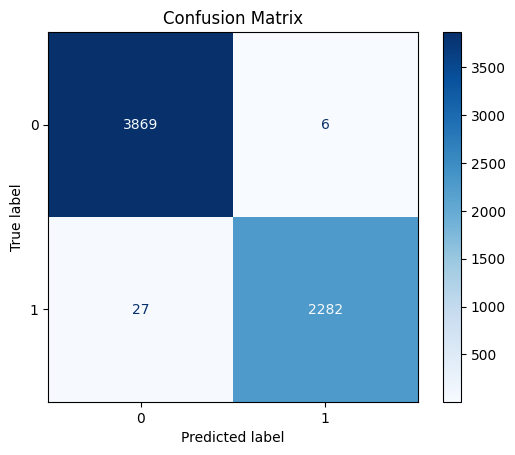

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 20/50, Step 50/773, Loss: 0.0002, Time/batch: 27.09s
Epoch 20/50, Step 100/773, Loss: 0.0001, Time/batch: 27.03s
Epoch 20/50, Step 150/773, Loss: 0.0002, Time/batch: 27.14s
Epoch 20/50, Step 200/773, Loss: 0.1934, Time/batch: 27.32s
Epoch 20/50, Step 250/773, Loss: 0.0003, Time/batch: 27.01s
Epoch 20/50, Step 300/773, Loss: 0.0001, Time/batch: 27.07s
Epoch 20/50, Step 350/773, Loss: 0.0002, Time/batch: 27.30s
Epoch 20/50, Step 400/773, Loss: 0.0001, Time/batch: 26.93s
Epoch 20/50, Step 450/773, Loss: 0.0001, Time/batch: 27.09s
Epoch 20/50, Step 500/773, Loss: 0.0030, Time/batch: 27.00s
Epoch 20/50, Step 550/773, Loss: 5.2705, Time/batch: 27.24s
Epoch 20/50, Step 600/773, Loss: 0.0001, Time/batch: 27.08s
Epoch 20/50, Step 650/773, Loss: 0.0004, Time/batch: 27.27s
Epoch 20/50, Step 700/773, Loss: 0.0003, Time/batch: 26.90s
Epoch 20/50, Step 750/773, Loss: 0.0003, Time/batch: 27.48s
Epoch 20 finished. Average training loss: 430.9211
Precision: 0.9973, Recall: 0.9973, F1-score: 0.997

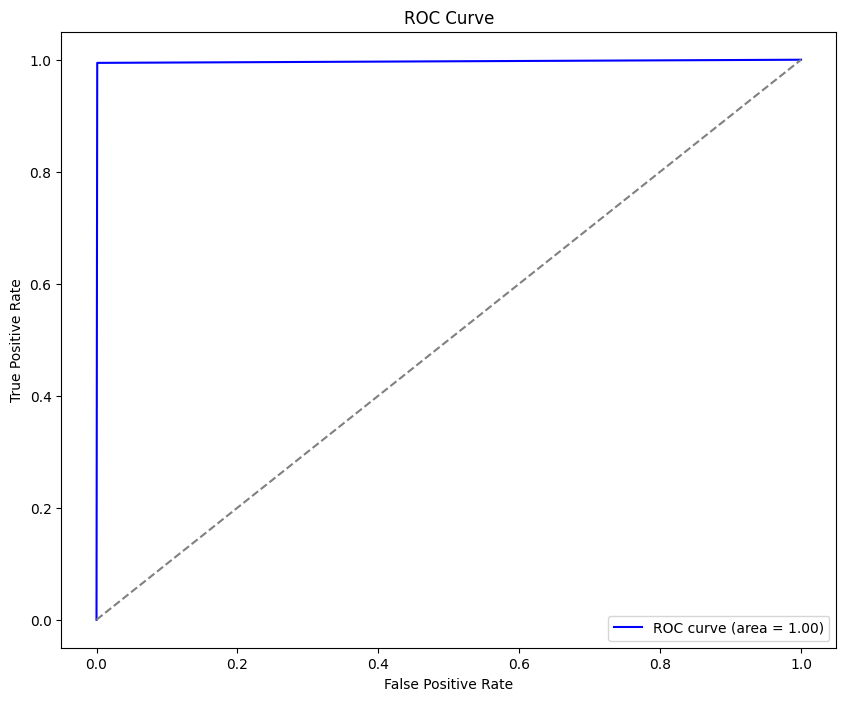

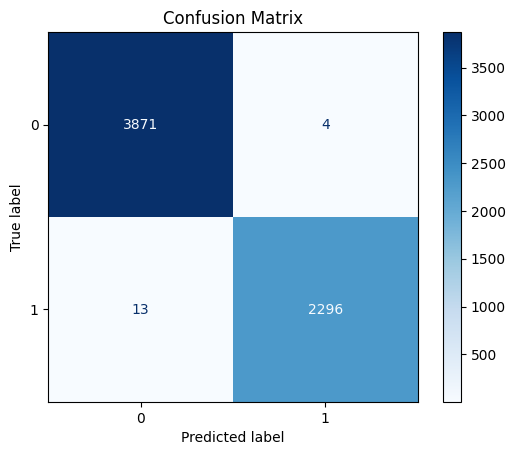

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 21/50, Step 50/773, Loss: 0.0854, Time/batch: 27.33s
Epoch 21/50, Step 100/773, Loss: 0.0001, Time/batch: 26.84s
Epoch 21/50, Step 150/773, Loss: 0.0170, Time/batch: 27.14s
Epoch 21/50, Step 200/773, Loss: 0.5174, Time/batch: 26.83s
Epoch 21/50, Step 250/773, Loss: 0.0003, Time/batch: 27.22s
Epoch 21/50, Step 300/773, Loss: 0.0004, Time/batch: 26.91s
Epoch 21/50, Step 350/773, Loss: 0.0001, Time/batch: 27.51s
Epoch 21/50, Step 400/773, Loss: 0.0001, Time/batch: 26.96s
Epoch 21/50, Step 450/773, Loss: 0.0001, Time/batch: 27.42s
Epoch 21/50, Step 500/773, Loss: 0.0002, Time/batch: 26.93s
Epoch 21/50, Step 550/773, Loss: 0.0003, Time/batch: 26.98s
Epoch 21/50, Step 600/773, Loss: 0.0001, Time/batch: 26.88s
Epoch 21/50, Step 650/773, Loss: 0.0006, Time/batch: 27.20s
Epoch 21/50, Step 700/773, Loss: 0.0002, Time/batch: 27.01s
Epoch 21/50, Step 750/773, Loss: 0.0001, Time/batch: 27.57s
Epoch 21 finished. Average training loss: 1.1829
Precision: 0.9961, Recall: 0.9961, F1-score: 0.9961,

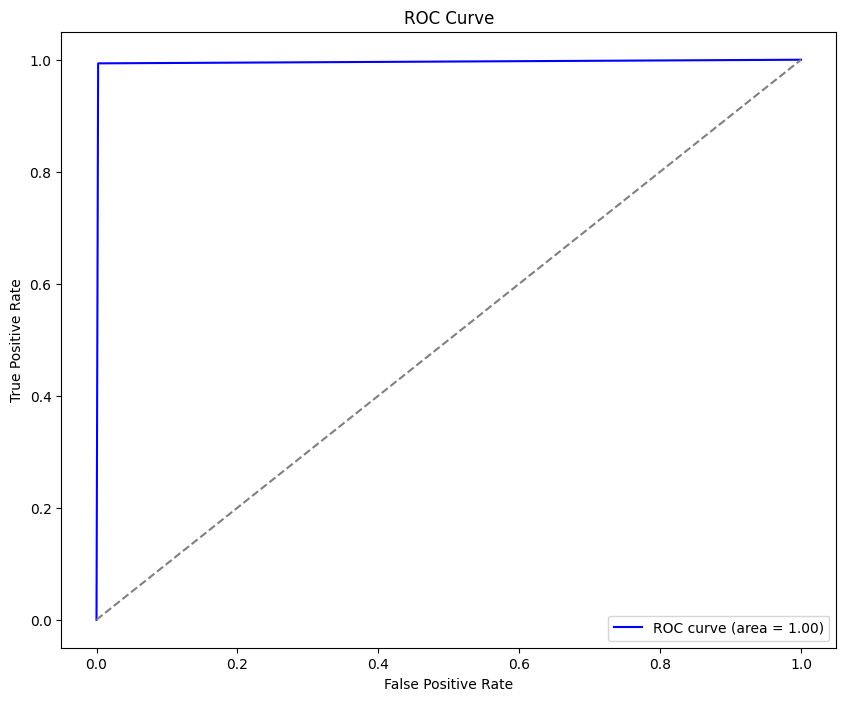

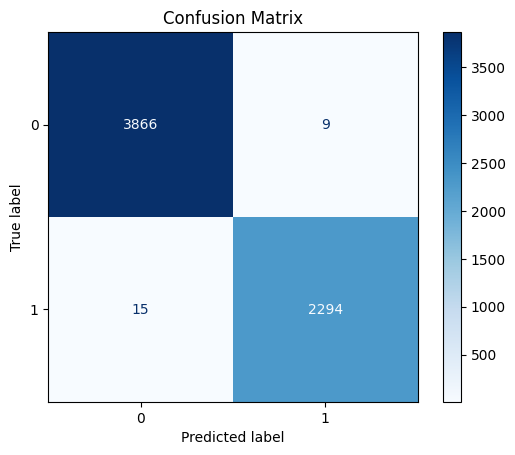

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 22/50, Step 50/773, Loss: 0.0001, Time/batch: 27.04s
Epoch 22/50, Step 100/773, Loss: 0.0001, Time/batch: 27.47s
Epoch 22/50, Step 150/773, Loss: 0.0002, Time/batch: 26.89s
Epoch 22/50, Step 200/773, Loss: 0.0002, Time/batch: 27.21s
Epoch 22/50, Step 250/773, Loss: 0.0007, Time/batch: 26.70s
Epoch 22/50, Step 300/773, Loss: 0.0002, Time/batch: 27.80s
Epoch 22/50, Step 350/773, Loss: 0.0002, Time/batch: 26.92s
Epoch 22/50, Step 400/773, Loss: 0.0001, Time/batch: 27.34s
Epoch 22/50, Step 450/773, Loss: 0.0002, Time/batch: 27.01s
Epoch 22/50, Step 500/773, Loss: 0.0001, Time/batch: 27.09s
Epoch 22/50, Step 550/773, Loss: 0.0000, Time/batch: 26.96s
Epoch 22/50, Step 600/773, Loss: 0.0005, Time/batch: 27.00s
Epoch 22/50, Step 650/773, Loss: 0.0001, Time/batch: 27.06s
Epoch 22/50, Step 700/773, Loss: 0.0011, Time/batch: 27.44s
Epoch 22/50, Step 750/773, Loss: 0.0002, Time/batch: 27.05s
Epoch 22 finished. Average training loss: 0.3602
Precision: 0.9966, Recall: 0.9966, F1-score: 0.9966,

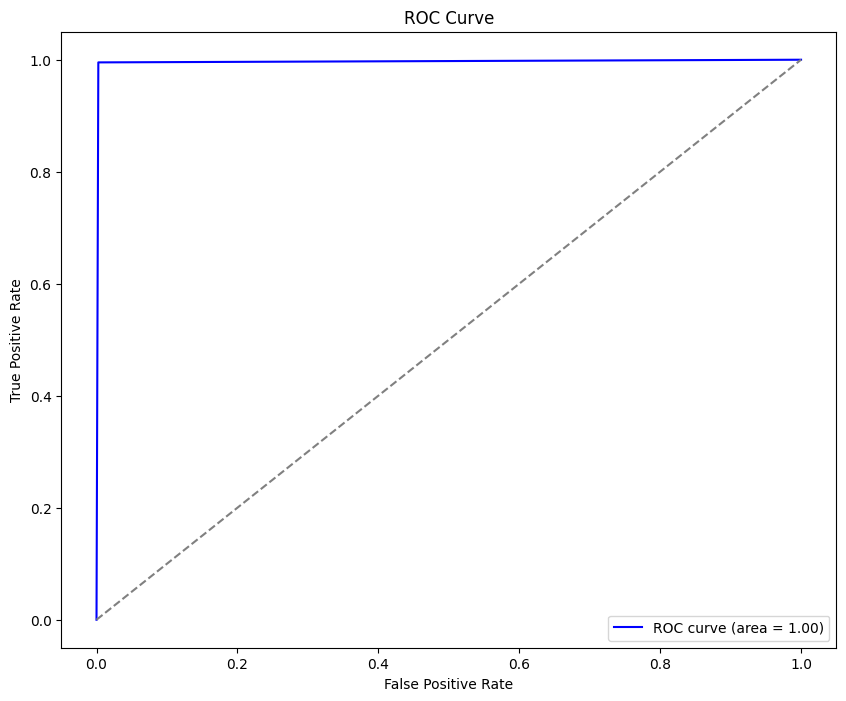

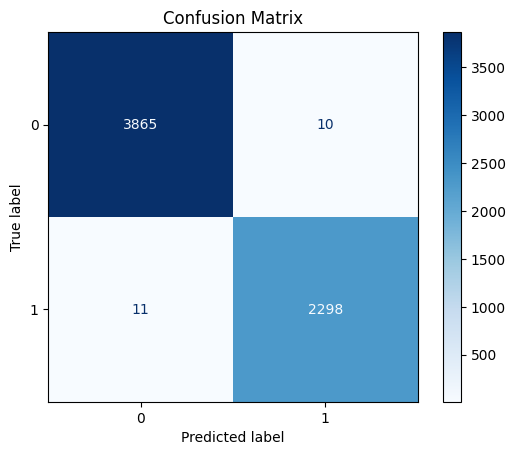

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 23/50, Step 50/773, Loss: 0.0001, Time/batch: 27.02s
Epoch 23/50, Step 100/773, Loss: 0.0001, Time/batch: 27.24s
Epoch 23/50, Step 150/773, Loss: 0.0004, Time/batch: 26.89s
Epoch 23/50, Step 200/773, Loss: 0.0002, Time/batch: 27.34s
Epoch 23/50, Step 250/773, Loss: 0.0005, Time/batch: 26.88s
Epoch 23/50, Step 300/773, Loss: 0.0003, Time/batch: 27.13s
Epoch 23/50, Step 350/773, Loss: 0.0001, Time/batch: 27.03s
Epoch 23/50, Step 400/773, Loss: 0.0003, Time/batch: 27.02s
Epoch 23/50, Step 450/773, Loss: 0.0010, Time/batch: 27.87s
Epoch 23/50, Step 500/773, Loss: 0.0001, Time/batch: 26.98s
Epoch 23/50, Step 550/773, Loss: 0.0001, Time/batch: 27.26s
Epoch 23/50, Step 600/773, Loss: 0.0002, Time/batch: 26.95s
Epoch 23/50, Step 650/773, Loss: 0.0012, Time/batch: 27.05s
Epoch 23/50, Step 700/773, Loss: 26.4291, Time/batch: 26.98s
Epoch 23/50, Step 750/773, Loss: 0.0002, Time/batch: 27.33s
Epoch 23 finished. Average training loss: 3.4977
Precision: 0.9969, Recall: 0.9969, F1-score: 0.9969

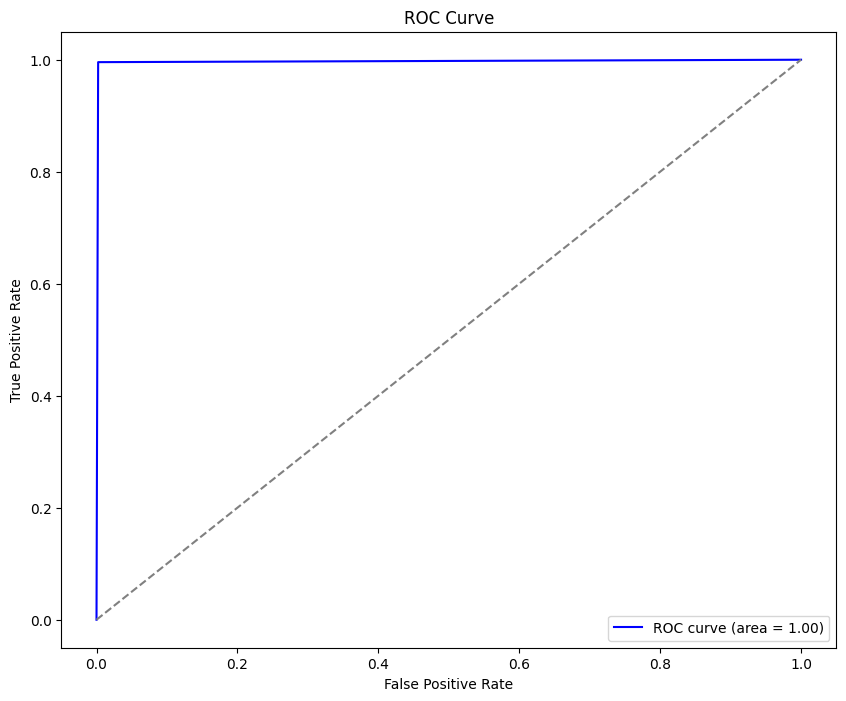

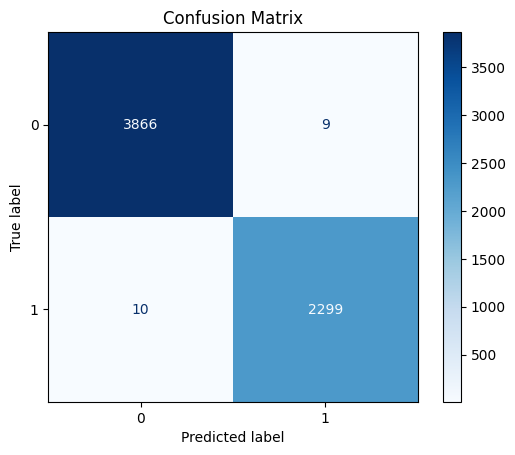

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 24/50, Step 50/773, Loss: 0.0001, Time/batch: 27.77s
Epoch 24/50, Step 100/773, Loss: 0.0001, Time/batch: 27.02s
Epoch 24/50, Step 150/773, Loss: 0.0002, Time/batch: 27.21s
Epoch 24/50, Step 200/773, Loss: 0.0410, Time/batch: 27.00s
Epoch 24/50, Step 250/773, Loss: 0.0001, Time/batch: 27.31s
Epoch 24/50, Step 300/773, Loss: 0.0002, Time/batch: 27.08s
Epoch 24/50, Step 350/773, Loss: 0.0003, Time/batch: 27.01s
Epoch 24/50, Step 400/773, Loss: 0.0001, Time/batch: 27.01s
Epoch 24/50, Step 450/773, Loss: 0.0001, Time/batch: 27.27s
Epoch 24/50, Step 500/773, Loss: 0.0012, Time/batch: 26.92s
Epoch 24/50, Step 550/773, Loss: 0.0002, Time/batch: 27.29s
Epoch 24/50, Step 600/773, Loss: 0.0001, Time/batch: 26.98s
Epoch 24/50, Step 650/773, Loss: 0.0007, Time/batch: 27.35s
Epoch 24/50, Step 700/773, Loss: 0.0006, Time/batch: 26.84s
Epoch 24/50, Step 750/773, Loss: 0.0001, Time/batch: 27.41s
Epoch 24 finished. Average training loss: 0.4934
Precision: 0.9966, Recall: 0.9966, F1-score: 0.9966,

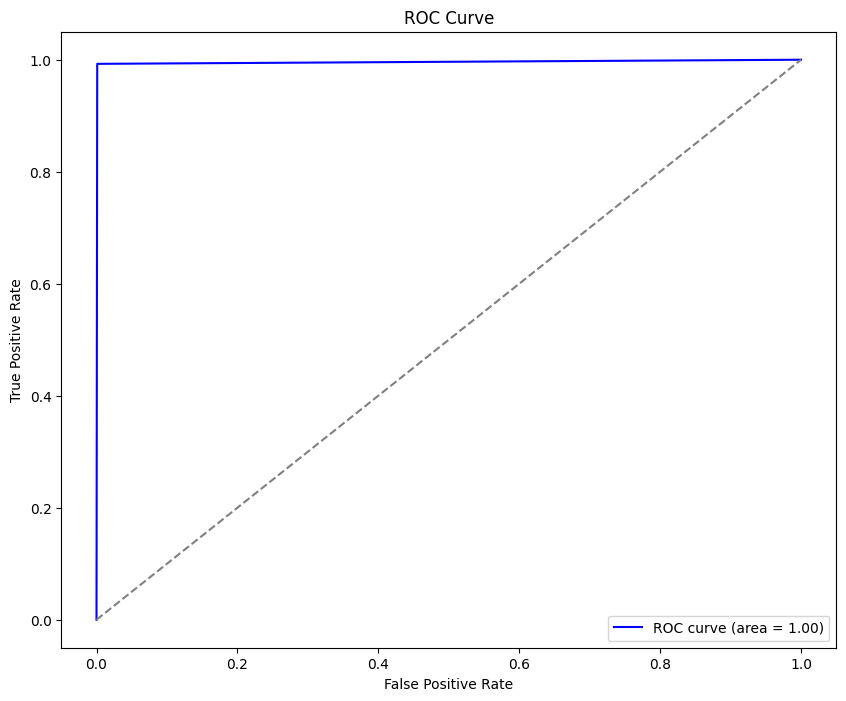

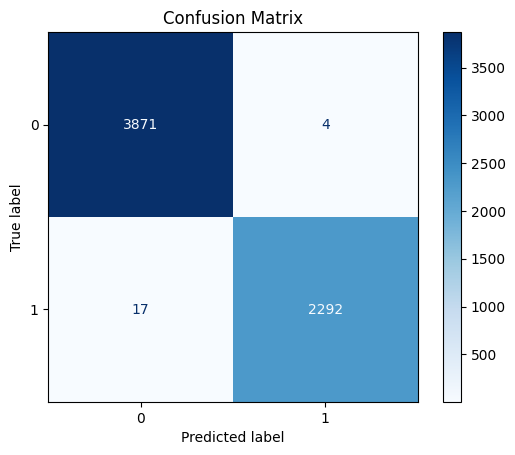

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 25/50, Step 50/773, Loss: 0.0001, Time/batch: 26.87s
Epoch 25/50, Step 100/773, Loss: 0.0000, Time/batch: 27.30s
Epoch 25/50, Step 150/773, Loss: 0.0001, Time/batch: 26.89s
Epoch 25/50, Step 200/773, Loss: 0.0000, Time/batch: 27.19s
Epoch 25/50, Step 250/773, Loss: 0.0001, Time/batch: 27.04s
Epoch 25/50, Step 300/773, Loss: 1.4314, Time/batch: 27.35s
Epoch 25/50, Step 350/773, Loss: 0.0000, Time/batch: 27.06s
Epoch 25/50, Step 400/773, Loss: 0.2519, Time/batch: 27.03s
Epoch 25/50, Step 450/773, Loss: 0.0001, Time/batch: 27.05s
Epoch 25/50, Step 500/773, Loss: 0.0000, Time/batch: 27.46s
Epoch 25/50, Step 550/773, Loss: 0.0002, Time/batch: 27.00s
Epoch 25/50, Step 600/773, Loss: 0.0001, Time/batch: 27.18s
Epoch 25/50, Step 650/773, Loss: 0.0006, Time/batch: 27.17s
Epoch 25/50, Step 700/773, Loss: 0.0041, Time/batch: 27.96s
Epoch 25/50, Step 750/773, Loss: 0.0003, Time/batch: 27.09s
Epoch 25 finished. Average training loss: 0.0946
Precision: 0.9937, Recall: 0.9937, F1-score: 0.9937,

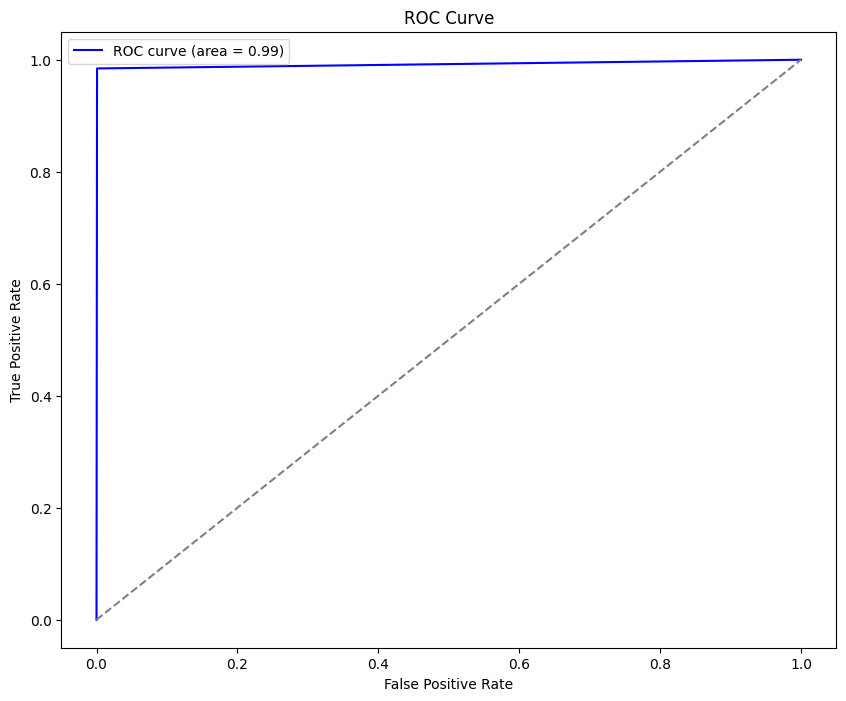

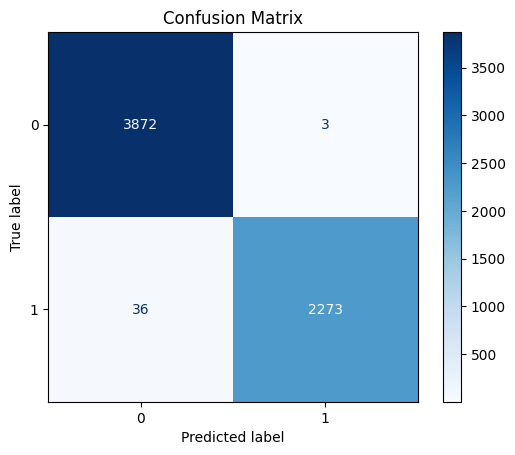

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 26/50, Step 50/773, Loss: 0.0002, Time/batch: 27.11s
Epoch 26/50, Step 100/773, Loss: 0.0002, Time/batch: 27.36s
Epoch 26/50, Step 150/773, Loss: 0.0000, Time/batch: 26.71s
Epoch 26/50, Step 200/773, Loss: 0.0002, Time/batch: 27.47s
Epoch 26/50, Step 250/773, Loss: 0.0001, Time/batch: 27.12s
Epoch 26/50, Step 300/773, Loss: 0.0004, Time/batch: 27.31s
Epoch 26/50, Step 350/773, Loss: 0.1705, Time/batch: 26.92s
Epoch 26/50, Step 400/773, Loss: 0.0002, Time/batch: 27.25s
Epoch 26/50, Step 450/773, Loss: 0.0000, Time/batch: 26.94s
Epoch 26/50, Step 500/773, Loss: 0.0006, Time/batch: 26.88s
Epoch 26/50, Step 550/773, Loss: 0.0001, Time/batch: 26.94s
Epoch 26/50, Step 600/773, Loss: 0.0041, Time/batch: 27.63s
Epoch 26/50, Step 650/773, Loss: 0.0002, Time/batch: 27.10s
Epoch 26/50, Step 700/773, Loss: 0.3797, Time/batch: 26.89s
Epoch 26/50, Step 750/773, Loss: 0.0001, Time/batch: 27.24s
Epoch 26 finished. Average training loss: 4.9691
Precision: 0.9964, Recall: 0.9964, F1-score: 0.9964,

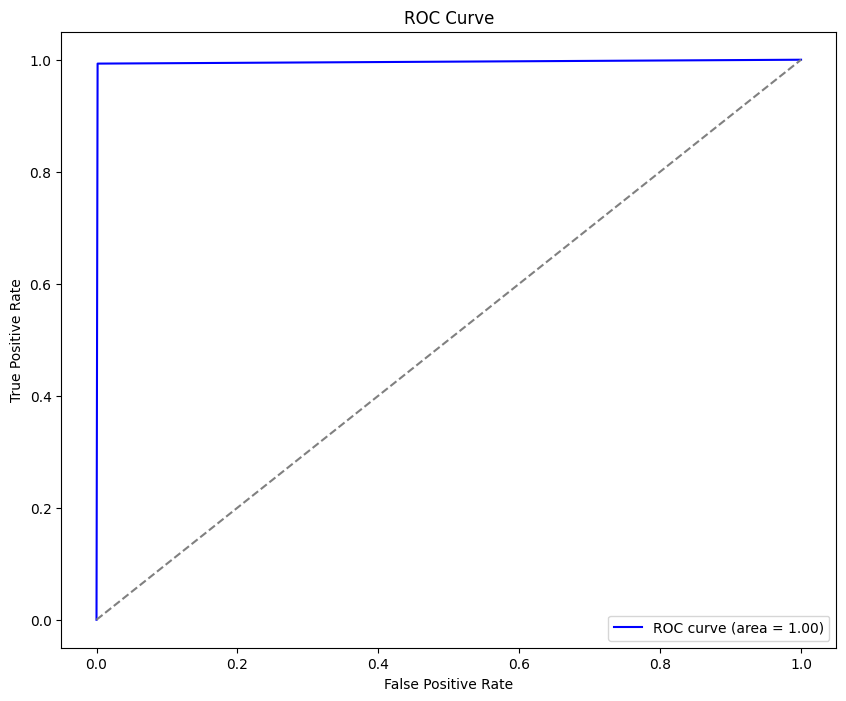

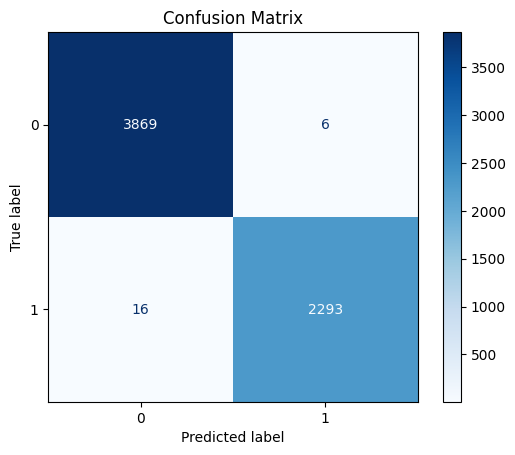

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 27/50, Step 50/773, Loss: 0.0005, Time/batch: 27.41s
Epoch 27/50, Step 100/773, Loss: 0.0001, Time/batch: 26.98s
Epoch 27/50, Step 150/773, Loss: 0.2420, Time/batch: 27.30s
Epoch 27/50, Step 200/773, Loss: 1.2725, Time/batch: 26.73s
Epoch 27/50, Step 250/773, Loss: 0.0000, Time/batch: 27.34s
Epoch 27/50, Step 300/773, Loss: 0.0010, Time/batch: 26.97s
Epoch 27/50, Step 350/773, Loss: 0.0001, Time/batch: 27.36s
Epoch 27/50, Step 400/773, Loss: 0.0002, Time/batch: 26.88s
Epoch 27/50, Step 450/773, Loss: 0.0003, Time/batch: 27.34s
Epoch 27/50, Step 500/773, Loss: 0.0002, Time/batch: 27.42s
Epoch 27/50, Step 550/773, Loss: 0.0001, Time/batch: 27.10s
Epoch 27/50, Step 600/773, Loss: 0.0001, Time/batch: 27.04s
Epoch 27/50, Step 650/773, Loss: 0.0001, Time/batch: 27.38s
Epoch 27/50, Step 700/773, Loss: 0.0004, Time/batch: 27.07s
Epoch 27/50, Step 750/773, Loss: 0.1621, Time/batch: 27.22s
Epoch 27 finished. Average training loss: 5.5726
Precision: 0.9969, Recall: 0.9969, F1-score: 0.9969,

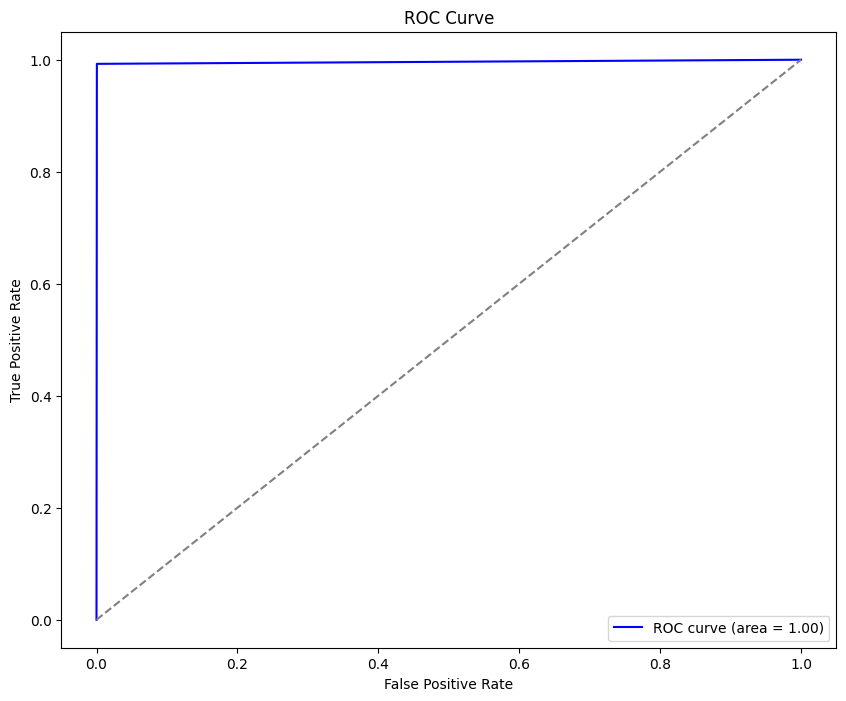

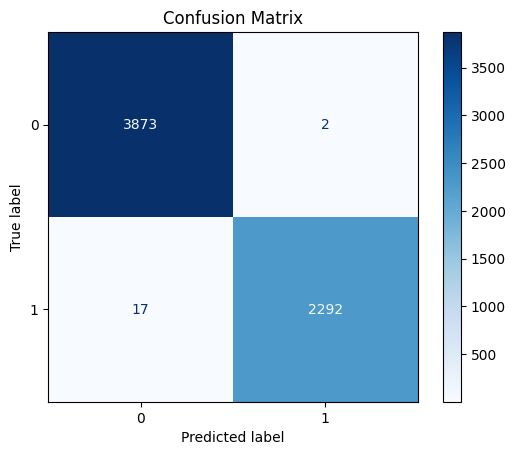

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 28/50, Step 50/773, Loss: 0.0003, Time/batch: 27.53s
Epoch 28/50, Step 100/773, Loss: 0.0002, Time/batch: 27.01s
Epoch 28/50, Step 150/773, Loss: 0.0001, Time/batch: 27.32s
Epoch 28/50, Step 200/773, Loss: 0.0006, Time/batch: 27.02s
Epoch 28/50, Step 250/773, Loss: 0.0002, Time/batch: 26.94s
Epoch 28/50, Step 300/773, Loss: 0.0003, Time/batch: 27.42s
Epoch 28/50, Step 350/773, Loss: 0.0001, Time/batch: 27.03s
Epoch 28/50, Step 400/773, Loss: 0.0003, Time/batch: 27.31s
Epoch 28/50, Step 450/773, Loss: 0.0002, Time/batch: 26.84s
Epoch 28/50, Step 500/773, Loss: 0.0002, Time/batch: 27.41s
Epoch 28/50, Step 550/773, Loss: 0.0001, Time/batch: 27.07s
Epoch 28/50, Step 600/773, Loss: 0.0002, Time/batch: 27.33s
Epoch 28/50, Step 650/773, Loss: 59.8315, Time/batch: 26.86s
Epoch 28/50, Step 700/773, Loss: 0.0002, Time/batch: 27.82s
Epoch 28/50, Step 750/773, Loss: 0.0000, Time/batch: 27.01s
Epoch 28 finished. Average training loss: 0.9961
Precision: 0.9966, Recall: 0.9966, F1-score: 0.9966

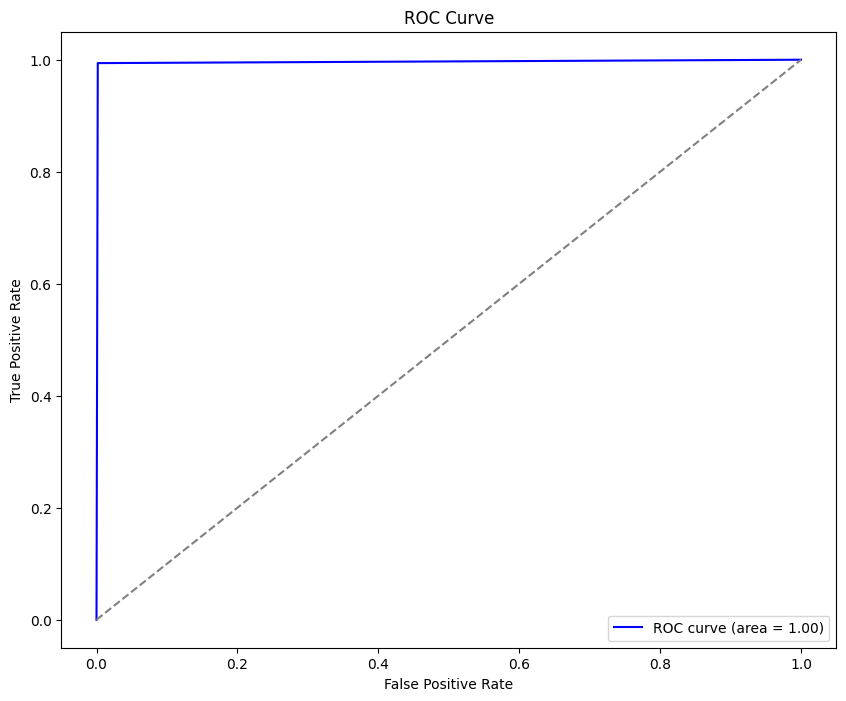

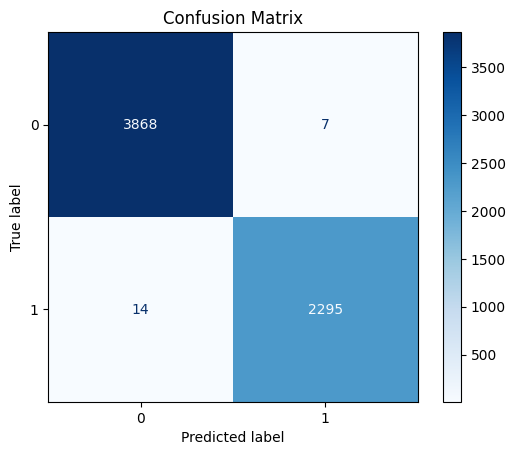

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 29/50, Step 50/773, Loss: 0.0000, Time/batch: 27.05s
Epoch 29/50, Step 100/773, Loss: 0.0262, Time/batch: 27.51s
Epoch 29/50, Step 150/773, Loss: 0.0001, Time/batch: 27.09s
Epoch 29/50, Step 200/773, Loss: 0.0003, Time/batch: 27.25s
Epoch 29/50, Step 250/773, Loss: 0.0002, Time/batch: 26.90s
Epoch 29/50, Step 300/773, Loss: 0.0008, Time/batch: 27.28s
Epoch 29/50, Step 350/773, Loss: 0.0002, Time/batch: 26.80s
Epoch 29/50, Step 400/773, Loss: 0.0002, Time/batch: 27.36s
Epoch 29/50, Step 450/773, Loss: 0.0001, Time/batch: 27.18s
Epoch 29/50, Step 500/773, Loss: 0.0001, Time/batch: 27.50s
Epoch 29/50, Step 550/773, Loss: 0.0008, Time/batch: 27.08s
Epoch 29/50, Step 600/773, Loss: 0.0001, Time/batch: 27.48s
Epoch 29/50, Step 650/773, Loss: 0.0001, Time/batch: 27.01s
Epoch 29/50, Step 700/773, Loss: 0.0001, Time/batch: 27.17s
Epoch 29/50, Step 750/773, Loss: 0.0002, Time/batch: 27.42s
Epoch 29 finished. Average training loss: 1.0236
Precision: 0.9966, Recall: 0.9966, F1-score: 0.9966,

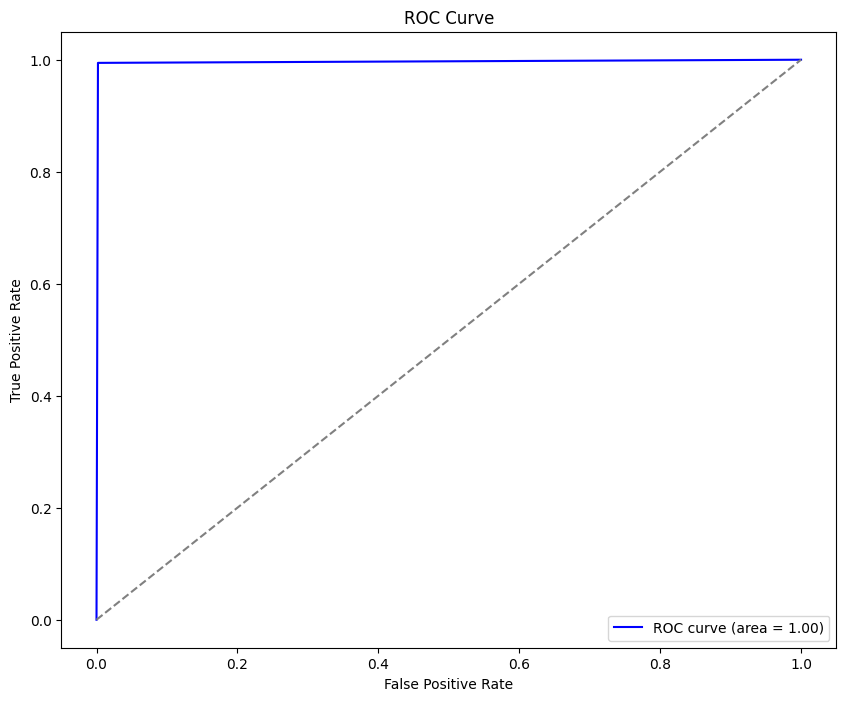

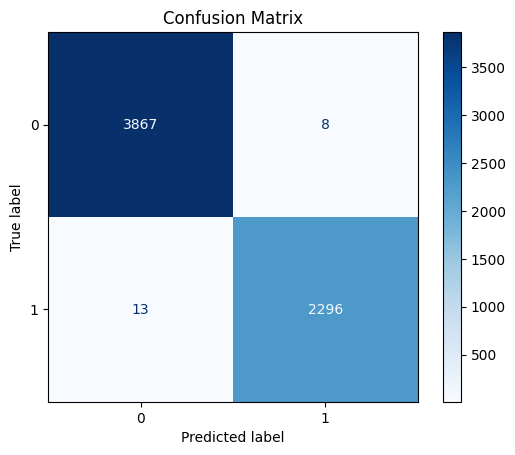

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 30/50, Step 50/773, Loss: 0.2536, Time/batch: 27.16s
Epoch 30/50, Step 100/773, Loss: 0.0002, Time/batch: 27.09s
Epoch 30/50, Step 150/773, Loss: 0.0001, Time/batch: 27.22s
Epoch 30/50, Step 200/773, Loss: 0.0002, Time/batch: 27.08s
Epoch 30/50, Step 250/773, Loss: 0.2370, Time/batch: 27.30s
Epoch 30/50, Step 300/773, Loss: 0.0698, Time/batch: 27.13s
Epoch 30/50, Step 350/773, Loss: 0.0003, Time/batch: 28.12s
Epoch 30/50, Step 400/773, Loss: 0.0006, Time/batch: 27.04s
Epoch 30/50, Step 450/773, Loss: 0.0002, Time/batch: 27.62s
Epoch 30/50, Step 500/773, Loss: 0.0001, Time/batch: 27.21s
Epoch 30/50, Step 550/773, Loss: 0.0007, Time/batch: 27.66s
Epoch 30/50, Step 600/773, Loss: 0.0003, Time/batch: 27.31s
Epoch 30/50, Step 650/773, Loss: 0.0001, Time/batch: 27.45s
Epoch 30/50, Step 700/773, Loss: 0.0007, Time/batch: 27.09s
Epoch 30/50, Step 750/773, Loss: 0.0002, Time/batch: 27.19s
Epoch 30 finished. Average training loss: 0.5452
Precision: 0.9971, Recall: 0.9971, F1-score: 0.9971,

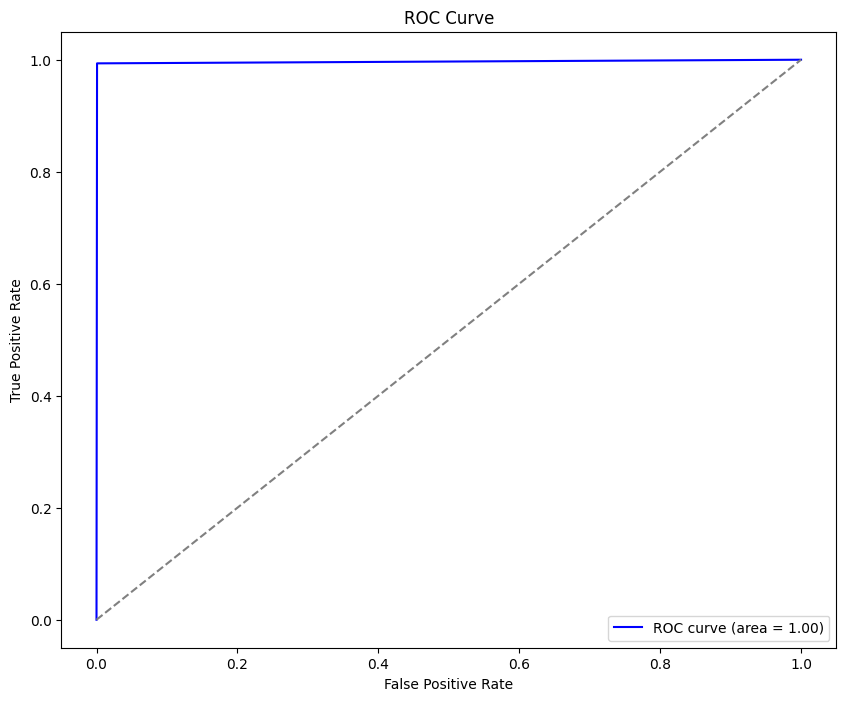

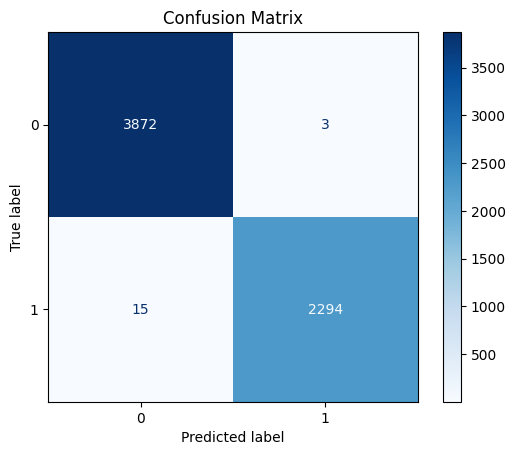

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 31/50, Step 50/773, Loss: 0.0004, Time/batch: 27.53s
Epoch 31/50, Step 100/773, Loss: 0.3189, Time/batch: 27.43s
Epoch 31/50, Step 150/773, Loss: 0.0001, Time/batch: 27.32s
Epoch 31/50, Step 200/773, Loss: 0.0002, Time/batch: 27.20s
Epoch 31/50, Step 250/773, Loss: 0.0005, Time/batch: 27.48s
Epoch 31/50, Step 300/773, Loss: 0.0004, Time/batch: 27.12s
Epoch 31/50, Step 350/773, Loss: 0.0280, Time/batch: 27.41s
Epoch 31/50, Step 400/773, Loss: 0.0002, Time/batch: 26.97s
Epoch 31/50, Step 450/773, Loss: 0.0004, Time/batch: 27.56s
Epoch 31/50, Step 500/773, Loss: 0.0002, Time/batch: 26.97s
Epoch 31/50, Step 550/773, Loss: 0.0001, Time/batch: 26.91s
Epoch 31/50, Step 600/773, Loss: 0.0003, Time/batch: 27.36s
Epoch 31/50, Step 650/773, Loss: 0.0003, Time/batch: 27.03s
Epoch 31/50, Step 700/773, Loss: 0.0001, Time/batch: 27.59s
Epoch 31/50, Step 750/773, Loss: 0.3241, Time/batch: 27.05s
Epoch 31 finished. Average training loss: 6.0075
Precision: 0.9973, Recall: 0.9973, F1-score: 0.9972,

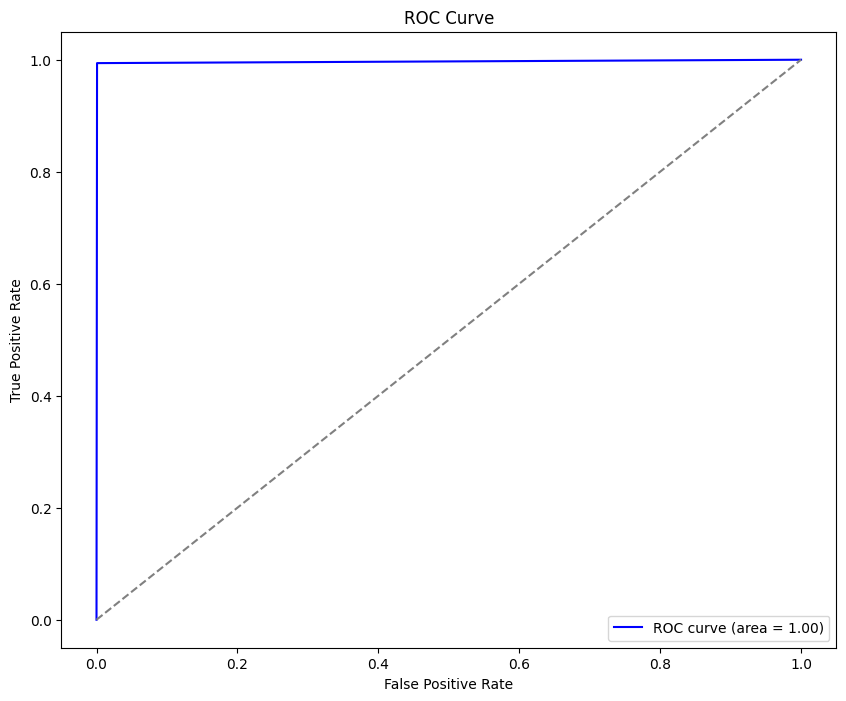

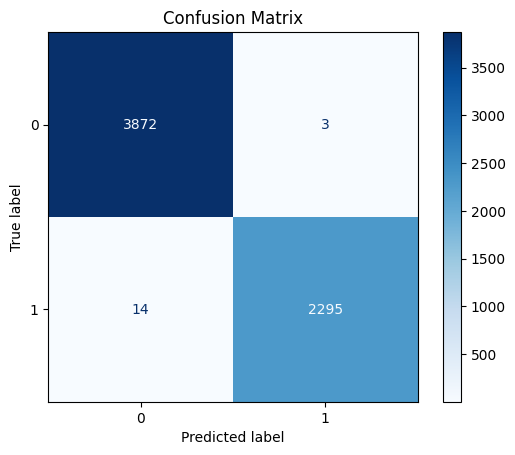

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 32/50, Step 50/773, Loss: 0.0001, Time/batch: 26.97s
Epoch 32/50, Step 100/773, Loss: 0.0001, Time/batch: 27.73s
Epoch 32/50, Step 150/773, Loss: 0.0001, Time/batch: 27.19s
Epoch 32/50, Step 200/773, Loss: 0.0004, Time/batch: 27.34s
Epoch 32/50, Step 250/773, Loss: 0.0002, Time/batch: 27.34s
Epoch 32/50, Step 300/773, Loss: 0.0004, Time/batch: 27.23s
Epoch 32/50, Step 350/773, Loss: 0.0002, Time/batch: 26.99s
Epoch 32/50, Step 400/773, Loss: 0.0002, Time/batch: 27.50s
Epoch 32/50, Step 450/773, Loss: 0.0001, Time/batch: 27.08s
Epoch 32/50, Step 500/773, Loss: 0.0007, Time/batch: 27.35s
Epoch 32/50, Step 550/773, Loss: 0.0001, Time/batch: 27.05s
Epoch 32/50, Step 600/773, Loss: 0.0001, Time/batch: 27.18s
Epoch 32/50, Step 650/773, Loss: 0.0004, Time/batch: 27.08s
Epoch 32/50, Step 700/773, Loss: 0.0001, Time/batch: 27.31s
Epoch 32/50, Step 750/773, Loss: 0.0001, Time/batch: 27.20s
Epoch 32 finished. Average training loss: 0.8134
Precision: 0.9974, Recall: 0.9974, F1-score: 0.9974,

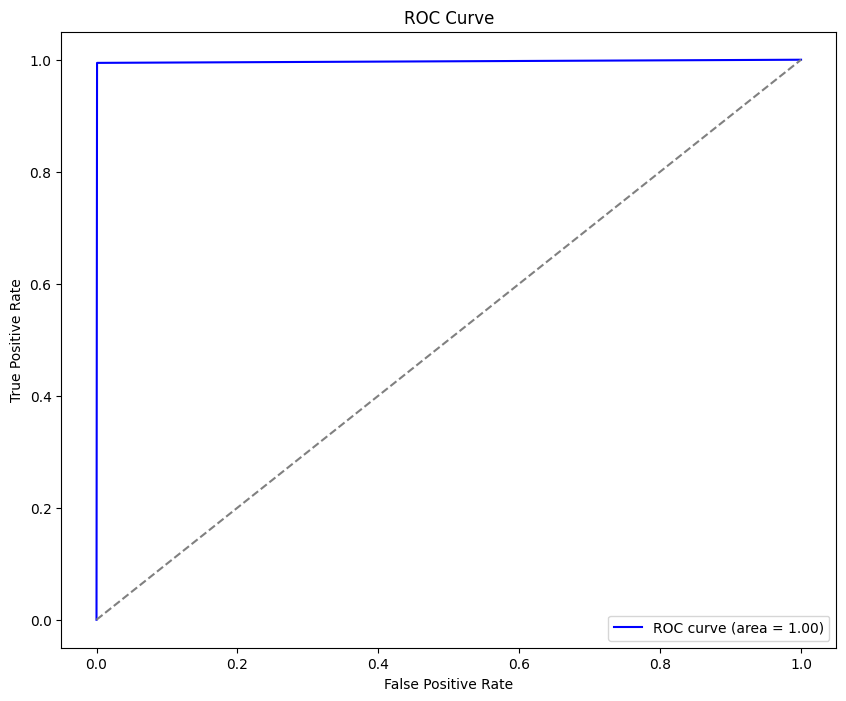

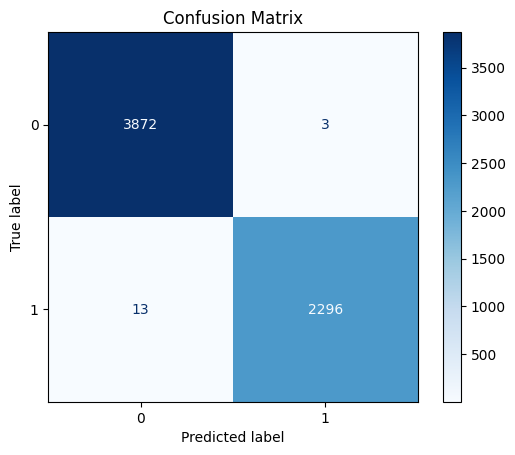

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 33/50, Step 50/773, Loss: 0.0002, Time/batch: 26.96s
Epoch 33/50, Step 100/773, Loss: 0.0001, Time/batch: 27.03s
Epoch 33/50, Step 150/773, Loss: 0.0001, Time/batch: 27.85s
Epoch 33/50, Step 200/773, Loss: 0.0003, Time/batch: 26.99s
Epoch 33/50, Step 250/773, Loss: 0.0003, Time/batch: 27.28s
Epoch 33/50, Step 300/773, Loss: 0.0001, Time/batch: 26.83s
Epoch 33/50, Step 350/773, Loss: 0.0000, Time/batch: 27.27s
Epoch 33/50, Step 400/773, Loss: 0.0001, Time/batch: 26.91s
Epoch 33/50, Step 450/773, Loss: 0.0002, Time/batch: 27.27s
Epoch 33/50, Step 500/773, Loss: 0.2566, Time/batch: 26.88s
Epoch 33/50, Step 550/773, Loss: 0.0001, Time/batch: 27.23s
Epoch 33/50, Step 600/773, Loss: 0.0002, Time/batch: 26.82s
Epoch 33/50, Step 650/773, Loss: 0.0001, Time/batch: 27.14s
Epoch 33/50, Step 700/773, Loss: 0.4879, Time/batch: 26.91s
Epoch 33/50, Step 750/773, Loss: 0.0000, Time/batch: 27.46s
Epoch 33 finished. Average training loss: 0.0995
Precision: 0.9973, Recall: 0.9973, F1-score: 0.9972,

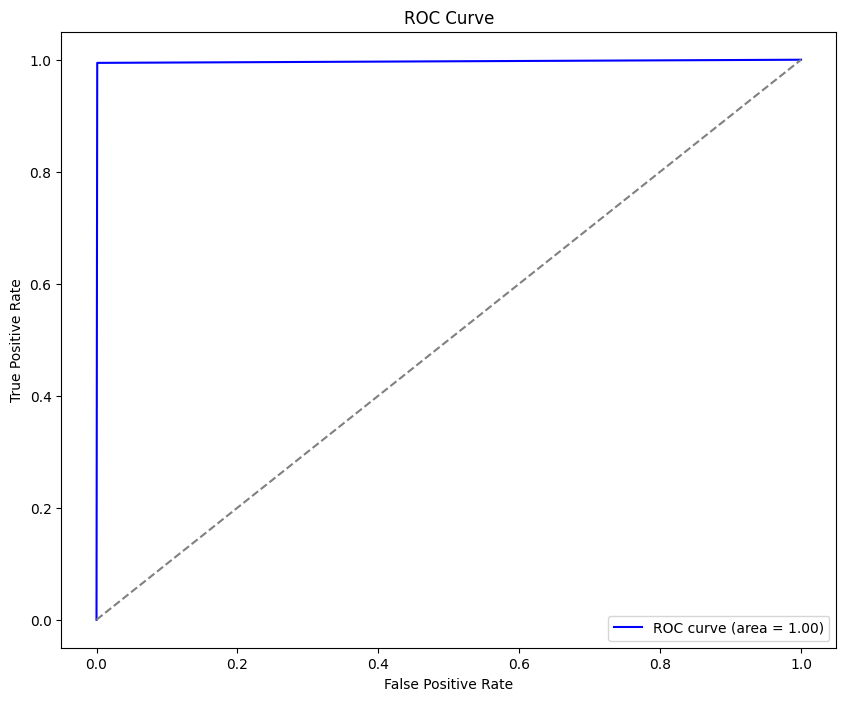

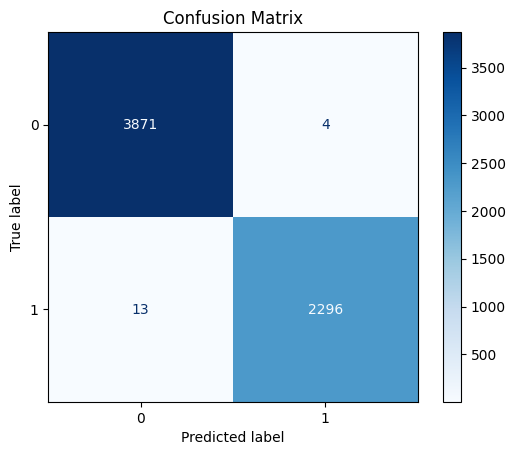

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 34/50, Step 50/773, Loss: 0.0000, Time/batch: 27.21s
Epoch 34/50, Step 100/773, Loss: 0.0000, Time/batch: 26.96s
Epoch 34/50, Step 150/773, Loss: 0.2124, Time/batch: 27.06s
Epoch 34/50, Step 200/773, Loss: 0.0003, Time/batch: 26.93s
Epoch 34/50, Step 250/773, Loss: 0.0003, Time/batch: 27.23s
Epoch 34/50, Step 300/773, Loss: 0.0001, Time/batch: 26.90s
Epoch 34/50, Step 350/773, Loss: 0.0001, Time/batch: 26.81s
Epoch 34/50, Step 400/773, Loss: 0.0002, Time/batch: 27.33s
Epoch 34/50, Step 450/773, Loss: 0.0003, Time/batch: 27.54s
Epoch 34/50, Step 500/773, Loss: 0.0001, Time/batch: 27.09s
Epoch 34/50, Step 550/773, Loss: 0.0001, Time/batch: 27.12s
Epoch 34/50, Step 600/773, Loss: 0.0001, Time/batch: 27.21s
Epoch 34/50, Step 650/773, Loss: 0.0001, Time/batch: 27.29s
Epoch 34/50, Step 700/773, Loss: 0.0000, Time/batch: 27.31s
Epoch 34/50, Step 750/773, Loss: 0.0003, Time/batch: 27.39s
Epoch 34 finished. Average training loss: 0.0395
Precision: 0.9971, Recall: 0.9971, F1-score: 0.9971,

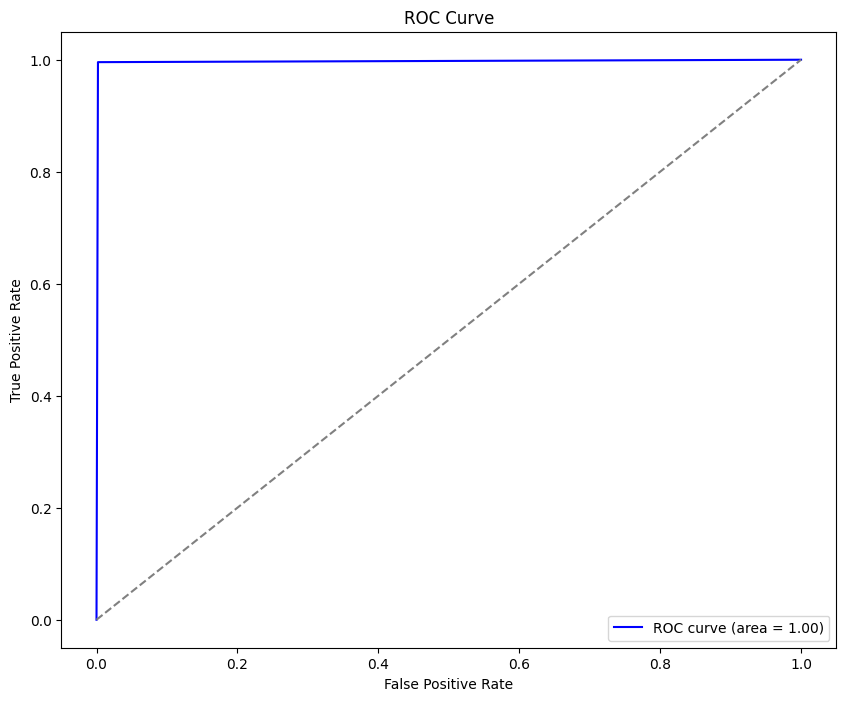

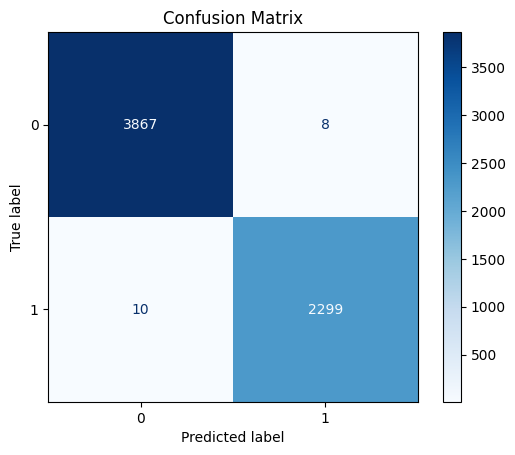

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 35/50, Step 50/773, Loss: 0.0002, Time/batch: 26.79s
Epoch 35/50, Step 100/773, Loss: 0.0001, Time/batch: 27.16s
Epoch 35/50, Step 150/773, Loss: 0.0003, Time/batch: 26.97s
Epoch 35/50, Step 200/773, Loss: 0.0002, Time/batch: 27.23s
Epoch 35/50, Step 250/773, Loss: 0.0001, Time/batch: 26.82s
Epoch 35/50, Step 300/773, Loss: 0.0001, Time/batch: 27.18s
Epoch 35/50, Step 350/773, Loss: 0.0002, Time/batch: 27.29s
Epoch 35/50, Step 400/773, Loss: 0.2702, Time/batch: 27.20s
Epoch 35/50, Step 450/773, Loss: 0.0002, Time/batch: 26.82s
Epoch 35/50, Step 500/773, Loss: 0.0003, Time/batch: 27.36s
Epoch 35/50, Step 550/773, Loss: 0.0001, Time/batch: 26.96s
Epoch 35/50, Step 600/773, Loss: 0.0004, Time/batch: 27.35s
Epoch 35/50, Step 650/773, Loss: 0.0001, Time/batch: 26.93s
Epoch 35/50, Step 700/773, Loss: 0.0001, Time/batch: 27.32s
Epoch 35/50, Step 750/773, Loss: 0.0001, Time/batch: 26.93s
Epoch 35 finished. Average training loss: 0.3612
Precision: 0.9947, Recall: 0.9947, F1-score: 0.9947,

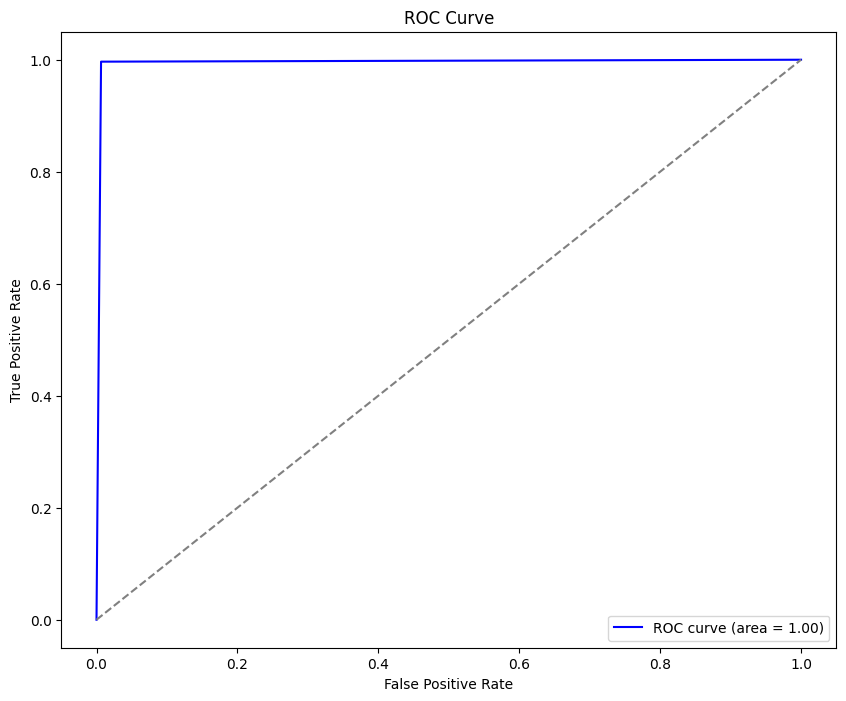

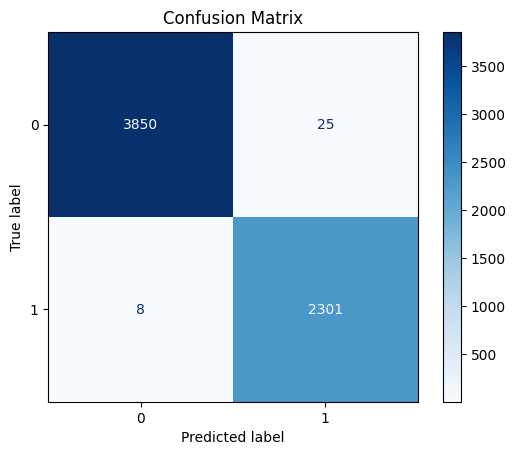

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 36/50, Step 50/773, Loss: 0.0004, Time/batch: 26.90s
Epoch 36/50, Step 100/773, Loss: 0.0002, Time/batch: 26.89s
Epoch 36/50, Step 150/773, Loss: 0.0002, Time/batch: 27.20s
Epoch 36/50, Step 200/773, Loss: 0.0001, Time/batch: 26.97s
Epoch 36/50, Step 250/773, Loss: 0.0001, Time/batch: 27.41s
Epoch 36/50, Step 300/773, Loss: 0.0002, Time/batch: 27.02s
Epoch 36/50, Step 350/773, Loss: 0.0002, Time/batch: 27.55s
Epoch 36/50, Step 400/773, Loss: 0.0002, Time/batch: 27.05s
Epoch 36/50, Step 450/773, Loss: 0.0001, Time/batch: 27.48s
Epoch 36/50, Step 500/773, Loss: 0.0001, Time/batch: 26.99s
Epoch 36/50, Step 550/773, Loss: 0.0002, Time/batch: 27.85s
Epoch 36/50, Step 600/773, Loss: 0.0002, Time/batch: 27.03s
Epoch 36/50, Step 650/773, Loss: 0.0003, Time/batch: 27.87s
Epoch 36/50, Step 700/773, Loss: 0.0002, Time/batch: 27.03s
Epoch 36/50, Step 750/773, Loss: 0.0002, Time/batch: 27.56s
Epoch 36 finished. Average training loss: 3.9265
Precision: 0.9960, Recall: 0.9960, F1-score: 0.9960,

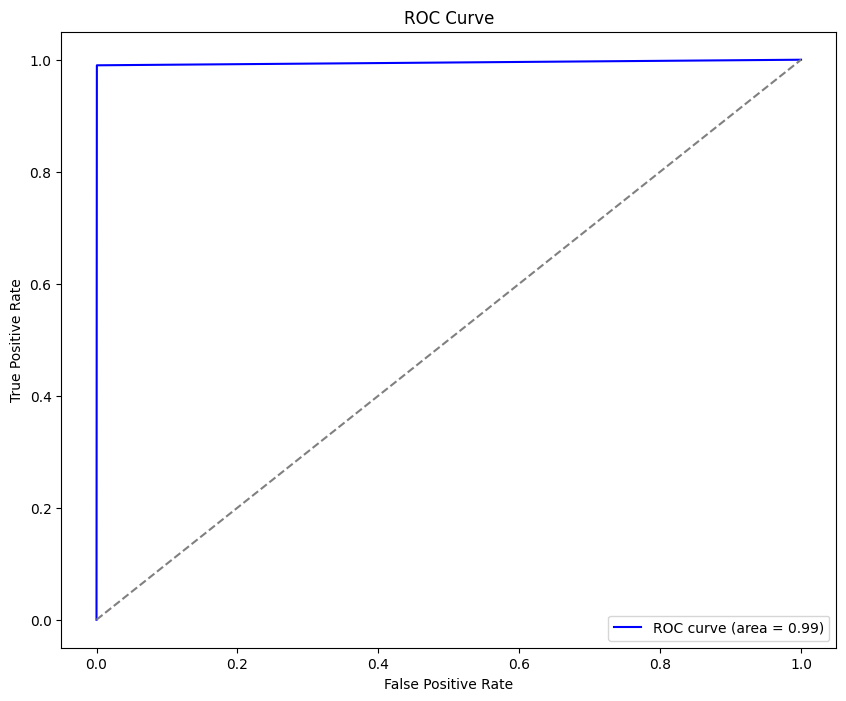

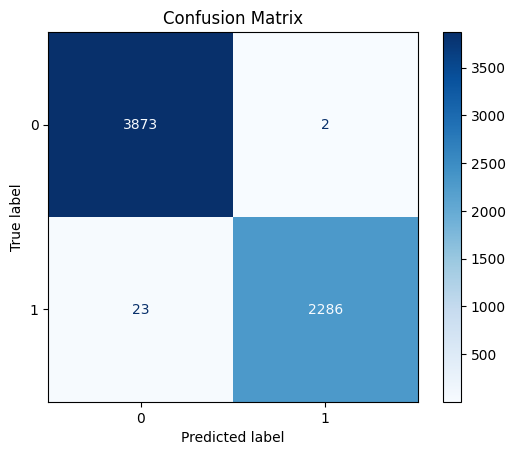

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 37/50, Step 50/773, Loss: 0.0002, Time/batch: 27.47s
Epoch 37/50, Step 100/773, Loss: 0.0002, Time/batch: 27.01s
Epoch 37/50, Step 150/773, Loss: 0.0001, Time/batch: 27.52s
Epoch 37/50, Step 200/773, Loss: 0.0001, Time/batch: 26.94s
Epoch 37/50, Step 250/773, Loss: 0.0001, Time/batch: 27.32s
Epoch 37/50, Step 300/773, Loss: 0.0038, Time/batch: 27.21s
Epoch 37/50, Step 350/773, Loss: 0.0001, Time/batch: 27.35s
Epoch 37/50, Step 400/773, Loss: 0.0001, Time/batch: 27.13s
Epoch 37/50, Step 450/773, Loss: 0.0001, Time/batch: 27.26s
Epoch 37/50, Step 500/773, Loss: 0.0001, Time/batch: 26.95s
Epoch 37/50, Step 550/773, Loss: 0.0001, Time/batch: 27.25s
Epoch 37/50, Step 600/773, Loss: 0.0003, Time/batch: 26.98s
Epoch 37/50, Step 650/773, Loss: 0.0001, Time/batch: 27.17s
Epoch 37/50, Step 700/773, Loss: 0.0001, Time/batch: 26.92s
Epoch 37/50, Step 750/773, Loss: 0.0002, Time/batch: 27.50s
Epoch 37 finished. Average training loss: 0.7121
Precision: 0.9974, Recall: 0.9974, F1-score: 0.9974,

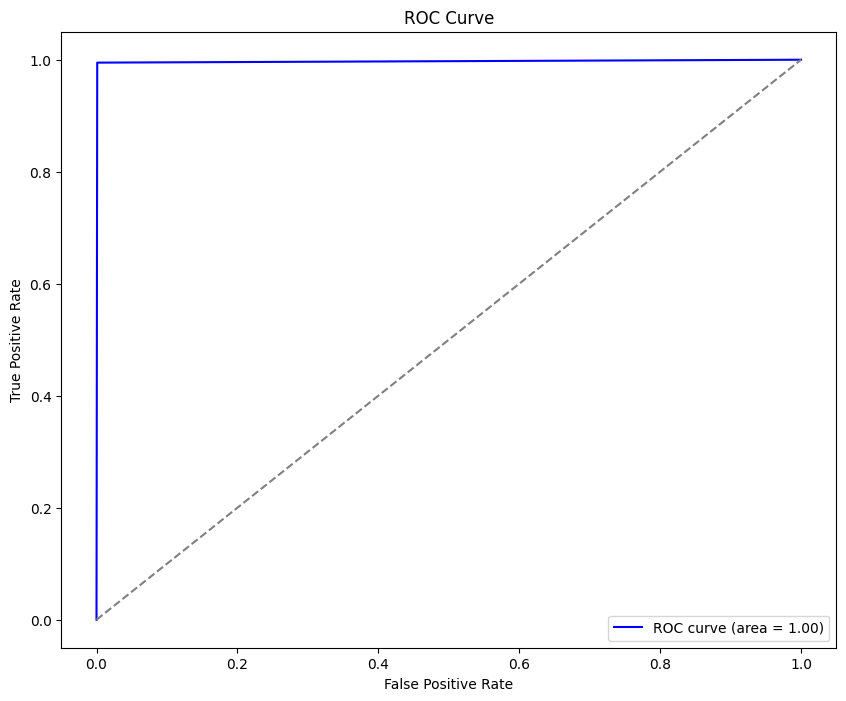

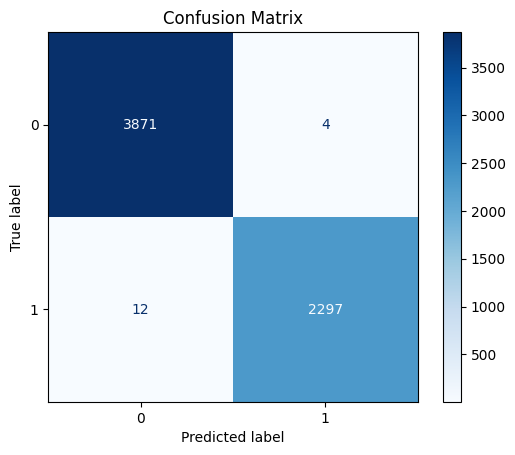

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 38/50, Step 50/773, Loss: 0.0001, Time/batch: 27.25s
Epoch 38/50, Step 100/773, Loss: 0.0001, Time/batch: 27.76s
Epoch 38/50, Step 150/773, Loss: 0.0001, Time/batch: 26.96s
Epoch 38/50, Step 200/773, Loss: 0.0002, Time/batch: 27.36s
Epoch 38/50, Step 250/773, Loss: 0.0002, Time/batch: 27.28s
Epoch 38/50, Step 300/773, Loss: 0.0002, Time/batch: 27.12s
Epoch 38/50, Step 350/773, Loss: 0.0001, Time/batch: 27.05s
Epoch 38/50, Step 400/773, Loss: 0.0001, Time/batch: 27.33s
Epoch 38/50, Step 450/773, Loss: 0.0000, Time/batch: 27.04s
Epoch 38/50, Step 500/773, Loss: 0.0000, Time/batch: 27.47s
Epoch 38/50, Step 550/773, Loss: 0.0000, Time/batch: 27.09s
Epoch 38/50, Step 600/773, Loss: 0.0000, Time/batch: 27.58s
Epoch 38/50, Step 650/773, Loss: 0.0000, Time/batch: 26.96s
Epoch 38/50, Step 700/773, Loss: 0.0002, Time/batch: 27.22s
Epoch 38/50, Step 750/773, Loss: 0.0002, Time/batch: 26.97s
Epoch 38 finished. Average training loss: 0.0135
Precision: 0.9944, Recall: 0.9943, F1-score: 0.9943,

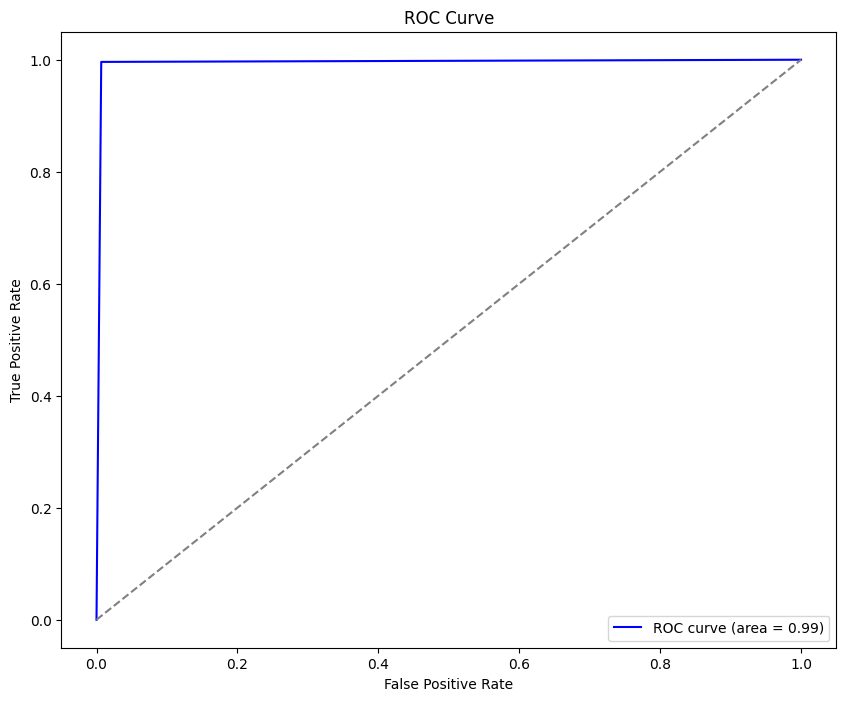

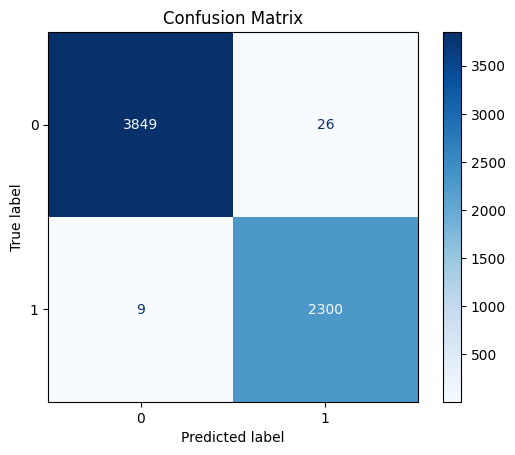

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 39/50, Step 50/773, Loss: 0.0001, Time/batch: 27.31s
Epoch 39/50, Step 100/773, Loss: 0.0000, Time/batch: 27.03s
Epoch 39/50, Step 150/773, Loss: 0.1654, Time/batch: 27.33s
Epoch 39/50, Step 200/773, Loss: 0.0001, Time/batch: 27.02s
Epoch 39/50, Step 250/773, Loss: 0.0000, Time/batch: 27.70s
Epoch 39/50, Step 300/773, Loss: 0.0000, Time/batch: 26.87s
Epoch 39/50, Step 350/773, Loss: 0.0002, Time/batch: 27.25s
Epoch 39/50, Step 400/773, Loss: 0.0002, Time/batch: 26.82s
Epoch 39/50, Step 450/773, Loss: 0.0000, Time/batch: 27.21s
Epoch 39/50, Step 500/773, Loss: 0.0001, Time/batch: 27.01s
Epoch 39/50, Step 550/773, Loss: 0.0000, Time/batch: 27.22s
Epoch 39/50, Step 600/773, Loss: 0.0001, Time/batch: 26.92s
Epoch 39/50, Step 650/773, Loss: 0.0001, Time/batch: 27.27s
Epoch 39/50, Step 700/773, Loss: 0.0001, Time/batch: 26.81s
Epoch 39/50, Step 750/773, Loss: 0.0000, Time/batch: 27.07s
Epoch 39 finished. Average training loss: 0.9814
Precision: 0.9963, Recall: 0.9963, F1-score: 0.9963,

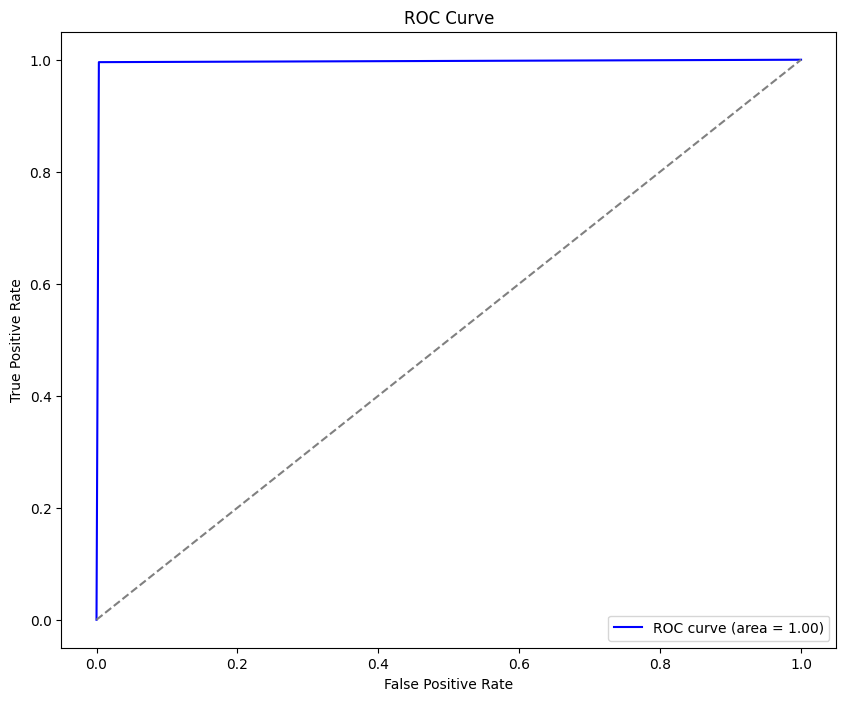

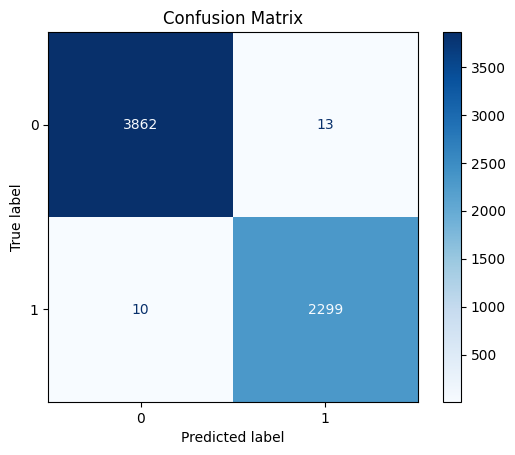

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 40/50, Step 50/773, Loss: 0.0000, Time/batch: 26.94s
Epoch 40/50, Step 100/773, Loss: 0.0001, Time/batch: 27.41s
Epoch 40/50, Step 150/773, Loss: 0.0001, Time/batch: 26.99s
Epoch 40/50, Step 200/773, Loss: 0.0001, Time/batch: 27.81s
Epoch 40/50, Step 250/773, Loss: 0.0000, Time/batch: 26.91s
Epoch 40/50, Step 300/773, Loss: 0.0001, Time/batch: 27.30s
Epoch 40/50, Step 350/773, Loss: 0.3028, Time/batch: 27.12s
Epoch 40/50, Step 400/773, Loss: 0.0001, Time/batch: 27.24s
Epoch 40/50, Step 450/773, Loss: 0.0001, Time/batch: 26.77s
Epoch 40/50, Step 500/773, Loss: 0.0001, Time/batch: 27.27s
Epoch 40/50, Step 550/773, Loss: 0.0001, Time/batch: 26.83s
Epoch 40/50, Step 600/773, Loss: 0.0001, Time/batch: 27.30s
Epoch 40/50, Step 650/773, Loss: 0.0000, Time/batch: 27.02s
Epoch 40/50, Step 700/773, Loss: 0.0001, Time/batch: 27.42s
Epoch 40/50, Step 750/773, Loss: 0.0001, Time/batch: 26.92s
Epoch 40 finished. Average training loss: 1.3023
Precision: 0.9952, Recall: 0.9951, F1-score: 0.9952,

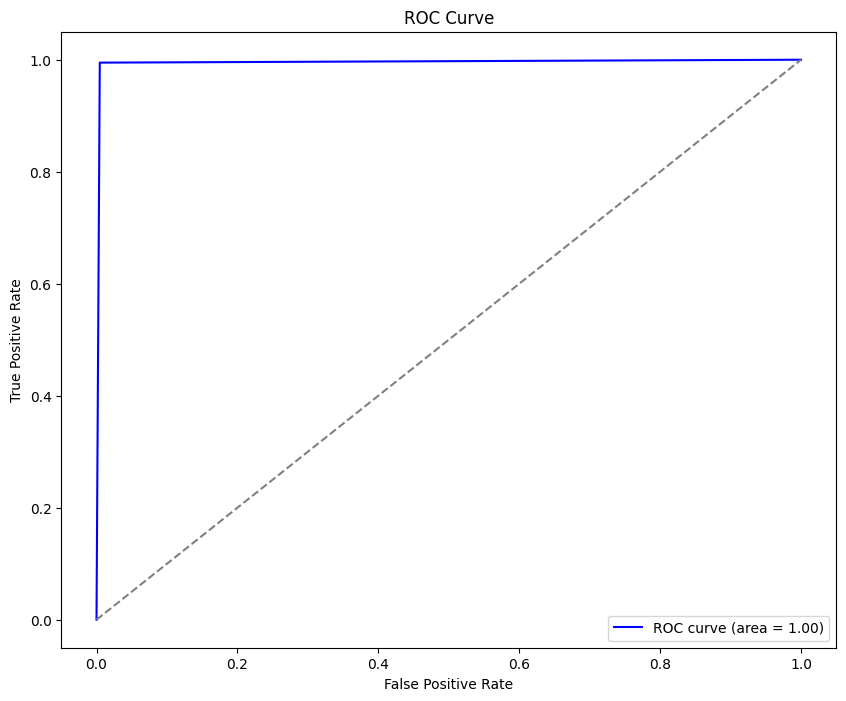

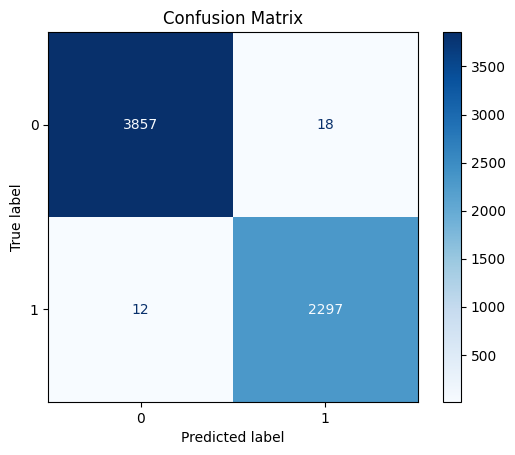

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 41/50, Step 50/773, Loss: 0.0003, Time/batch: 26.96s
Epoch 41/50, Step 100/773, Loss: 0.0002, Time/batch: 27.40s
Epoch 41/50, Step 150/773, Loss: 0.0002, Time/batch: 26.80s
Epoch 41/50, Step 200/773, Loss: 0.0001, Time/batch: 27.01s
Epoch 41/50, Step 250/773, Loss: 0.0001, Time/batch: 27.20s
Epoch 41/50, Step 300/773, Loss: 0.0000, Time/batch: 27.51s
Epoch 41/50, Step 350/773, Loss: 0.0000, Time/batch: 27.14s
Epoch 41/50, Step 400/773, Loss: 0.0001, Time/batch: 27.00s
Epoch 41/50, Step 450/773, Loss: 0.0001, Time/batch: 27.35s
Epoch 41/50, Step 500/773, Loss: 0.0001, Time/batch: 26.78s
Epoch 41/50, Step 550/773, Loss: 0.0002, Time/batch: 27.33s
Epoch 41/50, Step 600/773, Loss: 0.0002, Time/batch: 26.96s
Epoch 41/50, Step 650/773, Loss: 0.0001, Time/batch: 27.22s
Epoch 41/50, Step 700/773, Loss: 0.0001, Time/batch: 27.10s
Epoch 41/50, Step 750/773, Loss: 0.0001, Time/batch: 27.41s
Epoch 41 finished. Average training loss: 3.4149
Precision: 0.9973, Recall: 0.9973, F1-score: 0.9973,

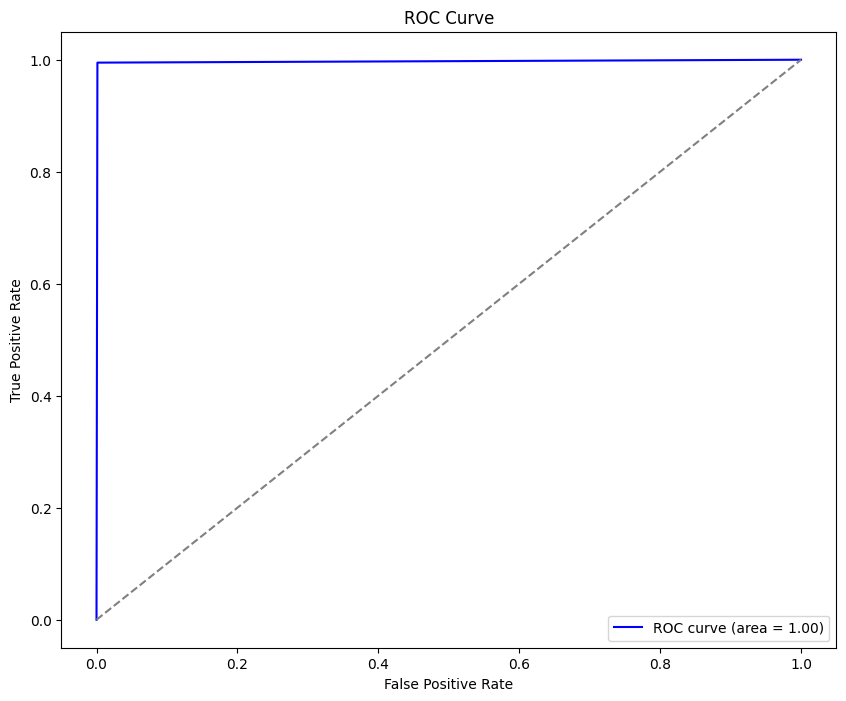

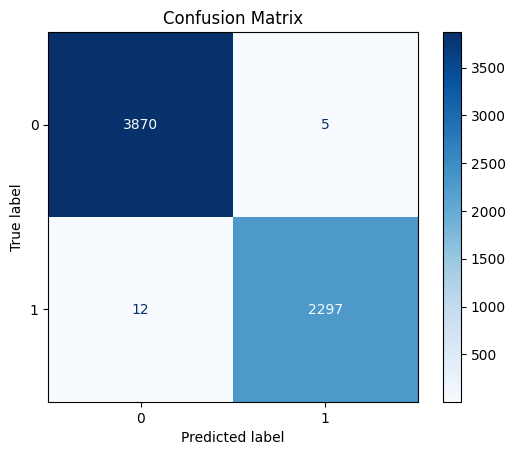

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 42/50, Step 50/773, Loss: 0.0001, Time/batch: 27.42s
Epoch 42/50, Step 100/773, Loss: 0.0000, Time/batch: 26.98s
Epoch 42/50, Step 150/773, Loss: 0.0001, Time/batch: 27.57s
Epoch 42/50, Step 200/773, Loss: 0.0003, Time/batch: 26.94s
Epoch 42/50, Step 250/773, Loss: 0.0001, Time/batch: 27.51s
Epoch 42/50, Step 300/773, Loss: 0.0001, Time/batch: 26.90s
Epoch 42/50, Step 350/773, Loss: 0.0002, Time/batch: 27.85s
Epoch 42/50, Step 400/773, Loss: 0.0001, Time/batch: 27.53s
Epoch 42/50, Step 450/773, Loss: 0.0001, Time/batch: 26.98s
Epoch 42/50, Step 500/773, Loss: 0.0001, Time/batch: 27.49s
Epoch 42/50, Step 550/773, Loss: 0.0004, Time/batch: 27.26s
Epoch 42/50, Step 600/773, Loss: 0.0001, Time/batch: 27.00s
Epoch 42/50, Step 650/773, Loss: 0.0011, Time/batch: 26.87s
Epoch 42/50, Step 700/773, Loss: 0.0000, Time/batch: 27.23s
Epoch 42/50, Step 750/773, Loss: 0.0000, Time/batch: 27.10s
Epoch 42 finished. Average training loss: 0.0256
Precision: 0.9965, Recall: 0.9964, F1-score: 0.9964,

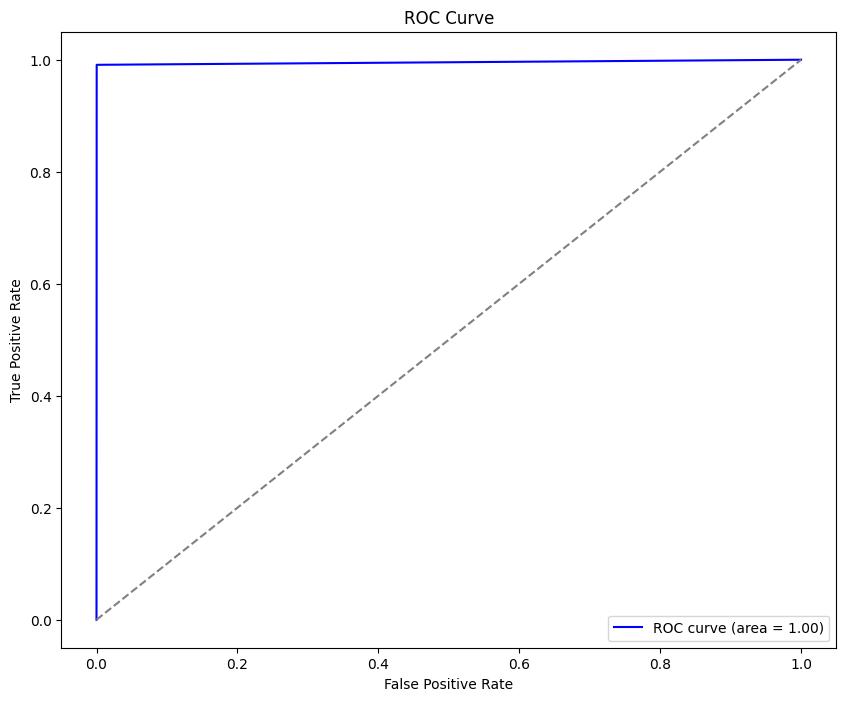

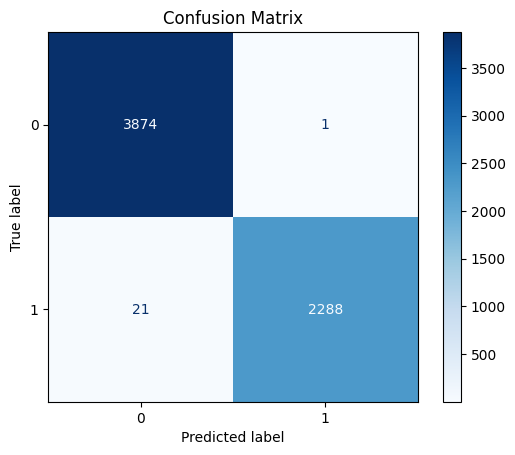

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 43/50, Step 50/773, Loss: 0.0002, Time/batch: 27.09s
Epoch 43/50, Step 100/773, Loss: 0.0002, Time/batch: 27.36s
Epoch 43/50, Step 150/773, Loss: 0.0001, Time/batch: 26.94s
Epoch 43/50, Step 200/773, Loss: 0.0000, Time/batch: 27.33s
Epoch 43/50, Step 250/773, Loss: 0.0000, Time/batch: 26.78s
Epoch 43/50, Step 300/773, Loss: 0.0002, Time/batch: 27.08s
Epoch 43/50, Step 350/773, Loss: 0.0001, Time/batch: 26.88s
Epoch 43/50, Step 400/773, Loss: 0.0001, Time/batch: 27.37s
Epoch 43/50, Step 450/773, Loss: 0.0001, Time/batch: 27.36s
Epoch 43/50, Step 500/773, Loss: 0.0001, Time/batch: 27.62s
Epoch 43/50, Step 550/773, Loss: 0.0001, Time/batch: 26.85s
Epoch 43/50, Step 600/773, Loss: 0.0001, Time/batch: 27.26s
Epoch 43/50, Step 650/773, Loss: 0.0001, Time/batch: 26.65s
Epoch 43/50, Step 700/773, Loss: 0.0002, Time/batch: 27.19s
Epoch 43/50, Step 750/773, Loss: 0.0001, Time/batch: 26.90s
Epoch 43 finished. Average training loss: 0.1189
Precision: 0.9969, Recall: 0.9969, F1-score: 0.9969,

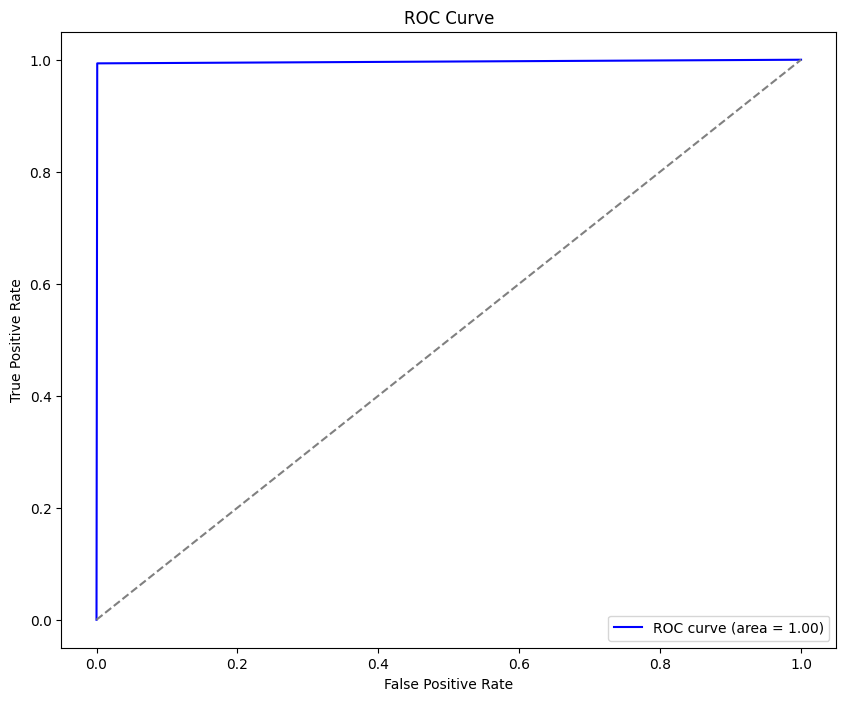

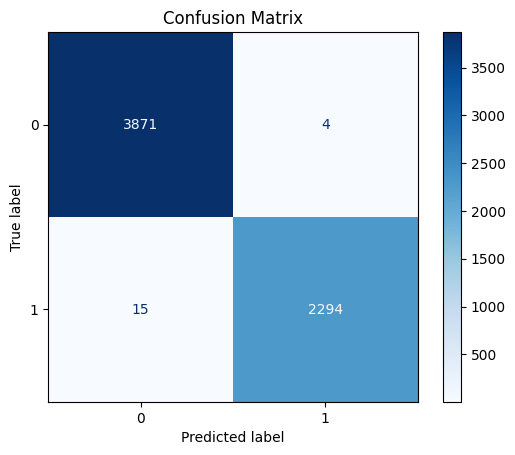

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 44/50, Step 50/773, Loss: 0.0001, Time/batch: 27.45s
Epoch 44/50, Step 100/773, Loss: 0.0001, Time/batch: 26.88s
Epoch 44/50, Step 150/773, Loss: 0.0001, Time/batch: 27.56s
Epoch 44/50, Step 200/773, Loss: 0.0001, Time/batch: 26.79s
Epoch 44/50, Step 250/773, Loss: 0.0001, Time/batch: 27.39s
Epoch 44/50, Step 300/773, Loss: 0.0002, Time/batch: 26.94s
Epoch 44/50, Step 350/773, Loss: 0.0006, Time/batch: 26.99s
Epoch 44/50, Step 400/773, Loss: 0.0002, Time/batch: 27.02s
Epoch 44/50, Step 450/773, Loss: 0.0001, Time/batch: 27.24s
Epoch 44/50, Step 500/773, Loss: 0.0001, Time/batch: 26.95s
Epoch 44/50, Step 550/773, Loss: 0.0001, Time/batch: 27.63s
Epoch 44/50, Step 600/773, Loss: 0.0003, Time/batch: 26.98s
Epoch 44/50, Step 650/773, Loss: 0.0001, Time/batch: 27.24s
Epoch 44/50, Step 700/773, Loss: 0.0001, Time/batch: 26.64s
Epoch 44/50, Step 750/773, Loss: 0.0001, Time/batch: 27.10s
Epoch 44 finished. Average training loss: 0.1101
Precision: 0.9965, Recall: 0.9964, F1-score: 0.9964,

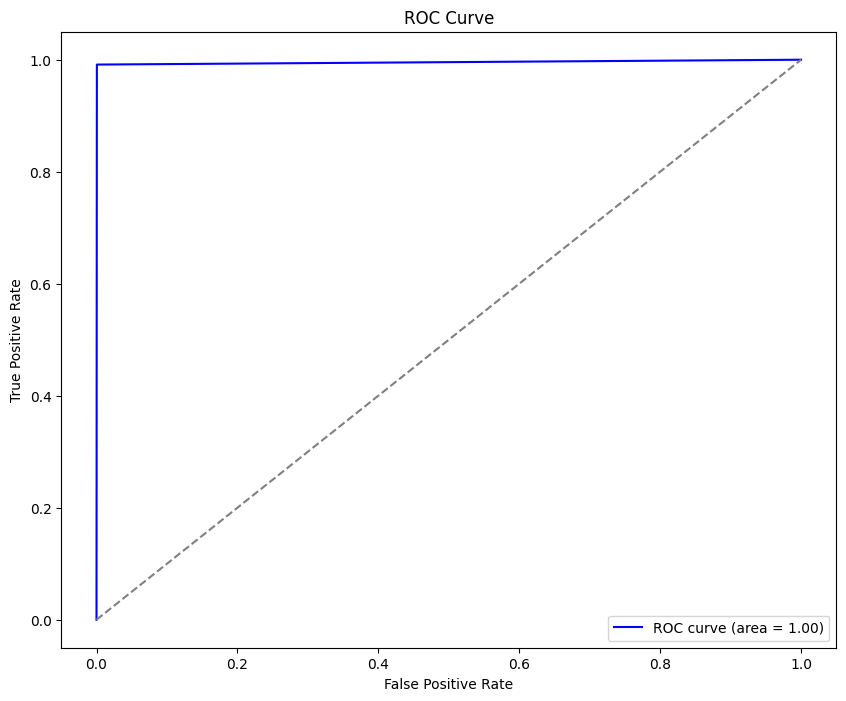

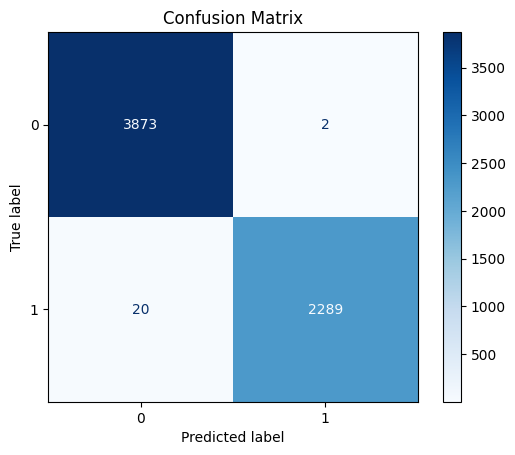

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 45/50, Step 50/773, Loss: 0.0001, Time/batch: 26.63s
Epoch 45/50, Step 100/773, Loss: 0.0001, Time/batch: 27.12s
Epoch 45/50, Step 150/773, Loss: 0.0000, Time/batch: 26.92s
Epoch 45/50, Step 200/773, Loss: 0.0087, Time/batch: 27.22s
Epoch 45/50, Step 250/773, Loss: 0.0000, Time/batch: 26.91s
Epoch 45/50, Step 300/773, Loss: 0.0000, Time/batch: 27.10s
Epoch 45/50, Step 350/773, Loss: 0.0000, Time/batch: 26.80s
Epoch 45/50, Step 400/773, Loss: 0.0001, Time/batch: 26.66s
Epoch 45/50, Step 450/773, Loss: 0.0001, Time/batch: 27.28s
Epoch 45/50, Step 500/773, Loss: 0.0001, Time/batch: 26.94s
Epoch 45/50, Step 550/773, Loss: 0.0001, Time/batch: 27.33s
Epoch 45/50, Step 600/773, Loss: 0.0002, Time/batch: 27.37s
Epoch 45/50, Step 650/773, Loss: 0.0001, Time/batch: 27.12s
Epoch 45/50, Step 700/773, Loss: 0.0001, Time/batch: 26.82s
Epoch 45/50, Step 750/773, Loss: 0.0000, Time/batch: 27.16s
Epoch 45 finished. Average training loss: 0.0868
Precision: 0.9964, Recall: 0.9964, F1-score: 0.9964,

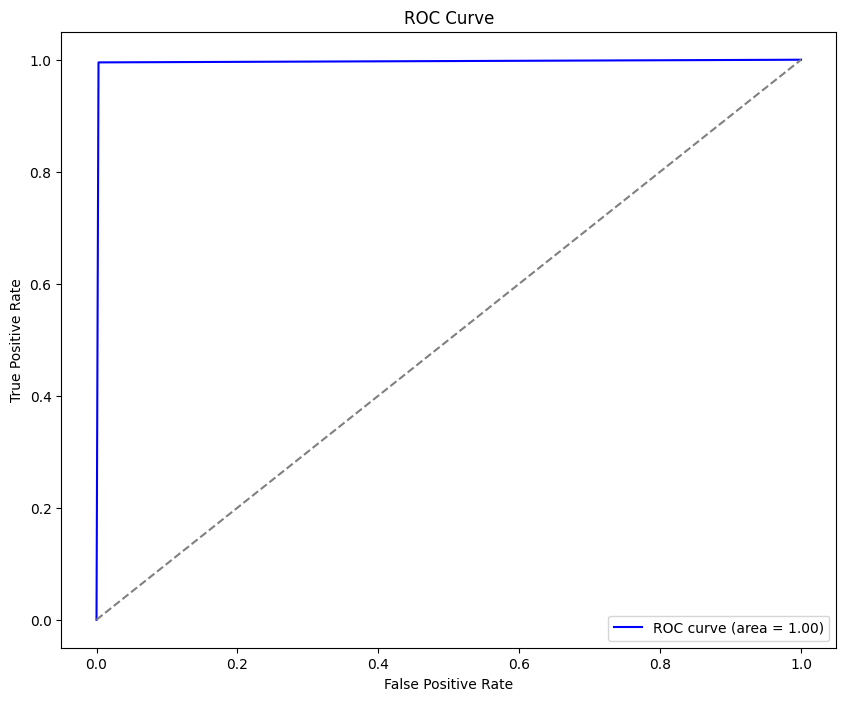

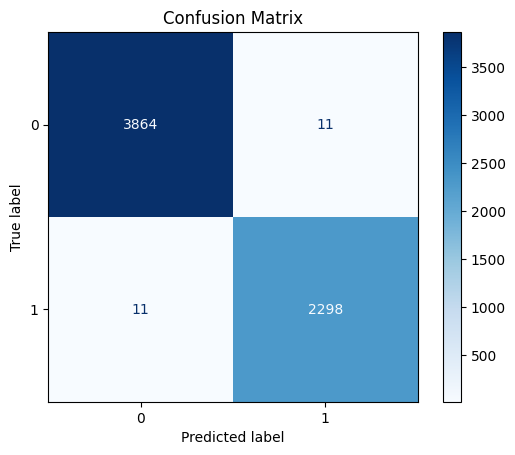

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 46/50, Step 50/773, Loss: 0.0000, Time/batch: 27.29s
Epoch 46/50, Step 100/773, Loss: 0.0000, Time/batch: 26.62s
Epoch 46/50, Step 150/773, Loss: 0.0000, Time/batch: 26.85s
Epoch 46/50, Step 200/773, Loss: 0.0001, Time/batch: 27.16s
Epoch 46/50, Step 250/773, Loss: 0.0000, Time/batch: 26.87s
Epoch 46/50, Step 300/773, Loss: 0.0002, Time/batch: 27.41s
Epoch 46/50, Step 350/773, Loss: 0.0000, Time/batch: 27.09s
Epoch 46/50, Step 400/773, Loss: 0.0000, Time/batch: 27.68s
Epoch 46/50, Step 450/773, Loss: 0.0000, Time/batch: 26.75s
Epoch 46/50, Step 500/773, Loss: 0.0000, Time/batch: 27.33s
Epoch 46/50, Step 550/773, Loss: 0.0000, Time/batch: 26.86s
Epoch 46/50, Step 600/773, Loss: 0.0000, Time/batch: 27.22s
Epoch 46/50, Step 650/773, Loss: 0.0001, Time/batch: 26.84s
Epoch 46/50, Step 700/773, Loss: 0.0002, Time/batch: 27.32s
Epoch 46/50, Step 750/773, Loss: 0.0002, Time/batch: 26.87s
Epoch 46 finished. Average training loss: 1.8001
Precision: 0.9969, Recall: 0.9969, F1-score: 0.9969,

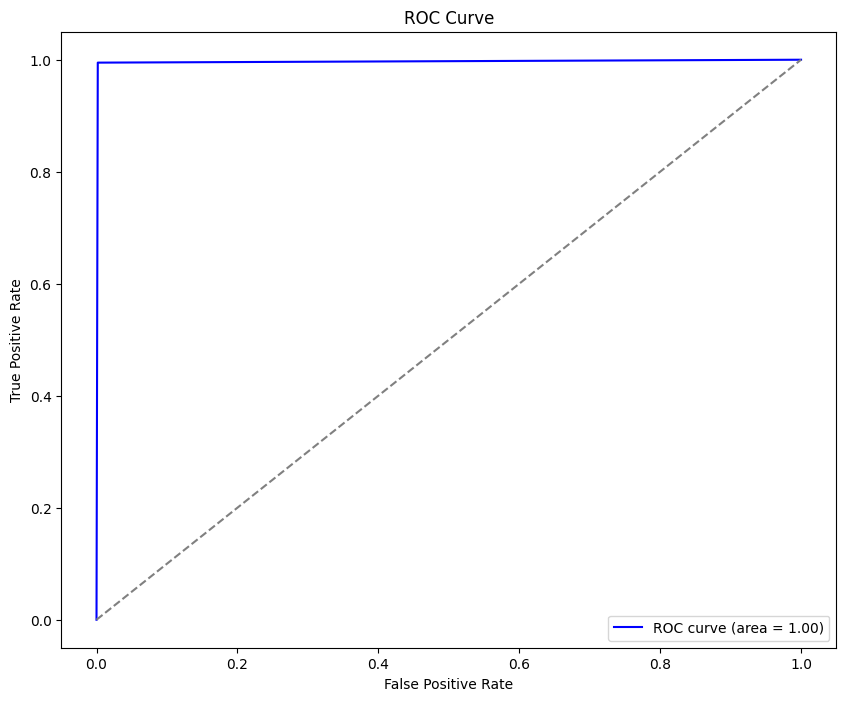

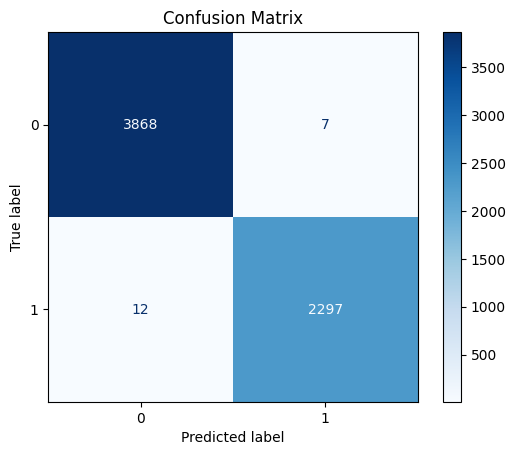

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 47/50, Step 50/773, Loss: 0.0000, Time/batch: 27.07s
Epoch 47/50, Step 100/773, Loss: 0.0000, Time/batch: 27.11s
Epoch 47/50, Step 150/773, Loss: 0.0000, Time/batch: 27.01s
Epoch 47/50, Step 200/773, Loss: 0.0000, Time/batch: 26.98s
Epoch 47/50, Step 250/773, Loss: 0.0001, Time/batch: 27.21s
Epoch 47/50, Step 300/773, Loss: 0.0001, Time/batch: 26.88s
Epoch 47/50, Step 350/773, Loss: 0.1493, Time/batch: 26.97s
Epoch 47/50, Step 400/773, Loss: 0.6716, Time/batch: 26.85s
Epoch 47/50, Step 450/773, Loss: 0.0001, Time/batch: 27.28s
Epoch 47/50, Step 500/773, Loss: 0.0000, Time/batch: 26.68s
Epoch 47/50, Step 550/773, Loss: 0.0000, Time/batch: 27.19s
Epoch 47/50, Step 600/773, Loss: 0.0000, Time/batch: 27.02s
Epoch 47/50, Step 650/773, Loss: 0.0000, Time/batch: 27.48s
Epoch 47/50, Step 700/773, Loss: 0.0000, Time/batch: 26.91s
Epoch 47/50, Step 750/773, Loss: 0.0000, Time/batch: 27.73s
Epoch 47 finished. Average training loss: 0.6892
Precision: 0.9969, Recall: 0.9969, F1-score: 0.9969,

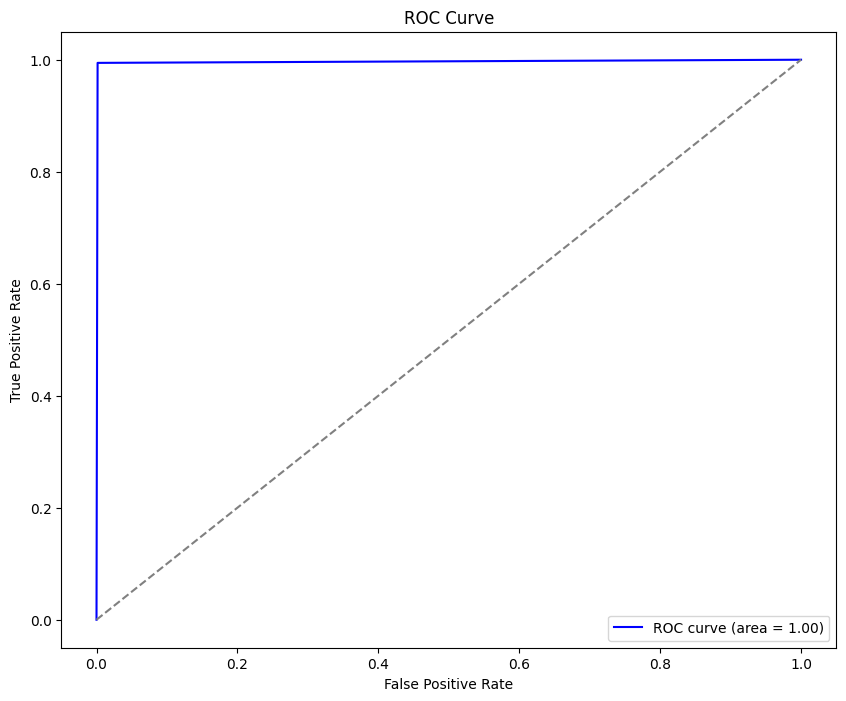

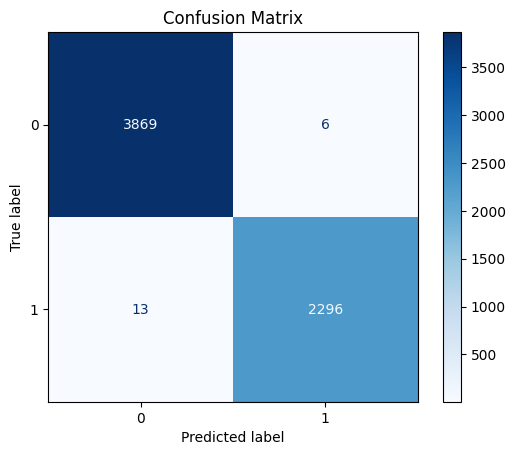

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 48/50, Step 50/773, Loss: 0.0000, Time/batch: 27.38s
Epoch 48/50, Step 100/773, Loss: 0.0000, Time/batch: 27.35s
Epoch 48/50, Step 150/773, Loss: 0.0000, Time/batch: 26.88s
Epoch 48/50, Step 200/773, Loss: 0.0000, Time/batch: 27.03s
Epoch 48/50, Step 250/773, Loss: 0.0004, Time/batch: 26.89s
Epoch 48/50, Step 300/773, Loss: 0.0000, Time/batch: 27.27s
Epoch 48/50, Step 350/773, Loss: 0.0000, Time/batch: 27.12s
Epoch 48/50, Step 400/773, Loss: 0.0000, Time/batch: 27.49s
Epoch 48/50, Step 450/773, Loss: 0.0000, Time/batch: 26.96s
Epoch 48/50, Step 500/773, Loss: 0.0001, Time/batch: 27.09s
Epoch 48/50, Step 550/773, Loss: 0.0002, Time/batch: 26.76s
Epoch 48/50, Step 600/773, Loss: 0.0000, Time/batch: 27.37s
Epoch 48/50, Step 650/773, Loss: 0.0000, Time/batch: 27.05s
Epoch 48/50, Step 700/773, Loss: 0.0000, Time/batch: 27.23s
Epoch 48/50, Step 750/773, Loss: 0.0000, Time/batch: 26.94s
Epoch 48 finished. Average training loss: 0.0159
Precision: 0.9974, Recall: 0.9974, F1-score: 0.9974,

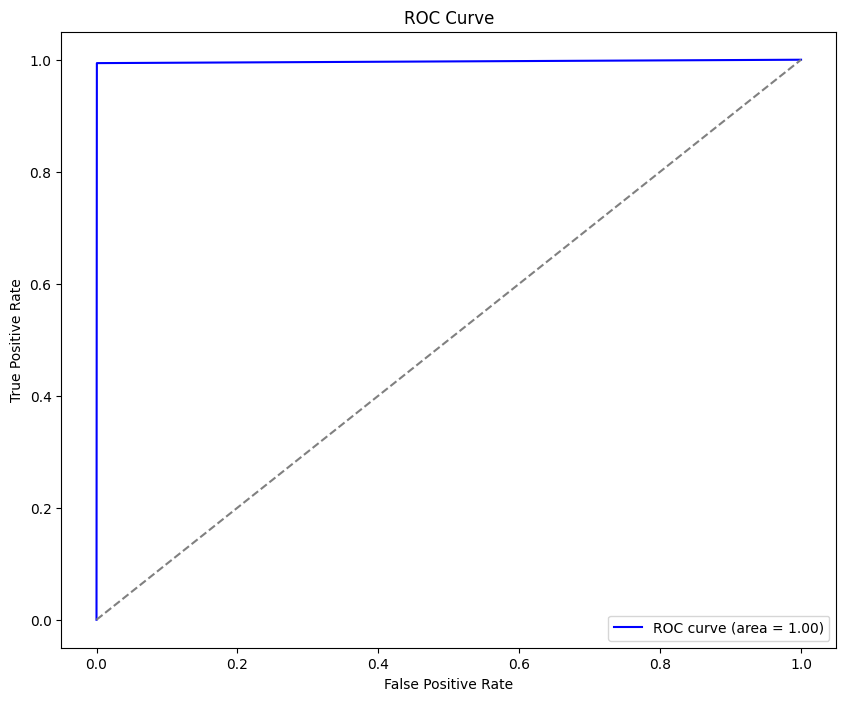

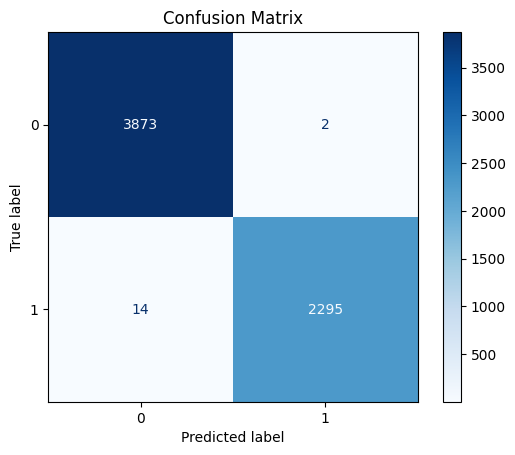

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 49/50, Step 50/773, Loss: 0.0000, Time/batch: 27.32s
Epoch 49/50, Step 100/773, Loss: 0.0000, Time/batch: 26.91s
Epoch 49/50, Step 150/773, Loss: 0.0001, Time/batch: 27.56s
Epoch 49/50, Step 200/773, Loss: 0.0002, Time/batch: 27.15s
Epoch 49/50, Step 250/773, Loss: 0.0001, Time/batch: 27.08s
Epoch 49/50, Step 300/773, Loss: 0.0001, Time/batch: 26.99s
Epoch 49/50, Step 350/773, Loss: 0.0001, Time/batch: 27.68s
Epoch 49/50, Step 400/773, Loss: 0.0004, Time/batch: 27.33s
Epoch 49/50, Step 450/773, Loss: 0.0000, Time/batch: 27.20s
Epoch 49/50, Step 500/773, Loss: 0.0001, Time/batch: 27.00s
Epoch 49/50, Step 550/773, Loss: 0.0000, Time/batch: 27.38s
Epoch 49/50, Step 600/773, Loss: 0.0000, Time/batch: 26.63s
Epoch 49/50, Step 650/773, Loss: 0.0000, Time/batch: 27.77s
Epoch 49/50, Step 700/773, Loss: 0.0001, Time/batch: 27.11s
Epoch 49/50, Step 750/773, Loss: 0.0001, Time/batch: 27.31s
Epoch 49 finished. Average training loss: 3.7833
Precision: 0.9953, Recall: 0.9953, F1-score: 0.9953,

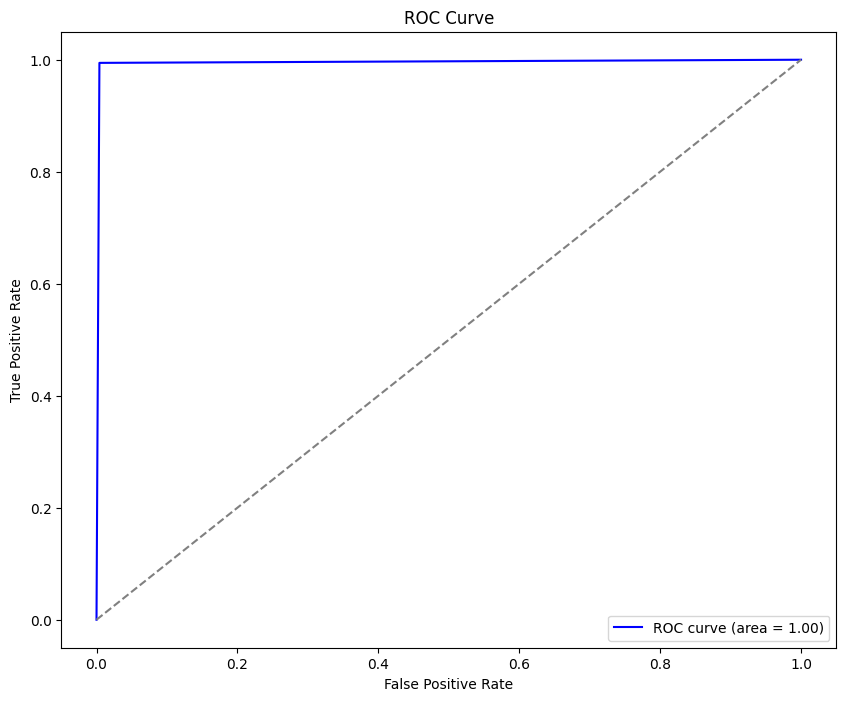

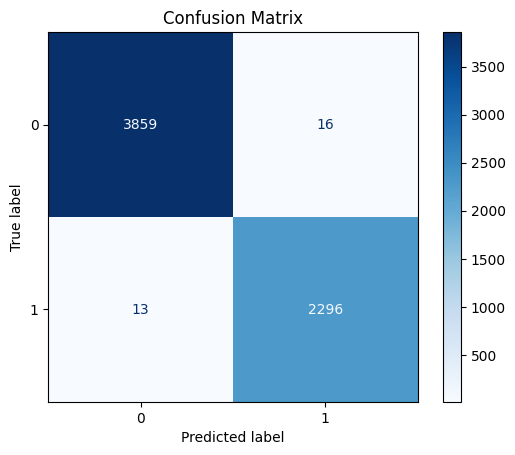

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 50/50, Step 50/773, Loss: 0.0001, Time/batch: 27.10s
Epoch 50/50, Step 100/773, Loss: 0.0000, Time/batch: 27.26s
Epoch 50/50, Step 150/773, Loss: 0.0001, Time/batch: 26.97s
Epoch 50/50, Step 200/773, Loss: 0.0000, Time/batch: 27.24s
Epoch 50/50, Step 250/773, Loss: 0.0000, Time/batch: 26.90s
Epoch 50/50, Step 300/773, Loss: 0.0000, Time/batch: 27.17s
Epoch 50/50, Step 350/773, Loss: 0.0000, Time/batch: 26.87s
Epoch 50/50, Step 400/773, Loss: 0.0000, Time/batch: 27.22s
Epoch 50/50, Step 450/773, Loss: 0.0000, Time/batch: 27.16s
Epoch 50/50, Step 500/773, Loss: 0.0000, Time/batch: 26.85s
Epoch 50/50, Step 550/773, Loss: 0.0000, Time/batch: 27.22s
Epoch 50/50, Step 600/773, Loss: 0.0000, Time/batch: 27.46s
Epoch 50/50, Step 650/773, Loss: 0.0001, Time/batch: 27.16s
Epoch 50/50, Step 700/773, Loss: 0.0001, Time/batch: 27.00s
Epoch 50/50, Step 750/773, Loss: 0.0001, Time/batch: 26.90s
Epoch 50 finished. Average training loss: 0.0078
Precision: 0.9964, Recall: 0.9964, F1-score: 0.9964,

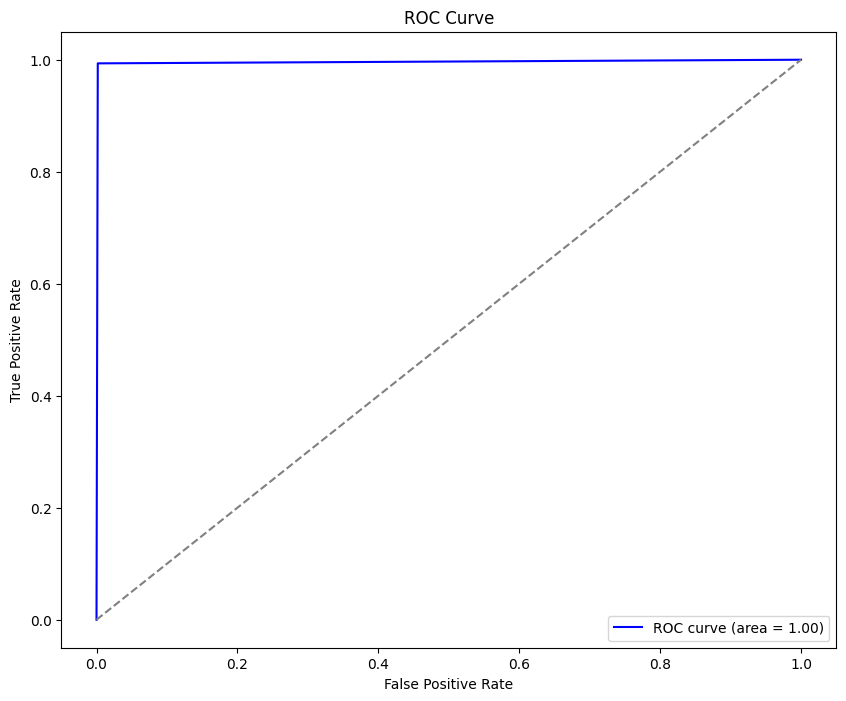

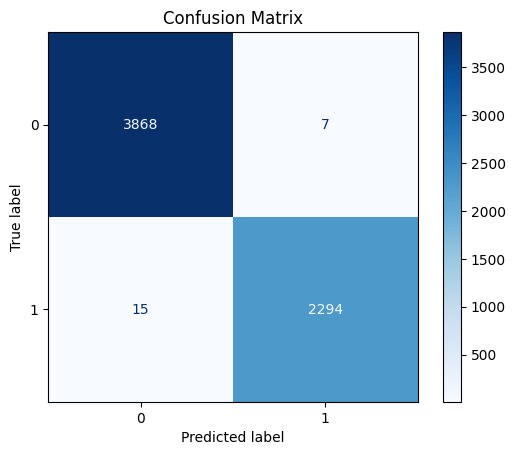

Training ended. AMP enabled: False. At 2025-02-08 08:39:14.290579
{'epoch': 1, 'avg_train_loss': 2137.4258140031834, 'precision': 0.13941480769134218, 'recall': 0.3733829236739974, 'f1': 0.20302394224967857, 'roc_auc': 0.5}
{'epoch': 2, 'avg_train_loss': 65.77301963257759, 'precision': 0.39264896034334734, 'recall': 0.6266170763260026, 'f1': 0.48277983313714284, 'roc_auc': 0.5}
{'epoch': 3, 'avg_train_loss': 3.4983524488909277, 'precision': 0.39264896034334734, 'recall': 0.6266170763260026, 'f1': 0.48277983313714284, 'roc_auc': 0.5}
{'epoch': 4, 'avg_train_loss': 1.4166980700767364, 'precision': 0.39264896034334734, 'recall': 0.6266170763260026, 'f1': 0.48277983313714284, 'roc_auc': 0.5}
{'epoch': 5, 'avg_train_loss': 2.6604898651967845, 'precision': 0.8765933664615417, 'recall': 0.8544631306597671, 'f1': 0.8454314686876322, 'roc_auc': 0.8078233001299264}
{'epoch': 6, 'avg_train_loss': 0.38125891101404596, 'precision': 0.9937061933080547, 'recall': 0.9936934023285899, 'f1': 0.993687518

In [9]:




config = {

    'model': 'bertmobile-sql-inject-detector',

    'model_name': 'google/mobilebert-uncased',

    'ft_model': '',

    'ft_model_sd': '',

    'optimizer': 'Adafactor' ,#'AdamW',

    'dynamic_padding': True,

    'use_amp': False,

    'use_autocast': False,    

    'lr': 1e-4,

    'weight_decay': 0.01,

    'EPOCHS': 50,

    'data_file': '/kaggle/input/sql-injection-dataset/Modified_SQL_Dataset.csv',

    'data_format': 'csv',

    'data_keys': ['Query', 'Label'],

    'save_loc': "modelmobile_v1",

    'log_batches': 50,

    'version': 'v1',

    'warmup_steps': 94,

    'scheduler': 'linear',

    'adafactor_config': {

        'lr': 1e-3,

        'eps': (1e-30, 1e-3),

        'clip_threshold': 1.0,

        'decay_rate': -0.8,

        'beta1': None,

        'weight_decay': 0.0,

        'relative_step': False,

        'scale_parameter': False,

        'warmup_init': False

    },

}



pipeline = SQLInjectionPipeline(config);

results = pipeline.setup_and_train()



for r in results:

    print(r)

In [10]:
print(type(results))  # Check if it's a list, dict, or something else




<class 'list'>


In [11]:
if isinstance(results, list):  # If it's a list, check the first few items
    print("Number of epochs recorded:", len(results))
    print("First epoch results:", results[0])
elif isinstance(results, dict):  # If it's a dictionary, print the keys
    print("Keys in results:", results.keys())
else:
    print("Unknown format:", results)

Number of epochs recorded: 50
First epoch results: {'epoch': 1, 'avg_train_loss': 2137.4258140031834, 'precision': 0.13941480769134218, 'recall': 0.3733829236739974, 'f1': 0.20302394224967857, 'roc_auc': 0.5}


In [14]:
from tabulate import tabulate

# Ensure results are in a list format
if isinstance(results, list) and len(results) > 0 and isinstance(results[0], dict):
    table = tabulate(results, headers="keys", tablefmt="grid")
    print(table)
else:
    print("Results are not stored as a list of dictionaries!")


+---------+------------------+-------------+----------+----------+-----------+
|   epoch |   avg_train_loss |   precision |   recall |       f1 |   roc_auc |
+=========+==================+=============+==========+==========+===========+
|       1 |    2137.43       |    0.139415 | 0.373383 | 0.203024 |  0.5      |
+---------+------------------+-------------+----------+----------+-----------+
|       2 |      65.773      |    0.392649 | 0.626617 | 0.48278  |  0.5      |
+---------+------------------+-------------+----------+----------+-----------+
|       3 |       3.49835    |    0.392649 | 0.626617 | 0.48278  |  0.5      |
+---------+------------------+-------------+----------+----------+-----------+
|       4 |       1.4167     |    0.392649 | 0.626617 | 0.48278  |  0.5      |
+---------+------------------+-------------+----------+----------+-----------+
|       5 |       2.66049    |    0.876593 | 0.854463 | 0.845431 |  0.807823 |
+---------+------------------+-------------+--------

In [15]:
print(dir(pipeline))


['EPOCHS', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_device_setup', '_initialize_metrics', 'attention_masks', 'config', 'device', 'download_and_tokenize_data', 'evaluate', 'f1_scores', 'initialize_model', 'input_ids', 'labels', 'model', 'optimizer', 'plot_confusion_matrix', 'plot_roc_curve', 'precision_scores', 'prepare_and_convert', 'recall_scores', 'roc_auc_scores', 'scheduler', 'setup_and_train', 'tokenizer', 'train', 'train_dataloader', 'val_dataloader']


In [18]:
save_path = "/kaggle/working/saved_model"

# If model is wrapped in DataParallel, unwrap it first
model_to_save = pipeline.model.module if hasattr(pipeline.model, "module") else pipeline.model

# Save model and tokenizer
model_to_save.save_pretrained(save_path)
pipeline.tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to {save_path}")


Model and tokenizer saved to /kaggle/working/saved_model


In [19]:
from transformers import MobileBertForSequenceClassification, AutoTokenizer

# Load model
model = MobileBertForSequenceClassification.from_pretrained("saved_model")
model.eval()  # Set to evaluation mode

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("saved_model")

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [20]:
import shutil

save_path = "saved_model"
zip_path = "saved_model.zip"

# Zip the saved model folder
shutil.make_archive("saved_model", 'zip', save_path)

print(f"Model zipped as {zip_path}")


Model zipped as saved_model.zip


In [21]:
from IPython.display import FileLink

FileLink("saved_model.zip")


/kaggle/working/saved_model.zip

In [ ]:
!unzip saved_model.zip -d saved_model/

from transformers import MobileBertForSequenceClassification, AutoTokenizer

model = MobileBertForSequenceClassification.from_pretrained("saved_model")
tokenizer = AutoTokenizer.from_pretrained("saved_model")

print("Model and tokenizer loaded successfully!")


In [22]:
import os

save_path = "saved_model"
os.makedirs(save_path, exist_ok=True)

# Unwrap the model if it's inside DataParallel
model_to_save = pipeline.model.module if hasattr(pipeline.model, "module") else pipeline.model

# Save the model and tokenizer
model_to_save.save_pretrained(save_path)
pipeline.tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved in {save_path}")


Model and tokenizer saved in saved_model


In [23]:
import shutil

zip_path = "saved_model.zip"

# Zip the saved model folder
shutil.make_archive("saved_model", 'zip', save_path)

print(f"Model successfully zipped as {zip_path}")


Model successfully zipped as saved_model.zip


In [24]:
from IPython.display import FileLink

FileLink("saved_model.zip")


/kaggle/working/saved_model.zip